In [1]:
setwd("..")

In [2]:
source("Source/functions.R")
library("data.table")
library("ggplot2")
library("pheatmap")
library("circlize")

circlize version 0.4.16
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))




In [3]:
snv_info <- fread("Data/snv_loci_v2.csv")
snvIDs <- snv_info[, SNVID]
mito_barcodes <- fread("Data/mito_barcodes.csv")
mitoIDs <- mito_barcodes[, ID]

chrmbases_properties <- fread("Report/artifact/chrmbases_properties.csv.gz")
chrmbases <- chrmbases_properties[, ref]
nchrmbases <- length(chrmbases)

MitoInfo <- fread("Report/metadata/MitoInfo.csv")
MitoInfo[, ExptID := factor(ExptID)]
MitoInfo[, MitoID := factor(MitoID, levels = mitoIDs)]
MitoInfo[, CellID := factor(CellID)]
MitoInfo_df <- as.data.frame(MitoInfo)
rownames(MitoInfo_df) <- MitoInfo_df[, "LibraryMitoID"]

CellInfo <- fread("Report/metadata/CellInfo.csv")
CellInfo_df <- as.data.frame(CellInfo)
rownames(CellInfo_df) <- CellInfo_df$CellUID

MouseInfo <- fread("Report/metadata/MouseInfo.csv")
MouseInfo_df <- as.data.frame(MouseInfo)
rownames(MouseInfo_df) <- MouseInfo_df$MouseID

Load data

In [4]:
basedifffreq_cutdemux_q30_unstranded <- fread(file = "Report/SNVs/basedifffreq_cutdemux_sub500k_q30_unstranded_9027fixed.csv.gz")
basedifffreq_cutdemux_q30_unstranded[, SNVID := factor(SNVID, levels = snvIDs)]
basedifffreq_cutdemux_q30_unstranded[, MitoID := factor(MitoID, levels = mitoIDs)]
basedifffreq_cutdemux_q30_unstranded[, ExptID := factor(ExptID)]
basedifffreq_cutdemux_q30_unstranded[, CellID := factor(CellID)]
basedifffreq_cutdemux_q30_unstranded[, PlateID := factor(PlateID)]
basedifffreq_cutdemux_q30_unstranded[, ref := toupper(ref)]

How many bases have > 50 depth in each mito in each SNV region?

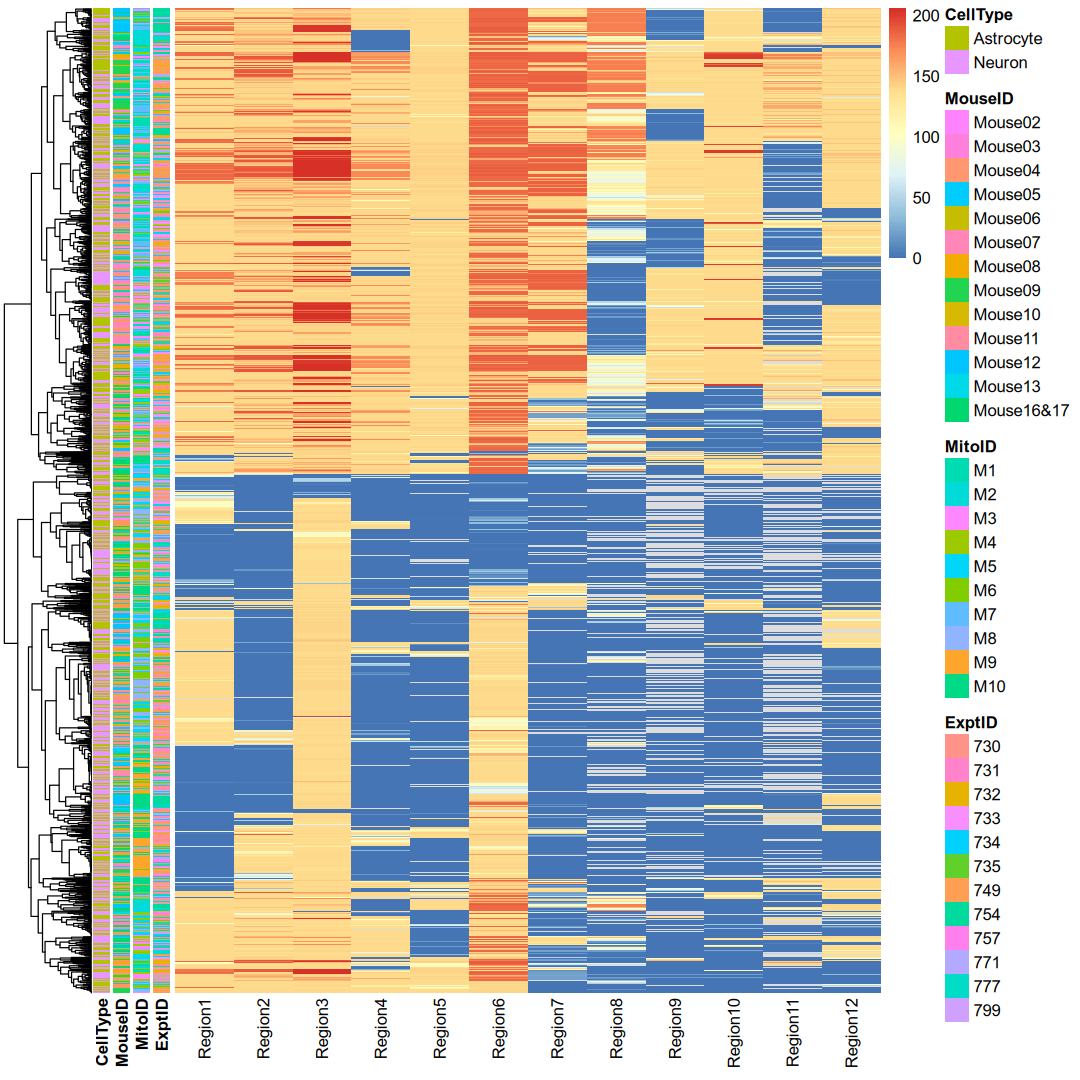

In [5]:
basedifffreq_cutdemux_q30_unstranded_nbases_highdepth <- dcast(basedifffreq_cutdemux_q30_unstranded[IsCtrl == "N", .(nbases_highdepth = sum(depth >= 50, na.rm = TRUE)), by = c("LibraryMitoID", "SNVID")], LibraryMitoID ~ SNVID, value.var = "nbases_highdepth")
basedifffreq_cutdemux_q30_unstranded_nbases_highdepth_mat <- as.matrix(basedifffreq_cutdemux_q30_unstranded_nbases_highdepth[, -1])
rownames(basedifffreq_cutdemux_q30_unstranded_nbases_highdepth_mat) <- basedifffreq_cutdemux_q30_unstranded_nbases_highdepth[, LibraryMitoID]
colnames(basedifffreq_cutdemux_q30_unstranded_nbases_highdepth_mat) <- sub("SNV", "Region", colnames(basedifffreq_cutdemux_q30_unstranded_nbases_highdepth_mat))

options(repr.plot.height = 9, repr.plot.width = 9, res = 72)
pheatmap(basedifffreq_cutdemux_q30_unstranded_nbases_highdepth_mat, annotation_row = MitoInfo_df[rownames(basedifffreq_cutdemux_q30_unstranded_nbases_highdepth_mat), c("ExptID", "MitoID", "MouseID", "CellType")], cluster_rows = TRUE, cluster_cols = FALSE, show_rownames = FALSE, angle = 90)

How do control samples work in terms of sequencing yield? 

In [6]:
basedifffreq_cutdemux_q30_unstranded_avgdepth <- basedifffreq_cutdemux_q30_unstranded[, .(avgdepth = sum(depth)/150), by = .(HasPrimers, HasRCA, HasMtDNA, Enzyme, CellType %in% c("Astrocyte", "Neuron"), SNVID, MitoID, LibraryMitoID, LibraryID)]
basedifffreq_cutdemux_q30_unstranded_avgdepth[, CellType := ifelse(CellType, "Cell", "mtDNA")]
basedifffreq_cutdemux_q30_unstranded_avgdepth[, CtrlType := paste(CellType, Enzyme, HasMtDNA, HasRCA, HasPrimers, sep = "_")]
table(basedifffreq_cutdemux_q30_unstranded_avgdepth[, CtrlType])


 Cell_None_Y_Y_Y mtDNA_None_N_Y_N mtDNA_None_N_Y_Y mtDNA_None_Y_Y_N 
           18501              144              285              166 
mtDNA_None_Y_Y_Y 
             249 

In [7]:
basedifffreq_cutdemux_q30_unstranded_avgdepth[, CtrlType:= unname(c(
    "Cell_None_Y_Y_Y" =  "single-mito mtDNA(+) RCA(+)", 
    "mtDNA_None_N_Y_N" = "pooled mtDNA(-) RCA(-)", 
    "mtDNA_None_N_Y_Y" = "pooled mtDNA(-) RCA(+)", 
    "mtDNA_None_Y_Y_N" = "pooled mtDNA(+) RCA(-)", 
    "mtDNA_None_Y_Y_Y" = "pooled mtDNA(+) RCA(+)"
)[basedifffreq_cutdemux_q30_unstranded_avgdepth[["CtrlType"]]])]
head(basedifffreq_cutdemux_q30_unstranded_avgdepth)

HasPrimers HasRCA HasMtDNA Enzyme CellType SNVID MitoID LibraryMitoID
1 Y          Y      Y        None   Cell     SNV1  M1     L1R24P1C_M1  
2 Y          Y      Y        None   Cell     SNV2  M1     L1R24P1C_M1  
3 Y          Y      Y        None   Cell     SNV3  M1     L1R24P1C_M1  
4 Y          Y      Y        None   Cell     SNV4  M1     L1R24P1C_M1  
5 Y          Y      Y        None   Cell     SNV5  M1     L1R24P1C_M1  
6 Y          Y      Y        None   Cell     SNV6  M1     L1R24P1C_M1  
  LibraryID avgdepth   CtrlType                   
1 L1R24P1C  14876.0000 single-mito mtDNA(+) RCA(+)
2 L1R24P1C   1724.6267 single-mito mtDNA(+) RCA(+)
3 L1R24P1C  14466.4933 single-mito mtDNA(+) RCA(+)
4 L1R24P1C   1595.1667 single-mito mtDNA(+) RCA(+)
5 L1R24P1C    313.0067 single-mito mtDNA(+) RCA(+)
6 L1R24P1C  10622.1933 single-mito mtDNA(+) RCA(+)

In [ ]:
fwrite(basedifffreq_cutdemux_q30_unstranded_avgdepth, file = "Report/SNVs/QC/avgdepth_byCtrlType.csv.gz")

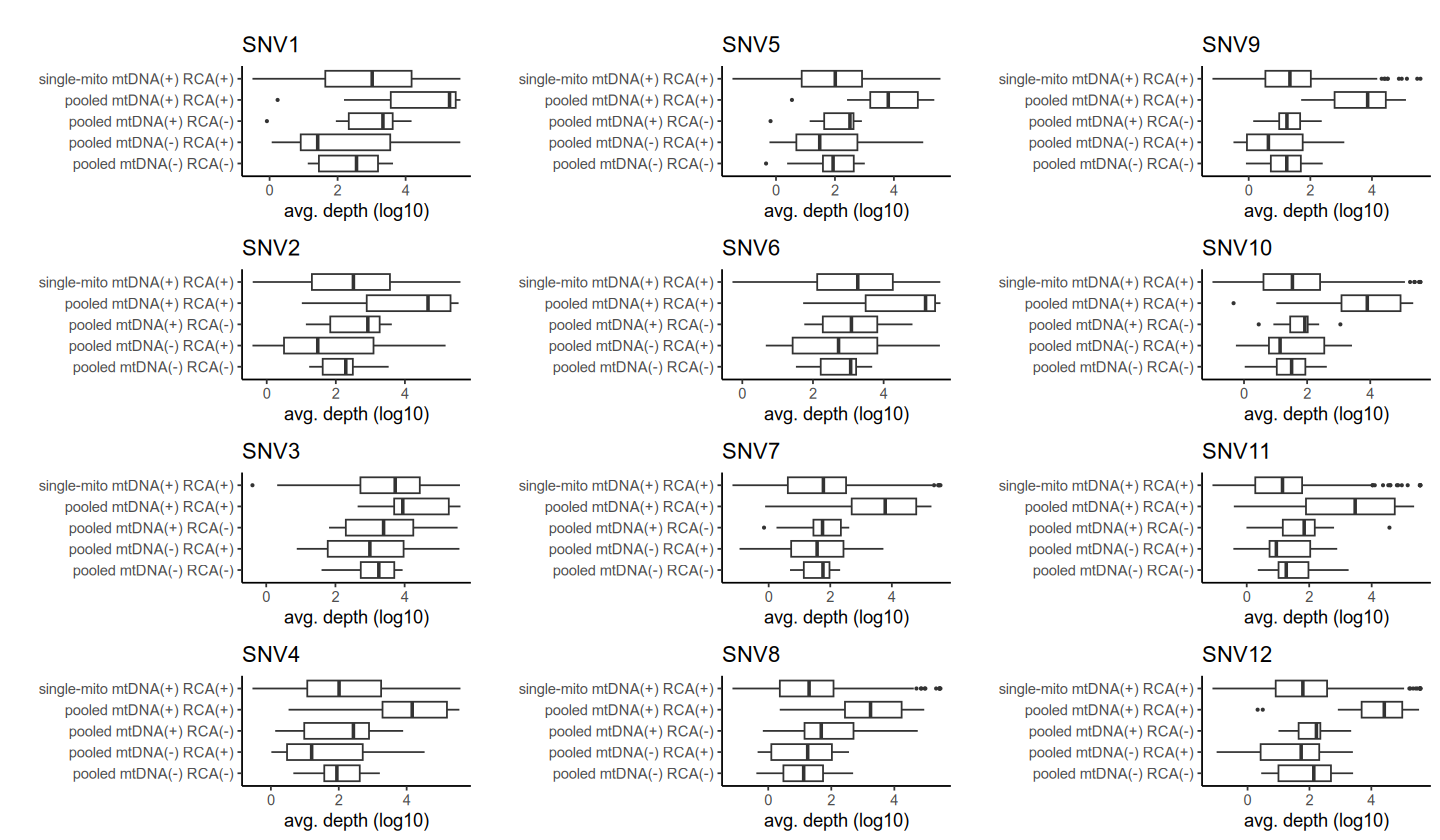

In [9]:
figs <- sapply(snvIDs, function(snv) {
    ggplot(basedifffreq_cutdemux_q30_unstranded_avgdepth[SNVID == snv], aes(x = CtrlType, y = log10(avgdepth))) + geom_boxplot(outlier.size = 0.5) + theme_classic() + xlab("") + ylab("avg. depth (log10)") + coord_flip() + ggtitle(snv)
}, simplify = FALSE)
figs <- gridExtra::marrangeGrob(figs, ncol = 3, nrow = 4, top = "")
options(repr.plot.height = 7, repr.plot.width = 12, res = 72)
invisible(print(figs))

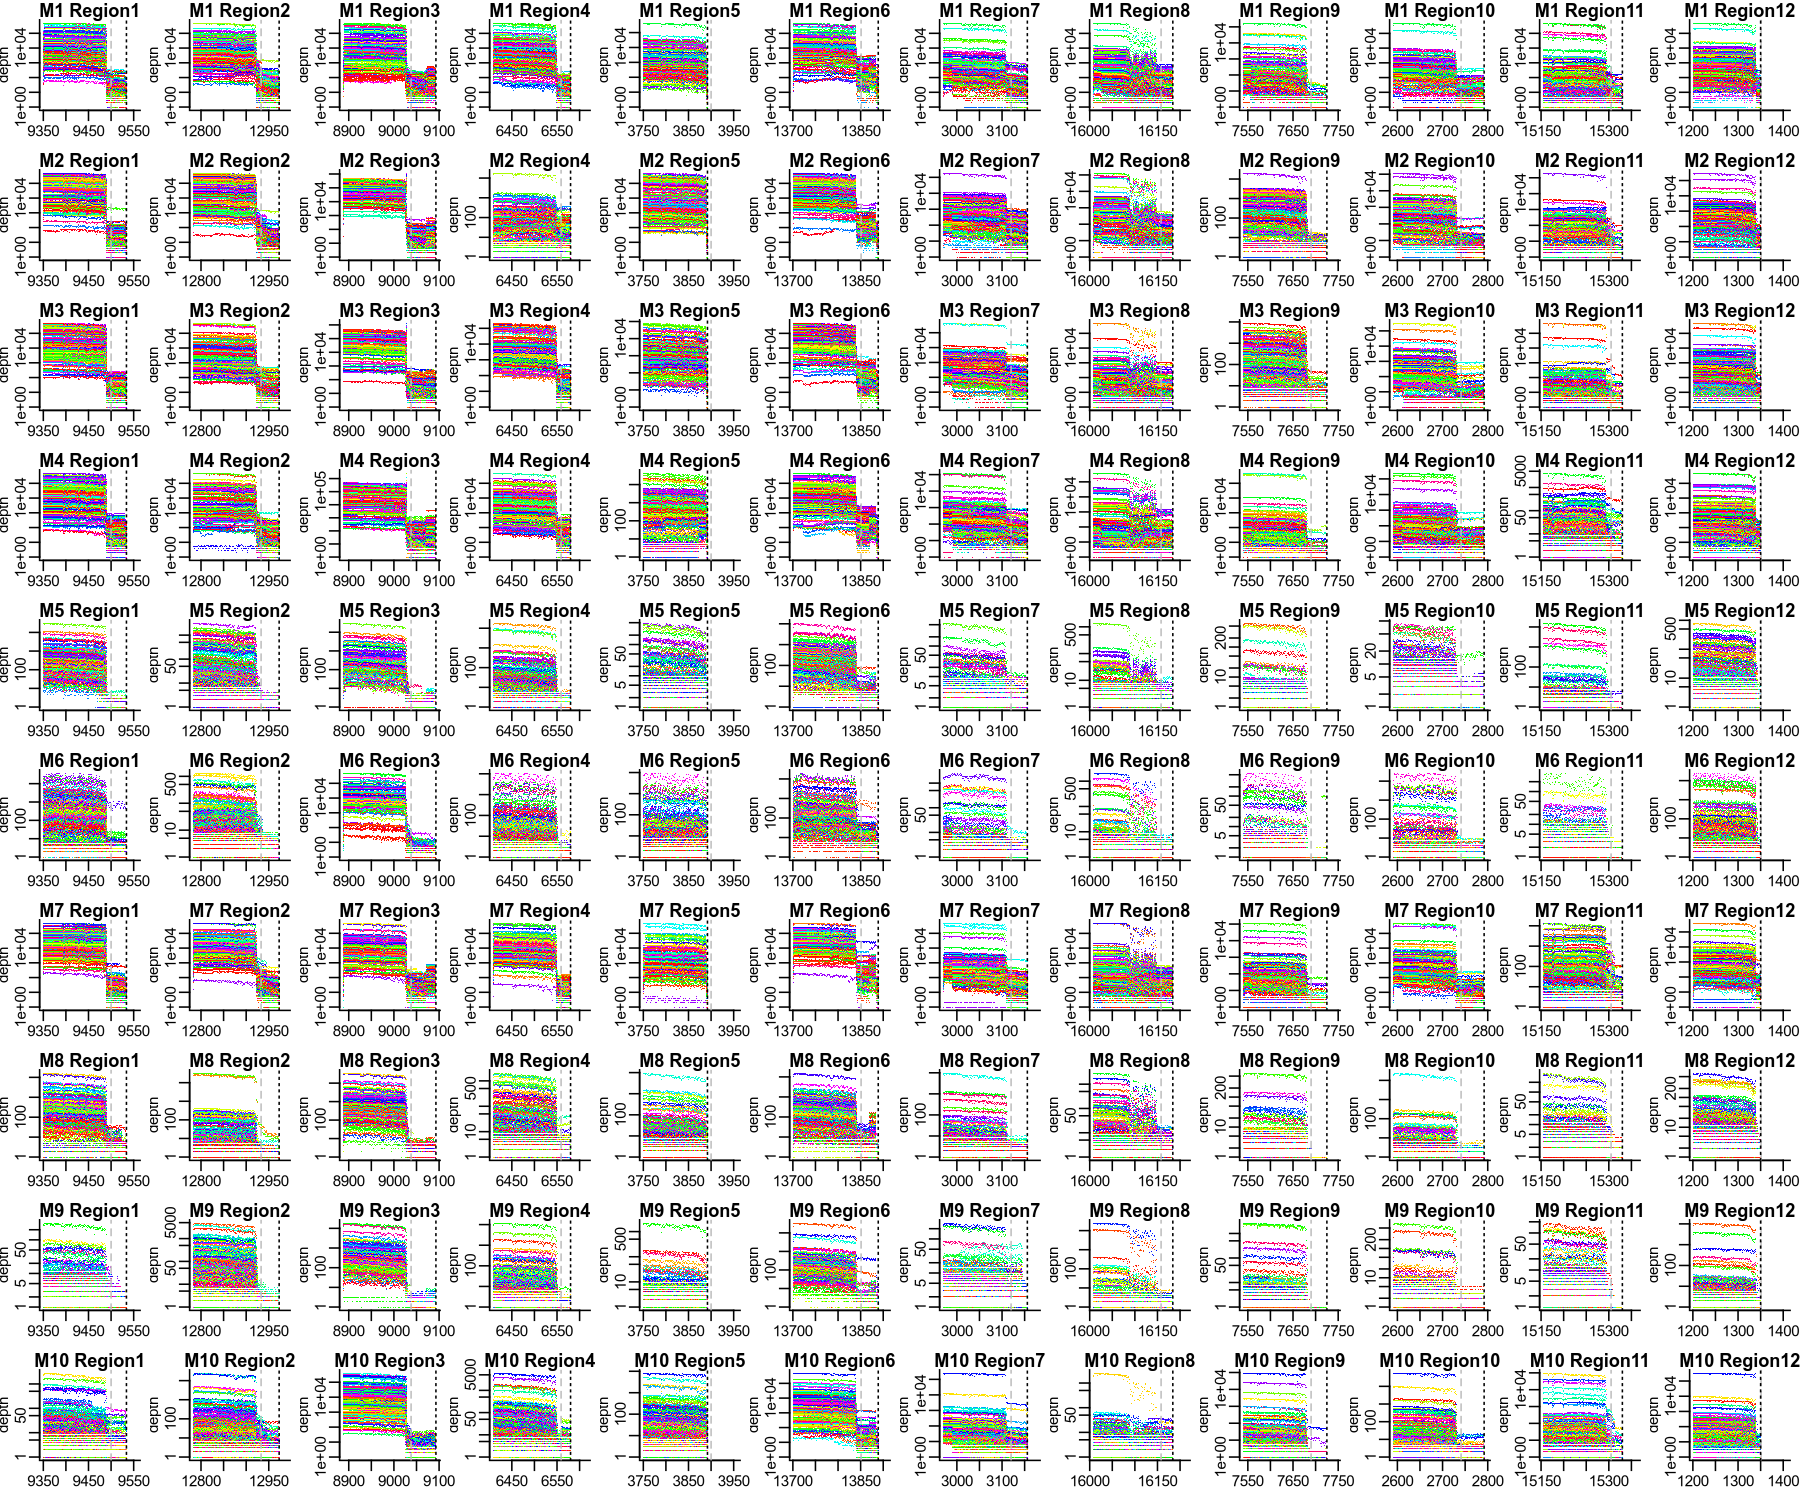

In [10]:
options(repr.plot.height = 1 * length(mitoIDs), repr.plot.width = 1 * length(snvIDs), repr.plot.res = 150)
par(ps = 11, lend = 2, ljoin = 1, bty = "L", mfrow = c(length(mitoIDs), length(snvIDs)), mar = c(2, 2, 1, 0.5), oma = c(0, 0, 0, 0), mgp = c(1.4, 0.5, 0))
for (mitoID in mitoIDs) {
    for (snvID in snvIDs) {
        X <- basedifffreq_cutdemux_q30_unstranded[IsCtrl == "N" & MitoID == mitoID & SNVID == snvID, .(depth, LibraryMitoID), by = "pos"]
        n <- length(unique(X[, LibraryMitoID]))
        palette(rainbow(n))
        with(X, plot(pos, depth, col = factor(LibraryMitoID), type = "p", xlim = c(snv_info[SNVID == snvID, Start], snv_info[SNVID == snvID, Start + snv_info[, max(Length)]]), log = "y", pch = '.', main = sprintf("%s %s", mitoID, sub("SNV", "Region", snvID)), xlab = "", ylab = "depth"))
        abline(v = snv_info[SNVID == snvID, Start] + 150, col = "gray", lwd = 1, lty = 2)
        abline(v = snv_info[SNVID == snvID, End], col = "black", lwd = 1, lty = 3)
    }
}

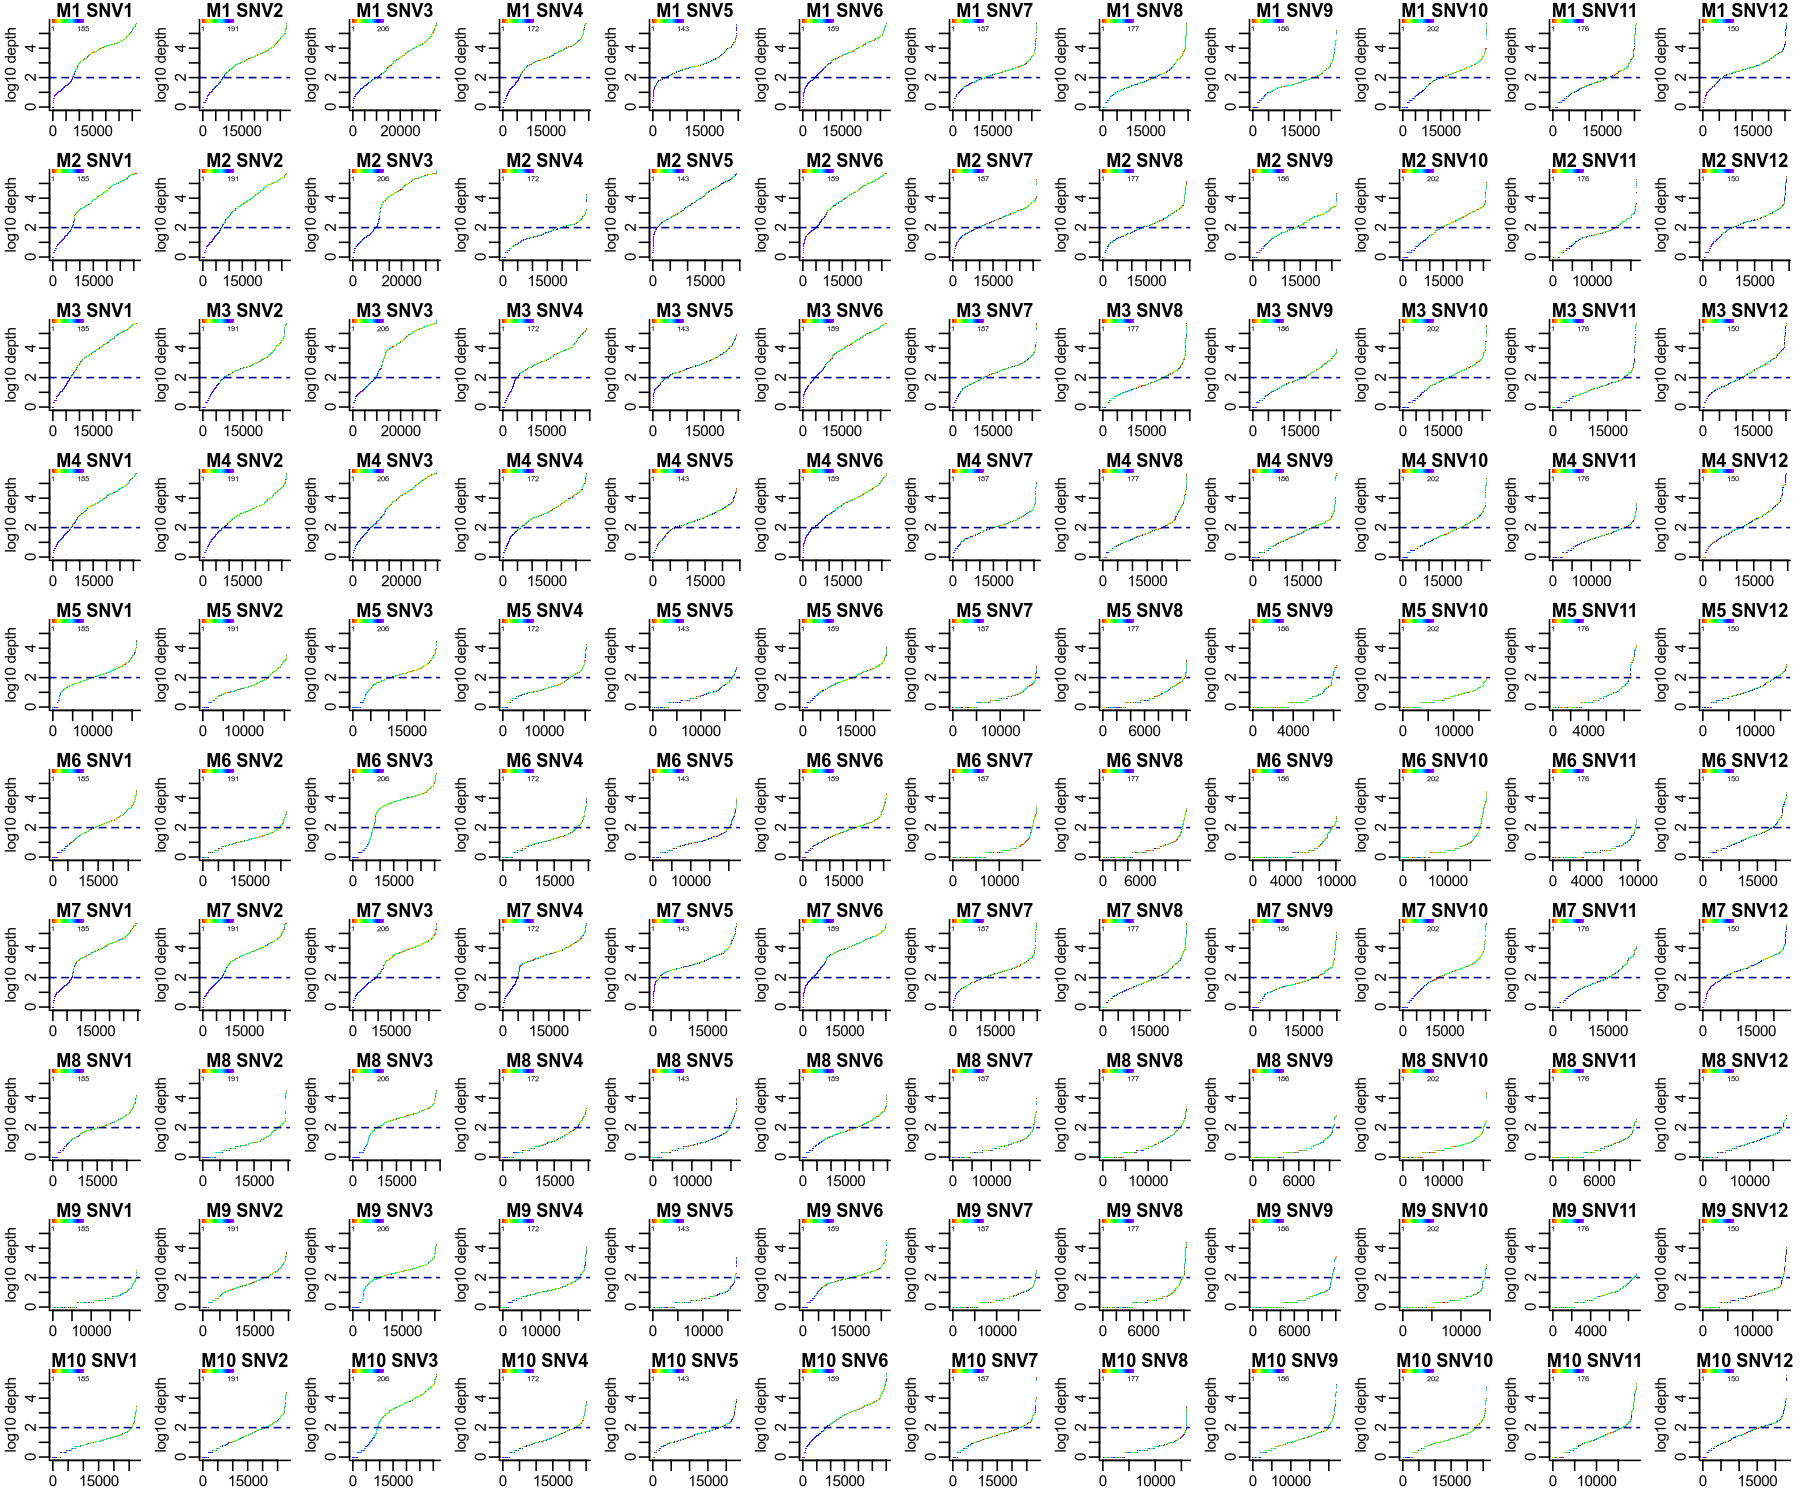

In [11]:
options(repr.plot.height = 1 * length(mitoIDs), repr.plot.width = 1 * length(snvIDs), repr.plot.res = 150)
par(ps = 11, lend = 2, ljoin = 1, bty = "L", mfrow = c(length(mitoIDs), length(snvIDs)), mar = c(2, 2.5, 1, 0.5), oma = c(0, 0, 0, 0), mgp = c(1.5, 0.5, 0))
for (mitoID in mitoIDs) {
    for (snvID in snvIDs) {
        X <- basedifffreq_cutdemux_q30_unstranded[IsCtrl == "N" & MitoID == mitoID & SNVID == snvID][order(depth)]
        x <- X[, depth]
        y <- X[, pos] - snv_info[SNVID == snvID, Start] + 1
        plot(log10(x), xlab = "", ylab = "log10 depth", main = sprintf("%s %s", mitoID, snvID), pch = '.', col = rainbow(255)[1:200][cut(y, breaks = seq(1, snv_info[SNVID == snvID, End - Start + 1], length.out = 200), include.lowest = TRUE)], ylim = c(0, log10(500000)))
        abline(h = 2, col = "navyblue", lwd = 1, lty = 2)
        xy <- par()$usr
        segments(x0 = seq(0, (xy[2] - xy[1]) / 3, length.out = 200), x1 = seq(0, (xy[2] - xy[1]) / 3, length.out = 200), y0 = xy[4] - (xy[4] - xy[3])/50, y1 = xy[4], col = rainbow(255)[1:200], xpd = TRUE)
        text(x = 0, y = xy[4] - (xy[4] - xy[3])/10, label = 1, cex = 0.5)
        text(x = (xy[2] - xy[1]) / 3, y = xy[4] - (xy[4] - xy[3])/10, label = snv_info[SNVID == snvID, Length], cex = 0.5)
    }
}

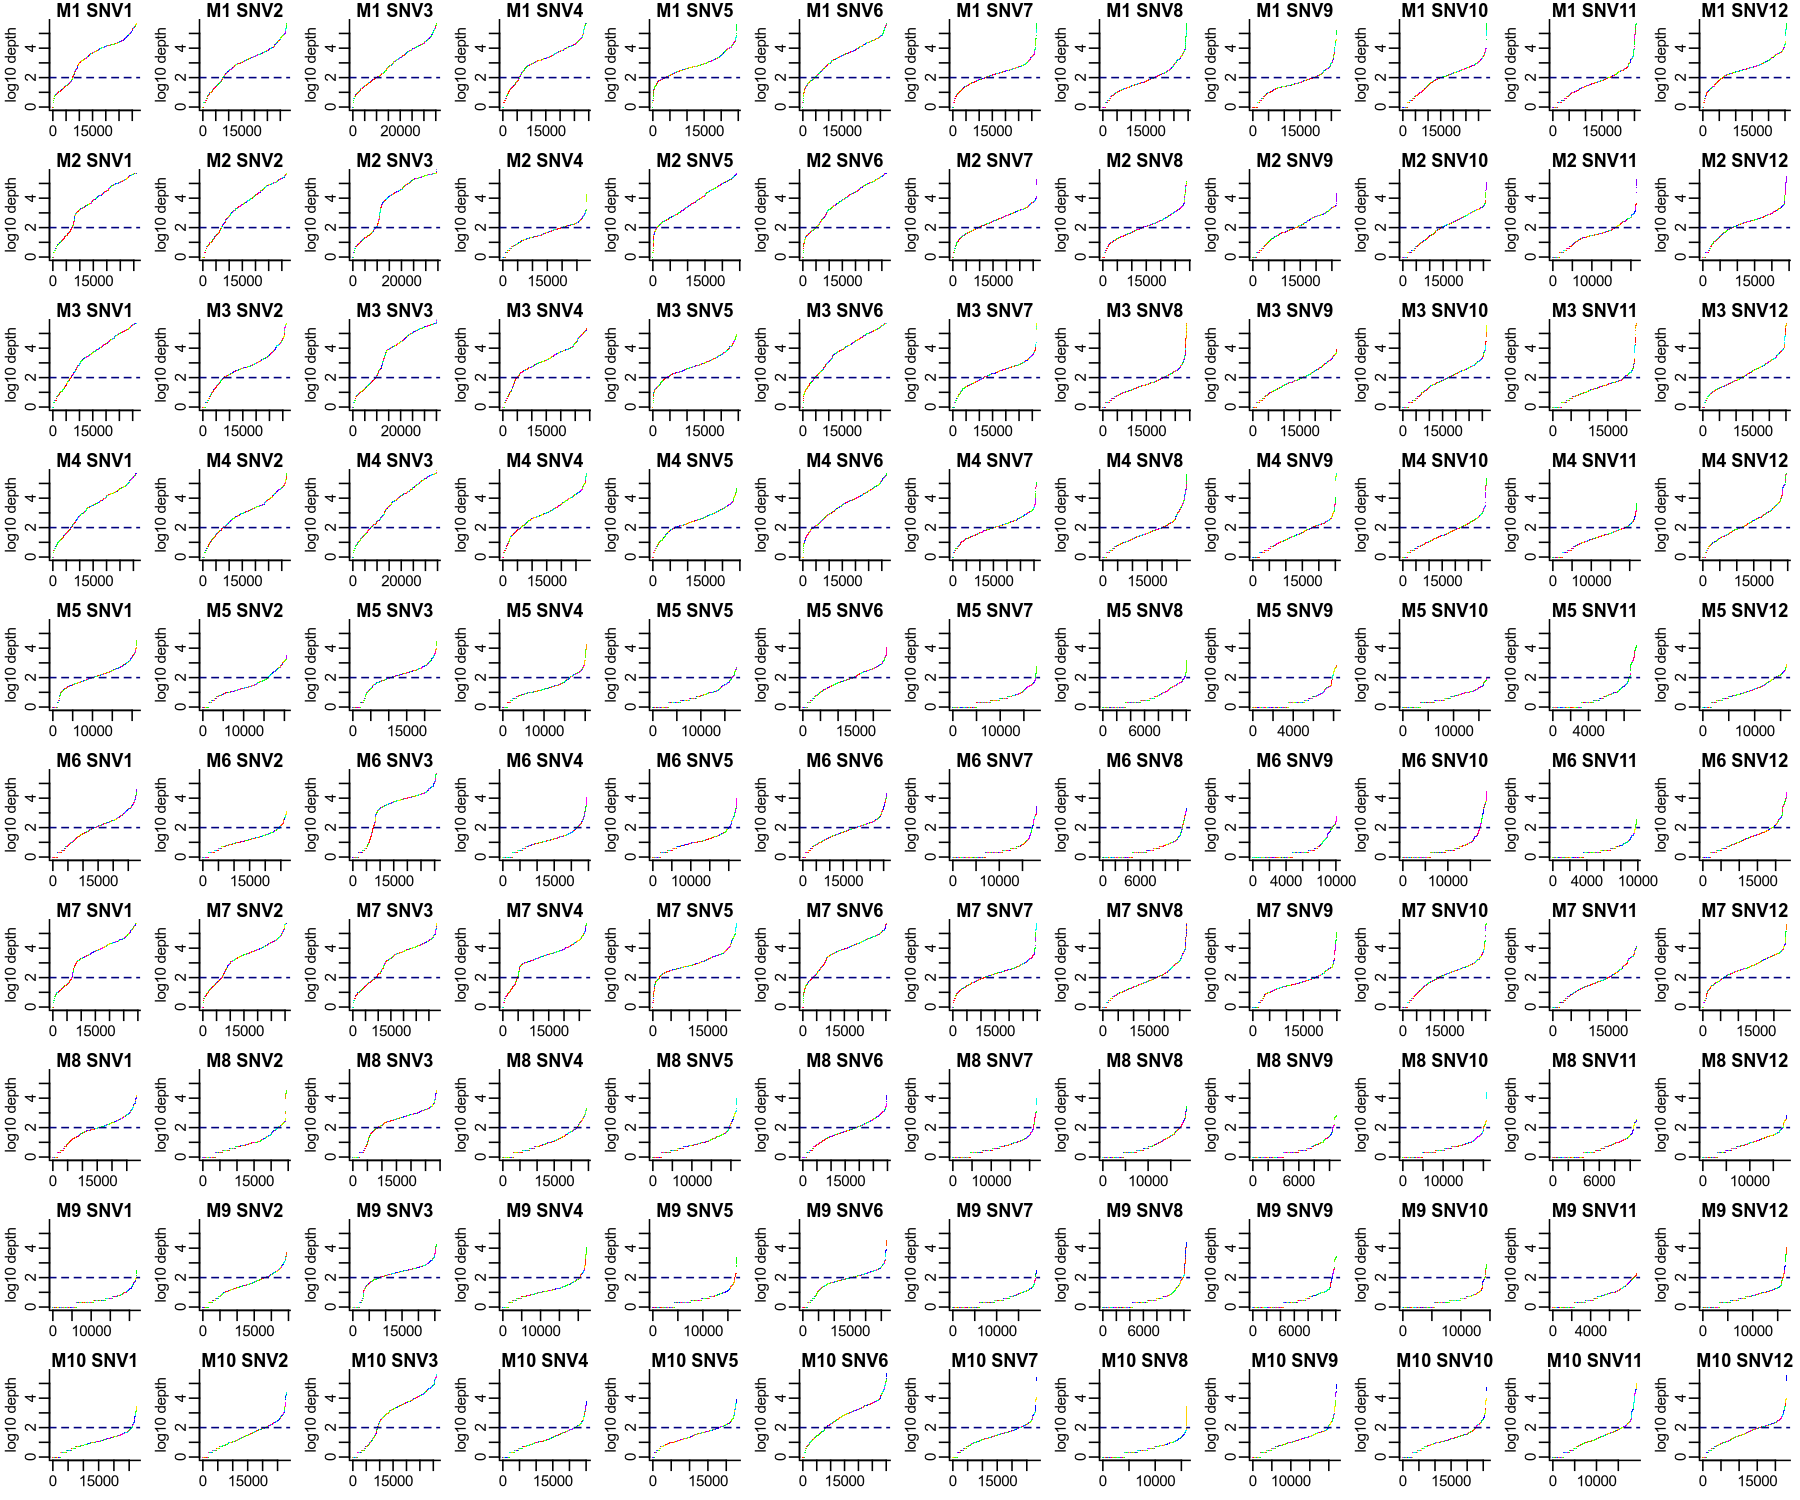

In [12]:
options(repr.plot.height = 1 * length(mitoIDs), repr.plot.width = 1 * length(snvIDs), repr.plot.res = 150)
par(ps = 11, lend = 2, ljoin = 1, bty = "L", mfrow = c(length(mitoIDs), length(snvIDs)), mar = c(2, 2.5, 1, 0.5), oma = c(0, 0, 0, 0), mgp = c(1.5, 0.5, 0))
for (mitoID in mitoIDs) {
    for (snvID in snvIDs) {
        X <- basedifffreq_cutdemux_q30_unstranded[IsCtrl == "N" & MitoID == mitoID & SNVID == snvID][order(depth)]
        x <- X[, depth]
        y <- factor(X[, LibraryMitoID])
        palette(rainbow(nlevels(y)))
        plot(log10(x), xlab = "", ylab = "log10 depth", main = sprintf("%s %s", mitoID, snvID), pch = '.', col = y, ylim = c(0, log10(500000)))
        abline(h = 2, col = "navyblue", lwd = 1, lty = 2)
    }
}

In [13]:
summary(basedifffreq_cutdemux_q30_unstranded$depth)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      1       9      74   12582     999 2595925 

In [14]:
basedifffreq_cutdemux_q30_unstranded_depthstats <- basedifffreq_cutdemux_q30_unstranded[, .SD, .SDcols = c("LibraryMitoID", "depth"), by = c("LibraryMitoID", "SNVID")]
basedifffreq_cutdemux_q30_unstranded_depthstats <- basedifffreq_cutdemux_q30_unstranded[, .SD, .SDcols = c("depth"), by = c("LibraryMitoID", "SNVID")]

depth_th <- 50
basedifffreq_cutdemux_q30_unstranded_depthstats <- basedifffreq_cutdemux_q30_unstranded_depthstats[, list(
    sum = sum(depth), 
    max = max(depth), 
    min = min(depth), 
    mean = mean(depth),
    median = median(depth), 
    sd = sd(depth), 
    n_highdepth = sum(depth >= depth_th)
    ), 
by = c("LibraryMitoID", "SNVID")]
basedifffreq_cutdemux_q30_unstranded_depthstats <- MitoInfo[basedifffreq_cutdemux_q30_unstranded_depthstats, on = "LibraryMitoID"]
basedifffreq_cutdemux_q30_unstranded_depthstats[, SNVID := factor(SNVID, levels = snvIDs)]
head(basedifffreq_cutdemux_q30_unstranded_depthstats)

LibraryID ExptID LibraryMitoID IsolationRCADate DIVDays CellType PlateID
1 L1R24P1C  730    L1R24P1C_M1   2020-09-04       3       Neuron   1      
2 L1R24P1C  730    L1R24P1C_M1   2020-09-04       3       Neuron   1      
3 L1R24P1C  730    L1R24P1C_M1   2020-09-04       3       Neuron   1      
4 L1R24P1C  730    L1R24P1C_M1   2020-09-04       3       Neuron   1      
5 L1R24P1C  730    L1R24P1C_M1   2020-09-04       3       Neuron   1      
6 L1R24P1C  730    L1R24P1C_M1   2020-09-04       3       Neuron   1      
  CellID CellUID          WellMitoBarcode ⋯ HasRCA IsCtrl SNVID sum     max  
1 2      Mouse05_Neuron_2 B1--M1          ⋯ Y      N      SNV1  2231400 19419
2 2      Mouse05_Neuron_2 B1--M1          ⋯ Y      N      SNV2   258694  2271
3 2      Mouse05_Neuron_2 B1--M1          ⋯ Y      N      SNV3  2169974 19301
4 2      Mouse05_Neuron_2 B1--M1          ⋯ Y      N      SNV4   239275  2215
5 2      Mouse05_Neuron_2 B1--M1          ⋯ Y      N      SNV5    46951   413
6 2      Mouse05_Neuron_2 B1--M1          ⋯ Y      N      SNV6  1593329 14322
  min mean       median  sd         n_highdepth
1 3   12061.6216 14889.0 7277.05518 140        
2 2    1376.0319  1703.5  847.47324 140        
3 9   10533.8544 13838.5 7685.64497 162        
4 2    1391.1337  1599.5  727.48465 140        
5 7     328.3287   344.0   66.22058 140        
6 1    8475.1543 10447.0 5275.10408 182

In [ ]:
fwrite(basedifffreq_cutdemux_q30_unstranded_depthstats, file = "Report/SNVs/QC/depthstats.csv.gz")

In [16]:
basedifffreq_cutdemux_q30_unstranded_depthstats_nbaseshighdepth <- dcast(basedifffreq_cutdemux_q30_unstranded_depthstats, LibraryMitoID ~ SNVID, value.var = "n_highdepth", fill = 0)
basedifffreq_cutdemux_q30_unstranded_depthstats_nbaseshighdepth[, c("sum", "max", "min", "mean", "median", "sd") := list(rowSums(.SD), apply(.SD, 1, max), apply(.SD, 1, min), apply(.SD, 1, mean), apply(.SD, 1, median), apply(.SD, 1, sd)), .SDcols = -"LibraryMitoID"]
basedifffreq_cutdemux_q30_unstranded_depthstats_nbaseshighdepth <- MitoInfo[basedifffreq_cutdemux_q30_unstranded_depthstats_nbaseshighdepth, on = "LibraryMitoID"]
head(basedifffreq_cutdemux_q30_unstranded_depthstats_nbaseshighdepth)

LibraryID ExptID LibraryMitoID IsolationRCADate DIVDays CellType PlateID
1 CTRR23P1B 733    CTRR23P1B_M1  2020-08-28       3                NA     
2 CTRR23P1B 733    CTRR23P1B_M10 2020-08-28       3                NA     
3 CTRR23P1B 733    CTRR23P1B_M2  2020-08-28       3                NA     
4 CTRR23P1B 733    CTRR23P1B_M3  2020-08-28       3                NA     
5 CTRR23P1B 733    CTRR23P1B_M4  2020-08-28       3                NA     
6 CTRR23P1B 733    CTRR23P1B_M6  2020-08-28       3                NA     
  CellID CellUID WellMitoBarcode ⋯ SNV9 SNV10 SNV11 SNV12 sum  max min
1 NA             (+)/(+) M1      ⋯ 142  142   142   142   1857 206 141
2 NA             (-)/(-) M10     ⋯   0    0     0   133    722 140   0
3 NA             (+)/(+) M2      ⋯ 140  140   161   139   1751 184 139
4 NA             (-)/(+) M3      ⋯   0  117   100   146   1666 190   0
5 NA             (-)/(+) M4      ⋯  40  201    96   150   1800 201  40
6 NA             (+)/(-) M6      ⋯   0    0     0    30    402 139   0
  mean      median sd      
1 154.75000 142.0  21.43966
2  60.16667  28.5  66.59762
3 145.91667 140.5  13.39239
4 138.83333 147.0  54.80848
5 150.00000 148.5  45.38322
6  33.50000   0.0  56.07057

In [ ]:
fwrite(basedifffreq_cutdemux_q30_unstranded_depthstats_nbaseshighdepth, file = "Report/SNVs/QC/highdepthstats.csv.gz")

Binary table: whether nonmissing data in mito/cell/mouse X at site Y

In [18]:
basediffperc_cutdemux_q30_unstranded_highdepth <- fread("Report/SNVs/filter/basediffperc_cutdemux_sub500k_q30_unstranded_highdepth_qcfltd.csv.gz")
basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bymito_bypos <- dcast.data.table(basediffperc_cutdemux_q30_unstranded_highdepth[IsCtrl == "N"], LibraryMitoID ~ pos, value.var = "depth", fun.aggregate = function(x) ifelse(any(x), 1, 0))
basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bymito_bypos <- merge.data.table(MitoInfo[IsCtrl == "N"], basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bymito_bypos, by = "LibraryMitoID", all.x = TRUE)
head(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bymito_bypos)

LibraryMitoID LibraryID ExptID IsolationRCADate DIVDays CellType PlateID
1 DepSeq-L1_M1  DepSeq-L1 799    2020-08-28       3       Neuron   1      
2 DepSeq-L1_M2  DepSeq-L1 799    2020-08-28       3       Neuron   1      
3 DepSeq-L1_M3  DepSeq-L1 799    2020-08-28       3       Neuron   2      
4 DepSeq-L1_M4  DepSeq-L1 799    2020-08-14       3       Neuron   1      
5 DepSeq-L1_M6  DepSeq-L1 799    2020-08-14       3       Neuron   2      
6 DepSeq-L1_M7  DepSeq-L1 799    2020-09-15       3       Neuron   1      
  CellID CellUID          WellMitoBarcode ⋯ 16118 16119 16120 16122 16123 16124
1 3      Mouse04_Neuron_3 D11--M1         ⋯ 0     0     0     0     0     0    
2 6      Mouse04_Neuron_6 E12--M2         ⋯ 0     0     0     0     0     0    
3 5      Mouse04_Neuron_5 E11--M3         ⋯ 0     0     0     0     0     0    
4 6      Mouse02_Neuron_6 D5--M4          ⋯ 0     0     0     1     1     1    
5 9      Mouse02_Neuron_9 B5--M6          ⋯ 0     0     0     0     0     0    
6 1      Mouse06_Neuron_1 A5--M7          ⋯ 0     0     0     0     0     0    
  16125 16133 16140 16141
1 0     0     0     0    
2 0     0     0     0    
3 0     0     0     0    
4 1     0     0     0    
5 0     0     0     0    
6 0     0     0     0

In [ ]:
fwrite(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bymito_bypos, file = "Report/SNVs/QC/highdepth_noctrl_hasdata_bymito_bypos.csv.gz")

In [20]:
basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bycell_bypos <- dcast.data.table(basediffperc_cutdemux_q30_unstranded_highdepth[IsCtrl == "N"], CellUID ~ pos, value.var = "depth", fun.aggregate = function(x) ifelse(any(x), 1, 0))
basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bycell_bypos <- merge.data.table(CellInfo, basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bycell_bypos, by = "CellUID", all.x = TRUE)
head(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bycell_bypos)

CellUID           IsolationRCADate DIVDays CellType CellID RCAID MouseID 1224
1 Mouse02_Neuron_10 2020-08-14       3       Neuron   10     R20   Mouse02 0   
2 Mouse02_Neuron_4  2020-08-14       3       Neuron    4     R20   Mouse02 0   
3 Mouse02_Neuron_6  2020-08-14       3       Neuron    6     R20   Mouse02 1   
4 Mouse02_Neuron_8  2020-08-14       3       Neuron    8     R20   Mouse02 0   
5 Mouse02_Neuron_9  2020-08-14       3       Neuron    9     R20   Mouse02 1   
6 Mouse03_Neuron_11 2020-08-21       3       Neuron   11     R22   Mouse03 1   
  1225 1226 ⋯ 16118 16119 16120 16122 16123 16124 16125 16133 16140 16141
1 0    0    ⋯ 0     0     0     0     0     0     0     0     0     0    
2 0    0    ⋯ 0     0     0     0     0     0     0     0     0     0    
3 1    1    ⋯ 0     0     0     1     1     1     1     0     0     0    
4 0    0    ⋯ 0     0     0     0     0     0     0     0     0     0    
5 1    1    ⋯ 0     0     0     1     1     1     1     0     0     0    
6 1    1    ⋯ 0     0     0     1     1     1     1     0     0     0

In [ ]:
fwrite(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bycell_bypos, file = "Report/SNVs/QC/highdepth_noctrl_hasdata_bycell_bypos.csv.gz")

In [22]:
basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bymouse_bypos <- dcast.data.table(basediffperc_cutdemux_q30_unstranded_highdepth[IsCtrl == "N"], MouseID ~ pos, value.var = "depth", fun.aggregate = function(x) ifelse(any(x), 1, 0))
basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bymouse_bypos <- merge.data.table(MouseInfo, basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bymouse_bypos, by = "MouseID", all.x = TRUE)
head(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bymouse_bypos)

MouseID RCAID       1224 1225 1226 1228 1229 1230 1231 1232 ⋯ 16118 16119
1 Mouse02 R20         1    1    1    1    1    1    1    1    ⋯ 0     0    
2 Mouse03 R22         1    1    1    1    1    1    1    1    ⋯ 1     1    
3 Mouse04 R23         1    1    1    1    1    1    1    1    ⋯ 1     1    
4 Mouse05 R24         1    1    1    1    1    1    1    1    ⋯ 1     1    
5 Mouse06 R25         1    1    1    1    1    1    1    1    ⋯ 1     1    
6 Mouse07 R29,R22,R23 1    1    1    1    1    1    1    1    ⋯ 1     1    
  16120 16122 16123 16124 16125 16133 16140 16141
1 0     1     1     1     1     0     0     0    
2 1     1     1     1     1     1     1     1    
3 1     1     1     1     1     1     1     1    
4 1     1     1     1     1     1     1     1    
5 1     1     1     1     1     1     1     1    
6 1     1     1     1     1     1     1     1

In [ ]:
fwrite(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bymouse_bypos, file = "Report/SNVs/QC/highdepth_noctrl_hasdata_bymouse_bypos.csv.gz")

For each mito/cell/mouse, how many sites have non-missing data?

In [24]:
basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_nposhasdata_bymito <- data.table(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bymito_bypos[, 1:19], nposhasdata = rowSums(as.matrix(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bymito_bypos[, -c(1:19)])))
head(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_nposhasdata_bymito)

LibraryMitoID LibraryID ExptID IsolationRCADate DIVDays CellType PlateID
1 DepSeq-L1_M1  DepSeq-L1 799    2020-08-28       3       Neuron   1      
2 DepSeq-L1_M2  DepSeq-L1 799    2020-08-28       3       Neuron   1      
3 DepSeq-L1_M3  DepSeq-L1 799    2020-08-28       3       Neuron   2      
4 DepSeq-L1_M4  DepSeq-L1 799    2020-08-14       3       Neuron   1      
5 DepSeq-L1_M6  DepSeq-L1 799    2020-08-14       3       Neuron   2      
6 DepSeq-L1_M7  DepSeq-L1 799    2020-09-15       3       Neuron   1      
  CellID CellUID          WellMitoBarcode WellID MitoID HasMtDNA HasPrimers
1 3      Mouse04_Neuron_3 D11--M1         D11    M1     Y        Y         
2 6      Mouse04_Neuron_6 E12--M2         E12    M2     Y        Y         
3 5      Mouse04_Neuron_5 E11--M3         E11    M3     Y        Y         
4 6      Mouse02_Neuron_6 D5--M4          D5     M4     Y        Y         
5 9      Mouse02_Neuron_9 B5--M6          B5     M6     Y        Y         
6 1      Mouse06_Neuron_1 A5--M7          A5     M7     Y        Y         
  RCAID MouseID Enzyme HasRCA IsCtrl nposhasdata
1 R23   Mouse04 None   Y      N      551        
2 R23   Mouse04 None   Y      N      592        
3 R23   Mouse04 None   Y      N      752        
4 R20   Mouse02 None   Y      N      697        
5 R20   Mouse02 None   Y      N      243        
6 R25   Mouse06 None   Y      N      655

In [ ]:
fwrite(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_nposhasdata_bymito, file = "Report/SNVs/QC/highdepth_noctrl_nposhasdata_bymito.csv")

In [26]:
basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_nposhasdata_bycell <- data.table(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bycell_bypos[, 1:7], nposhasdata = rowSums(as.matrix(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bycell_bypos[, -c(1:7)])))
head(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_nposhasdata_bycell)

CellUID           IsolationRCADate DIVDays CellType CellID RCAID MouseID
1 Mouse02_Neuron_10 2020-08-14       3       Neuron   10     R20   Mouse02
2 Mouse02_Neuron_4  2020-08-14       3       Neuron    4     R20   Mouse02
3 Mouse02_Neuron_6  2020-08-14       3       Neuron    6     R20   Mouse02
4 Mouse02_Neuron_8  2020-08-14       3       Neuron    8     R20   Mouse02
5 Mouse02_Neuron_9  2020-08-14       3       Neuron    9     R20   Mouse02
6 Mouse03_Neuron_11 2020-08-21       3       Neuron   11     R22   Mouse03
  nposhasdata
1 511        
2 592        
3 818        
4 238        
5 793        
6 818

In [ ]:
fwrite(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_nposhasdata_bycell, file = "Report/SNVs/QC/highdepth_noctrl_nposhasdata_bycell.csv")

In [28]:
basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_nposhasdata_bymouse <- data.table(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bymouse_bypos[, 1:2], nposhasdata = rowSums(as.matrix(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bymouse_bypos[, -c(1:2)])))
head(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_nposhasdata_bymouse)

MouseID RCAID       nposhasdata
1 Mouse02 R20         818        
2 Mouse03 R22         838        
3 Mouse04 R23         838        
4 Mouse05 R24         838        
5 Mouse06 R25         838        
6 Mouse07 R29,R22,R23 838

In [ ]:
fwrite(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_nposhasdata_bymouse, file = "Report/SNVs/QC/highdepth_noctrl_nposhasdata_bymouse.csv")

For each site, how many mitos/cells/mice have non-missing data?

In [30]:
basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_nsampleshasdata_bypos <- data.table(
    pos = as.integer(names(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bymito_bypos[, -c(1:19)])), 
    nmitoshasdata = colSums(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bymito_bypos[, names(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bymito_bypos[, -c(1:19)]), with = FALSE], na.rm = TRUE), 
    ncellshasdata = colSums(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bycell_bypos[, names(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bymito_bypos[, -c(1:19)]), with = FALSE], na.rm = TRUE), 
    nmicehasdata = colSums(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bymouse_bypos[, names(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bymito_bypos[, -c(1:19)]), with = FALSE], na.rm = TRUE)
)
head(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_nsampleshasdata_bypos)

pos  nmitoshasdata ncellshasdata nmicehasdata
1 1224 842           96            13          
2 1225 854           96            13          
3 1226 842           96            13          
4 1228 848           96            13          
5 1229 847           96            13          
6 1230 831           96            13

In [ ]:
fwrite(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_nsampleshasdata_bypos, file = "Report/SNVs/QC/highdepth_noctrl_nsampleshasdata_bypos.csv")

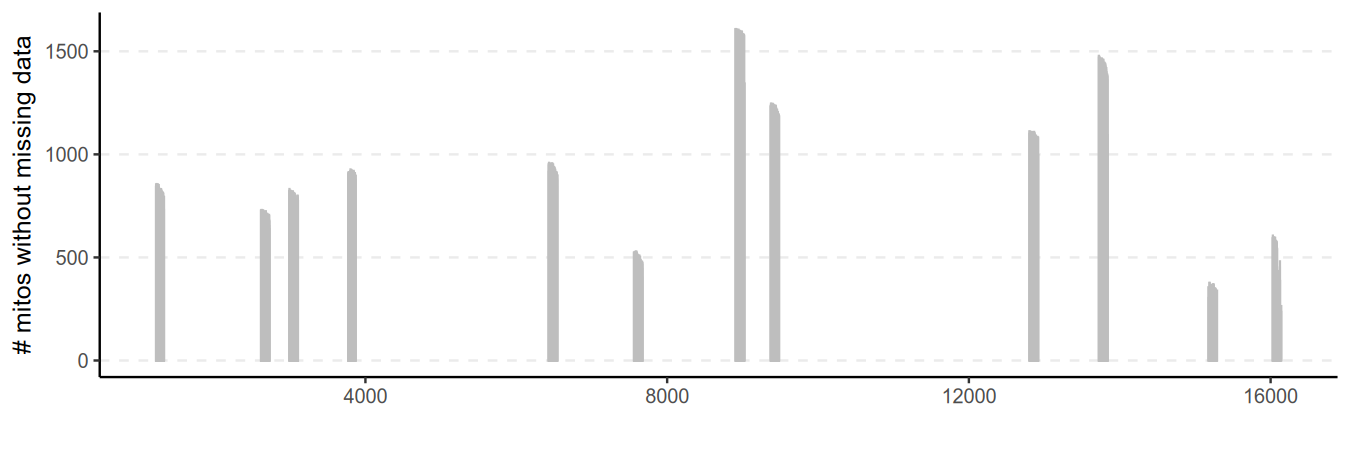

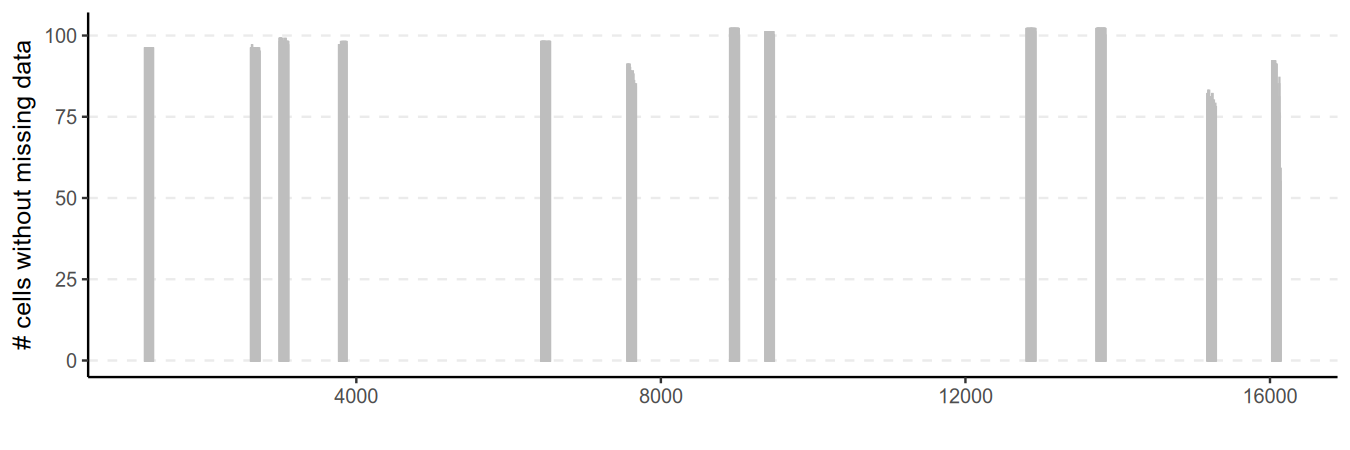

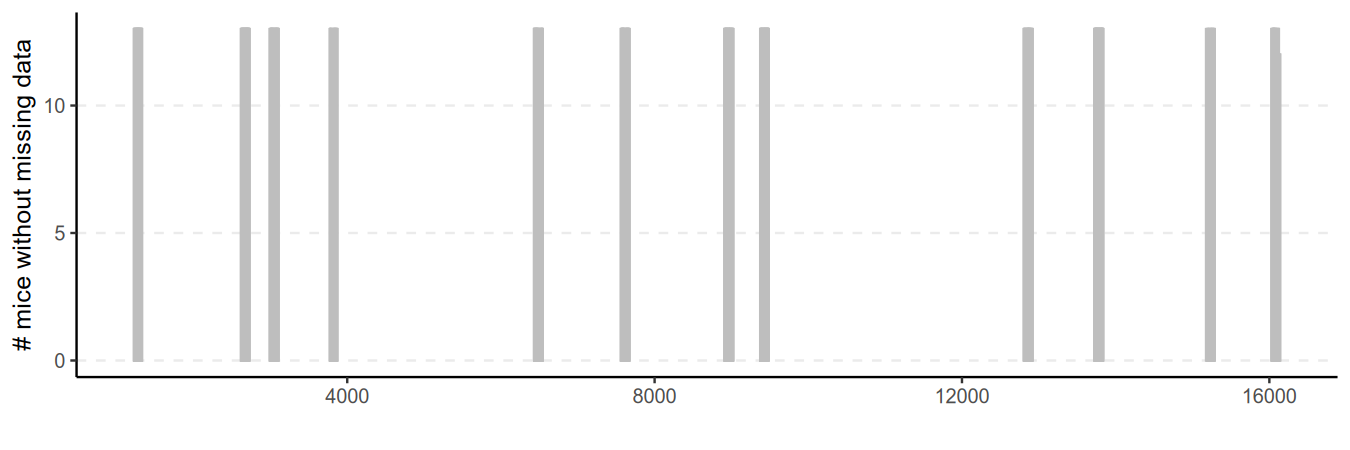

In [32]:
options(repr.plot.height = 3, repr.plot.width = 9, res = 72)
ggplot(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_nsampleshasdata_bypos, aes(y = nmitoshasdata, x = pos)) + theme_classic(base_size = 12) + theme(panel.grid.major.y = element_line(linetype = 2)) + geom_bar(stat = "identity", color = "grey", fill = NA) + ylab("# mitos without missing data") + xlab("")
ggplot(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_nsampleshasdata_bypos, aes(y = ncellshasdata, x = pos)) + theme_classic(base_size = 12) + theme(panel.grid.major.y = element_line(linetype = 2)) + geom_bar(stat = "identity", color = "grey", fill = NA) + ylab("# cells without missing data") + xlab("") 
ggplot(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_nsampleshasdata_bypos, aes(y = nmicehasdata, x = pos)) + theme_classic(base_size = 12) + theme(panel.grid.major.y = element_line(linetype = 2)) + geom_bar(stat = "identity", color = "grey", fill = NA) + ylab("# mice without missing data") + xlab("") 

How many non-missing-data mitos per cell and how many non-missing cells per mouse at each site?

In [33]:
basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_nmitoshasdata_bycell_bypos <- dcast.data.table(basediffperc_cutdemux_q30_unstranded_highdepth[IsCtrl == "N"], CellUID ~ pos, value.var = "LibraryMitoID", fun.aggregate = uniqueN)
basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_nmitoshasdata_bycell_bypos <- CellInfo[basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_nmitoshasdata_bycell_bypos, on = "CellUID"]
head(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_nmitoshasdata_bycell_bypos)

CellUID           IsolationRCADate DIVDays CellType CellID RCAID MouseID 1224
1 Mouse02_Neuron_10 2020-08-14       3       Neuron   10     R20   Mouse02 0   
2 Mouse02_Neuron_4  2020-08-14       3       Neuron    4     R20   Mouse02 0   
3 Mouse02_Neuron_6  2020-08-14       3       Neuron    6     R20   Mouse02 6   
4 Mouse02_Neuron_8  2020-08-14       3       Neuron    8     R20   Mouse02 0   
5 Mouse02_Neuron_9  2020-08-14       3       Neuron    9     R20   Mouse02 3   
6 Mouse03_Neuron_11 2020-08-21       3       Neuron   11     R22   Mouse03 2   
  1225 1226 ⋯ 16118 16119 16120 16122 16123 16124 16125 16133 16140 16141
1 0    0    ⋯ 0     0     0     0     0     0     0     0     0     0    
2 0    0    ⋯ 0     0     0     0     0     0     0     0     0     0    
3 6    6    ⋯ 0     0     0     3     3     3     2     0     0     0    
4 0    0    ⋯ 0     0     0     0     0     0     0     0     0     0    
5 3    3    ⋯ 0     0     0     1     1     1     1     0     0     0    
6 2    2    ⋯ 0     0     0     1     2     2     1     0     0     0

In [ ]:
fwrite(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_nmitoshasdata_bycell_bypos, file = "Report/SNVs/QC/highdepth_noctrl_nmitoshasdata_bycell_bypos.csv")

In [35]:
basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_ncellshasdata_bymouse_bypos <- dcast.data.table(basediffperc_cutdemux_q30_unstranded_highdepth[IsCtrl == "N"], MouseID ~ pos, value.var = "CellUID", fun.aggregate = uniqueN)
basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_ncellshasdata_bymouse_bypos <- MouseInfo[basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_ncellshasdata_bymouse_bypos, on = "MouseID"]
head(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_ncellshasdata_bymouse_bypos)

MouseID RCAID       1224 1225 1226 1228 1229 1230 1231 1232 ⋯ 16118 16119
1 Mouse02 R20          2    2    2    2    2    2    2    2   ⋯ 0     0    
2 Mouse03 R22          7    7    7    7    7    7    7    7   ⋯ 2     3    
3 Mouse04 R23         11   11   11   11   11   11   11   11   ⋯ 5     5    
4 Mouse05 R24         10   10   10   10   10   10   10   10   ⋯ 5     5    
5 Mouse06 R25          5    5    5    5    5    5    5    5   ⋯ 3     3    
6 Mouse07 R29,R22,R23  9    9    9    9    9    9    9    9   ⋯ 6     6    
  16120 16122 16123 16124 16125 16133 16140 16141
1 0     2      2     2    2     0     0     0    
2 2     6      6     6    6     2     2     2    
3 4     9     10    10    8     1     3     3    
4 5     7      7     8    6     4     4     4    
5 3     4      5     5    4     3     3     3    
6 6     8      8     8    8     5     4     7

In [ ]:
fwrite(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_ncellshasdata_bymouse_bypos, file = "Report/SNVs/QC/highdepth_noctrl_ncellshasdata_bymouse_bypos.csv")

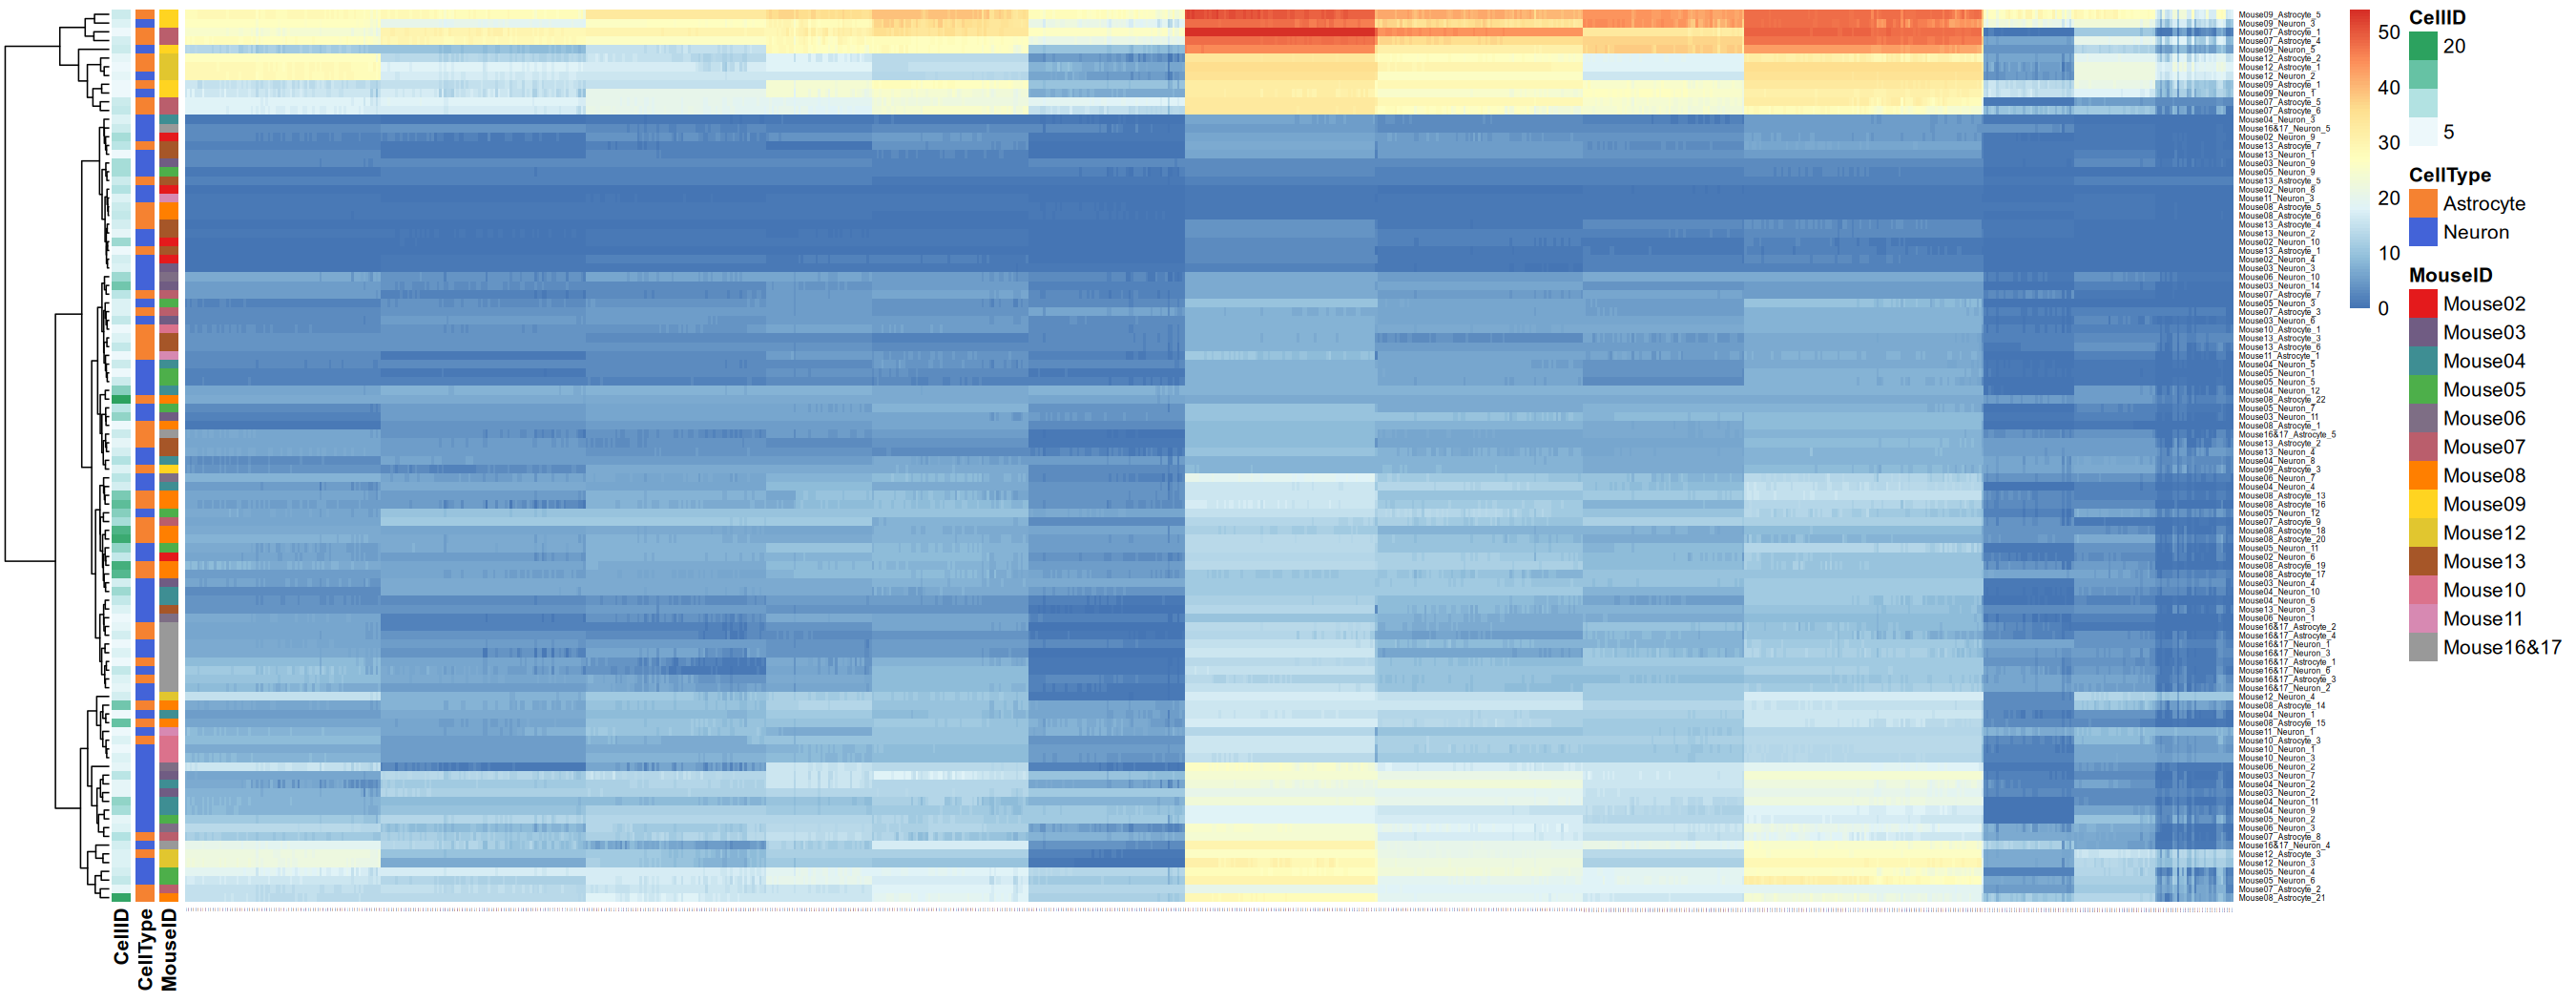

In [37]:
basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_nmitoshasdata_bycell_bypos_df <- as.data.frame(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_nmitoshasdata_bycell_bypos)
rownames(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_nmitoshasdata_bycell_bypos_df) <- basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_nmitoshasdata_bycell_bypos_df[, 1]
basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_nmitoshasdata_bycell_bypos_df <- basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_nmitoshasdata_bycell_bypos_df[, -c(1:7)]

options(repr.plot.height = 7, repr.plot.width = 18, res = 72)
pheatmap(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_nmitoshasdata_bycell_bypos_df, cluster_col = FALSE, cluster_row = TRUE, angle = 90, annotation_row = CellInfo_df[rownames(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_nmitoshasdata_bycell_bypos_df), c("MouseID", "CellType", "CellID")], annotation_color = list(MouseID = structure(colorRampPalette(scales::brewer_pal(palette = "Set1")(9))(length(MouseInfo[, MouseID])), names = MouseInfo[, MouseID]), CellType = c("Astrocyte" = Graphics$palette20[5], "Neuron" = Graphics$palette20[4])), fontsize_col = 1, fontsize_row = 4, show_rownames = TRUE, border_color = NA)

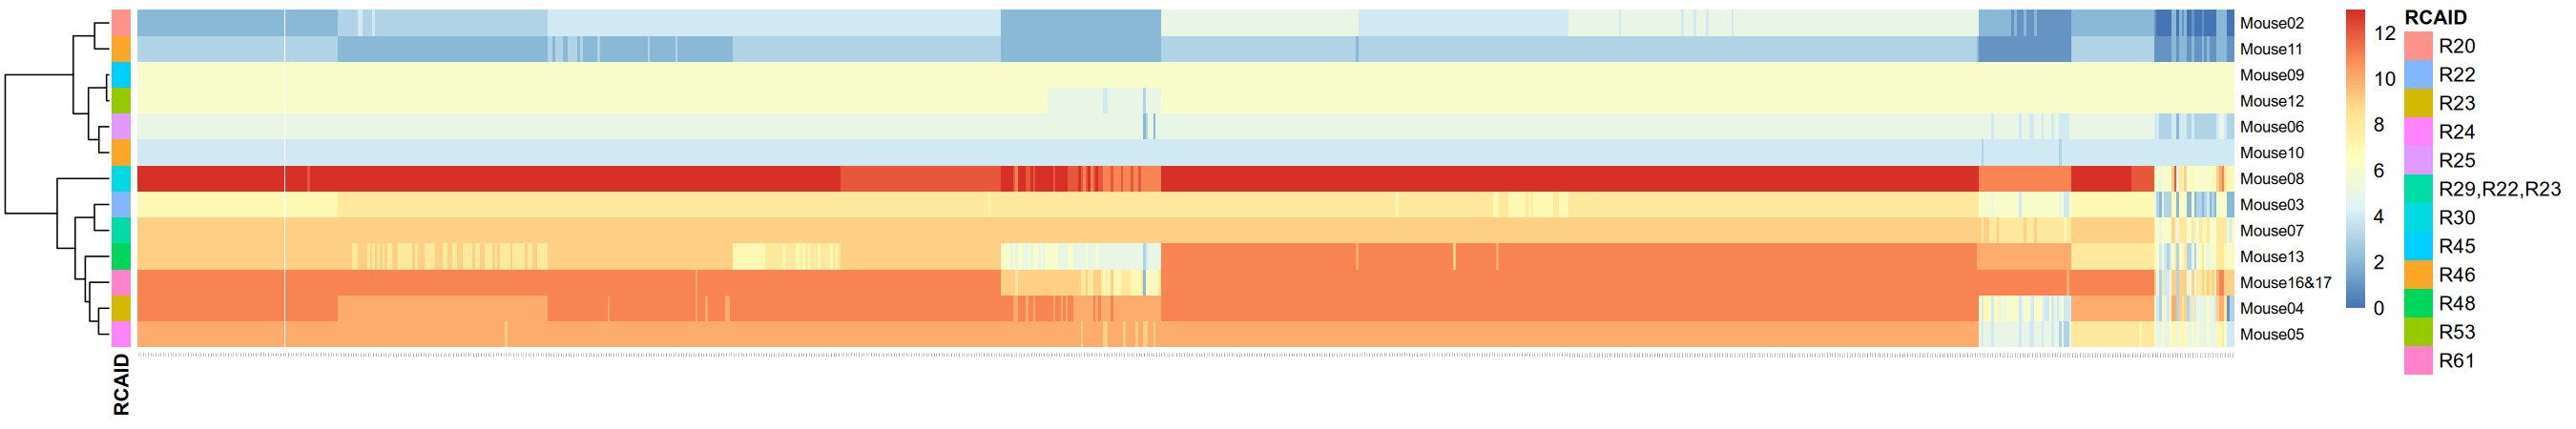

In [38]:
basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_ncellshasdata_bymouse_bypos_df <- as.data.frame(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_ncellshasdata_bymouse_bypos)
rownames(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_ncellshasdata_bymouse_bypos_df) <- basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_ncellshasdata_bymouse_bypos_df[, 1]
basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_ncellshasdata_bymouse_bypos_df <- basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_ncellshasdata_bymouse_bypos_df[, -c(1:2)]

options(repr.plot.height = 3, repr.plot.width = 18, res = 72)
pheatmap(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_ncellshasdata_bymouse_bypos_df, cluster_col = FALSE, cluster_row = TRUE, angle = 90, annotation_row = MouseInfo_df[rownames(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_ncellshasdata_bymouse_bypos_df), c("RCAID"), drop = FALSE], fontsize_col = 1, fontsize_row = 8, show_rownames = TRUE, border_color = NA)

Load VAF filtered data, compute SNV stats per SNV site

In [39]:
basediffperc_cutdemux_q30_unstranded_highdepth_highaf <- fread("Report/SNVs/filter/basediffperc_cutdemux_sub500k_q30_unstranded_highdepth_highaf_qcfltd.csv.gz")
support_byposmut <- fread("Report/SNVs/filter/basediffperc_cutdemux_sub500k_q30_unstranded_highdepth_highaf_qcfltd_support_byposmut.csv")
dim(basediffperc_cutdemux_q30_unstranded_highdepth_highaf)

[1] 7157   29

In [40]:
dim(basediffperc_cutdemux_q30_unstranded_highdepth_highaf[IsCtrl == "N"])

[1] 6763   29

In [41]:
basediffperc_cutdemux_q30_unstranded_highdepth_highaf[IsCtrl == "N", list(N = uniqueN(pos)), by = "LibraryMitoID"][, summary(N)]

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   3.000   4.452   6.000  17.000 

In [42]:
basediffperc_cutdemux_q30_unstranded_highdepth_highaf[IsCtrl == "N", list(N = uniqueN(pos)), by = "LibraryMitoID"][, sd(N)]

[1] 3.464509

In [43]:
basediffperc_cutdemux_q30_unstranded_highdepth_highaf[IsCtrl == "N", list(N = uniqueN(pos)), by = "CellUID"][, summary(N)]

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2.00   15.00   24.50   27.46   36.75   97.00 

In [44]:
basediffperc_cutdemux_q30_unstranded_highdepth_highaf[IsCtrl == "N", list(N = uniqueN(pos)), by = "CellUID"][, sd(N)]

[1] 17.9232

In [45]:
basediffperc_cutdemux_q30_unstranded_highdepth_highaf[IsCtrl == "N", list(N = uniqueN(pos)), by = "MouseID"][, summary(N)]

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   26.0    59.0   151.0   135.8   165.0   263.0 

In [46]:
basediffperc_cutdemux_q30_unstranded_highdepth_highaf[IsCtrl == "N", list(N = uniqueN(pos)), by = "MouseID"][, sd(N)]

[1] 76.49309

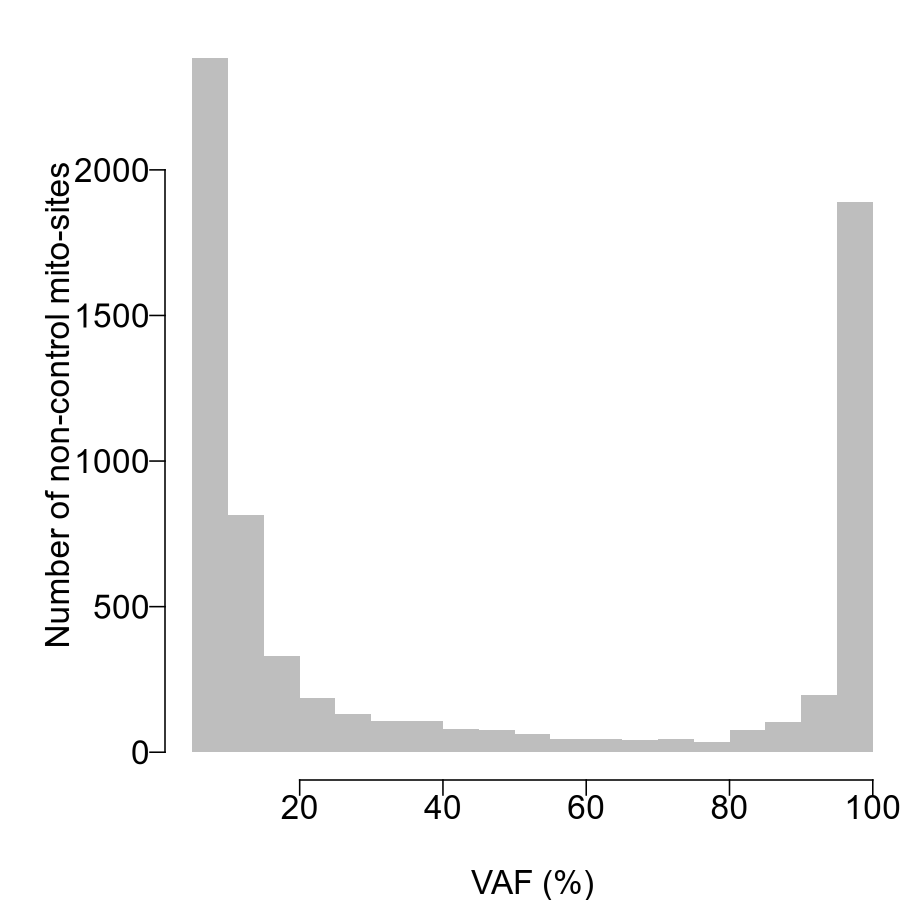

In [47]:
options(repr.plot.height = 6, repr.plot.width = 6, res = 72)
par(ps = 16, las = 1, lend = 2, ljoin = 1, bty = "L", mfrow = c(1, 1), mar = c(4, 5.5, 1, 0), oma = c(0, 0, 0, 0), mgp = c(3, 0.5, 0))
invisible(basediffperc_cutdemux_q30_unstranded_highdepth_highaf[IsCtrl == "N" , hist(100 - `=`, xlab = "VAF (%)", ylab = "Number of non-control mito-sites", main = "", freq = TRUE, col = "gray", border = NA)])

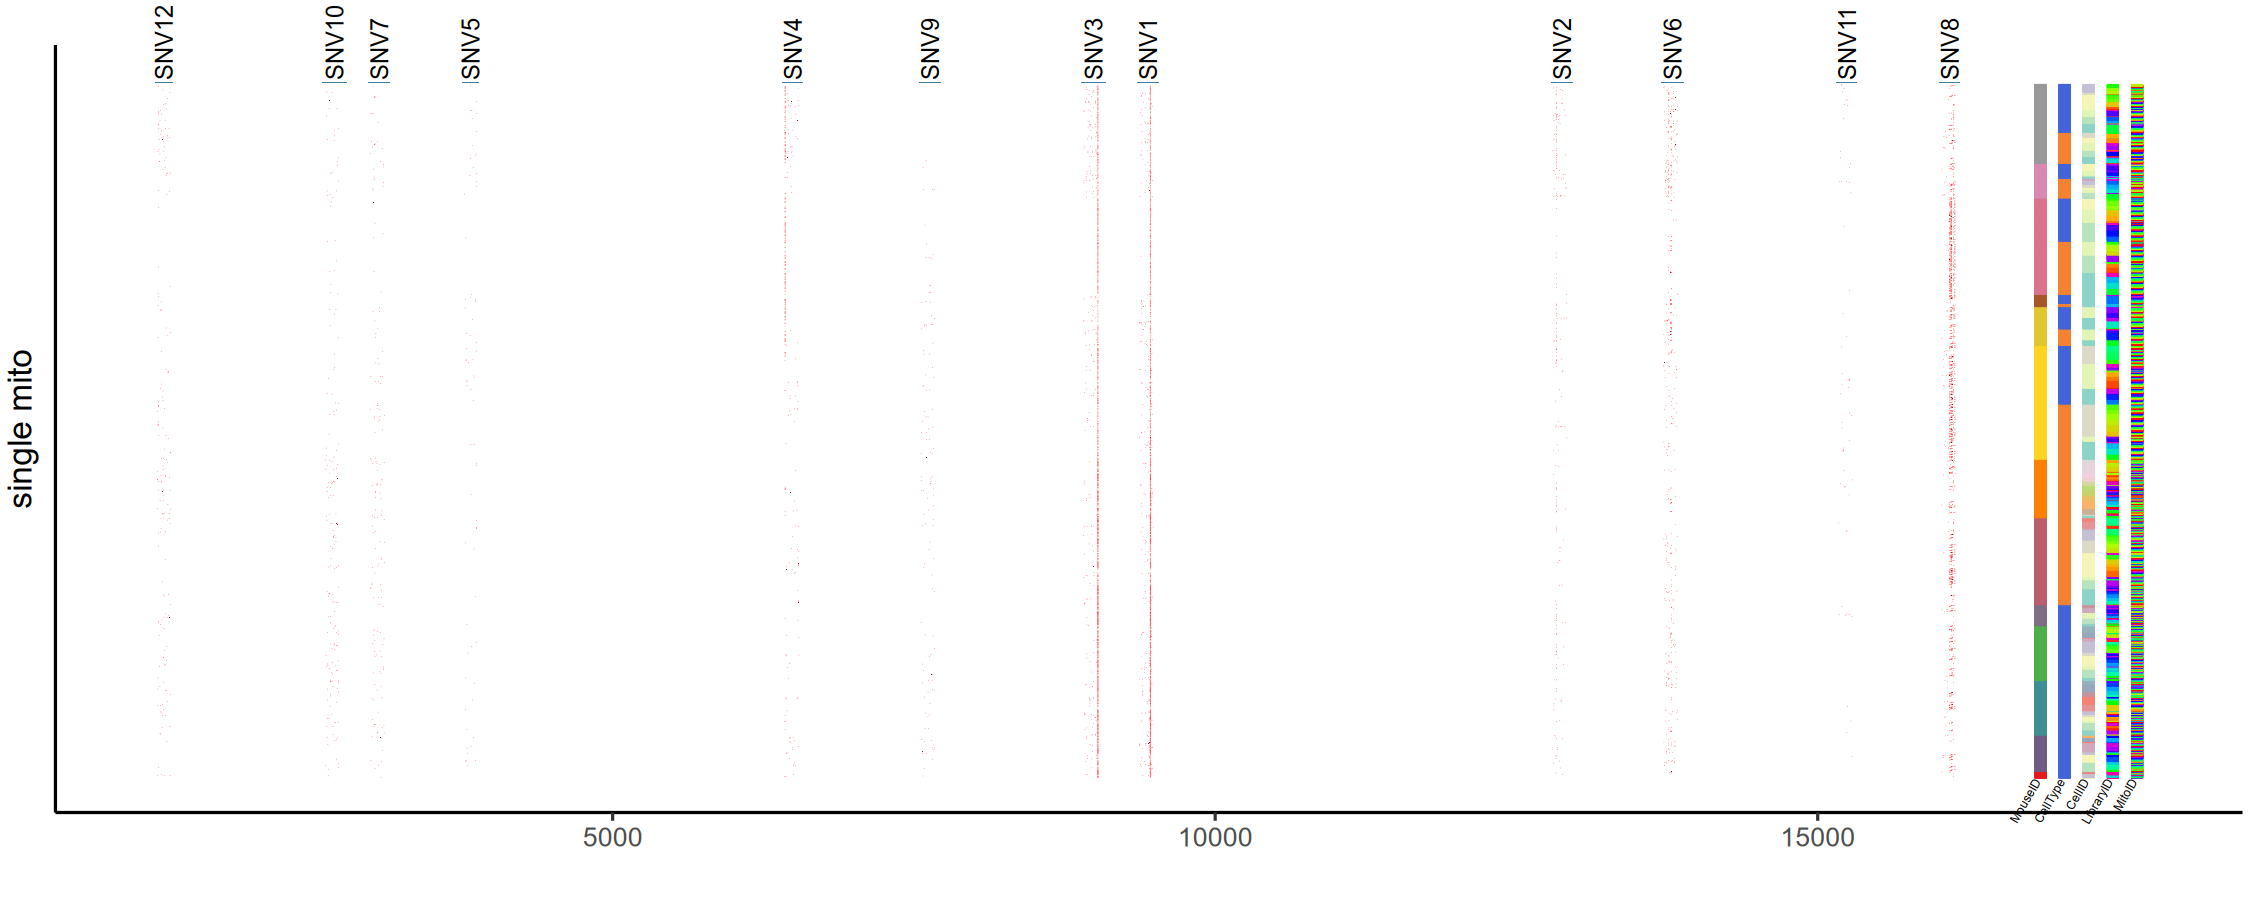

In [48]:
basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl <- basediffperc_cutdemux_q30_unstranded_highdepth_highaf[IsCtrl == "N"][order(MouseID, CellType, CellID, LibraryMitoID)]
n_samples <- nrow(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl)
basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl[, i := seq(n_samples)]
fig <- ggplot(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl, aes(y = i, x = pos)) + geom_tile(color = "red") + theme_classic(base_size = 16) + theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), plot.margin = unit(c(0.3, 0.05, 0.05, 0.05), "in")) + xlab("") + ylab("single mito") + coord_cartesian(clip = "off") + 
    annotate(geom = "rect", xmin = 16800, xmax = 16900, ymin = 1:n_samples, ymax = 1:n_samples, col = colorRampPalette(scales::brewer_pal(palette = "Set1")(9))(length(unique(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl$MouseID)))[factor(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl$MouseID)]) + 
    annotate(geom = "rect", xmin = 17000, xmax = 17100, ymin = 1:n_samples, ymax = 1:n_samples, col = c("Astrocyte" =  Graphics$palette20[5], "Neuron" =  Graphics$palette20[4])[basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl$CellType]) + 
    annotate(geom = "rect", xmin = 17200, xmax = 17300, ymin = 1:n_samples, ymax = 1:n_samples, col = colorRampPalette(scales::brewer_pal(palette = "Set3")(9))(length(unique(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl$CellID)))[factor(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl$CellID)]) + 
    annotate(geom = "rect", xmin = 17400, xmax = 17500, ymin = 1:n_samples, ymax = 1:n_samples, col = colorRampPalette(rainbow(9))(length(unique(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl$LibraryID)))[factor(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl$LibraryID)]) + 
    annotate(geom = "rect", xmin = 17600, xmax = 17700, ymin = 1:n_samples, ymax = 1:n_samples, col = colorRampPalette(rainbow(9))(length(unique(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl$MitoID)))[factor(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl$MitoID)]) + 
    annotate(geom = "rect", xmin = snv_info$Start, xmax = snv_info$End, ymin = n_samples + 30, ymax = n_samples + 15, fill = "#407FA0") + 
    annotate(geom = "text", x = c(16800, 17000, 17200, 17400, 17600), y = 0, label = c("MouseID", "CellType", "CellID", "LibraryID", "MitoID"), size = 2, angle = 60, vjust = 1, hjust = 1) + 
    annotate(geom = "text", x = 0.5 * (snv_info$Start + snv_info$End), y = n_samples + 50, label = snv_info$SNVID, size = 4, angle = 90, hjust = 0)

options(repr.plot.height = 6, repr.plot.width = 15, res = 72)
print(fig)


Circos plot for the support per base position

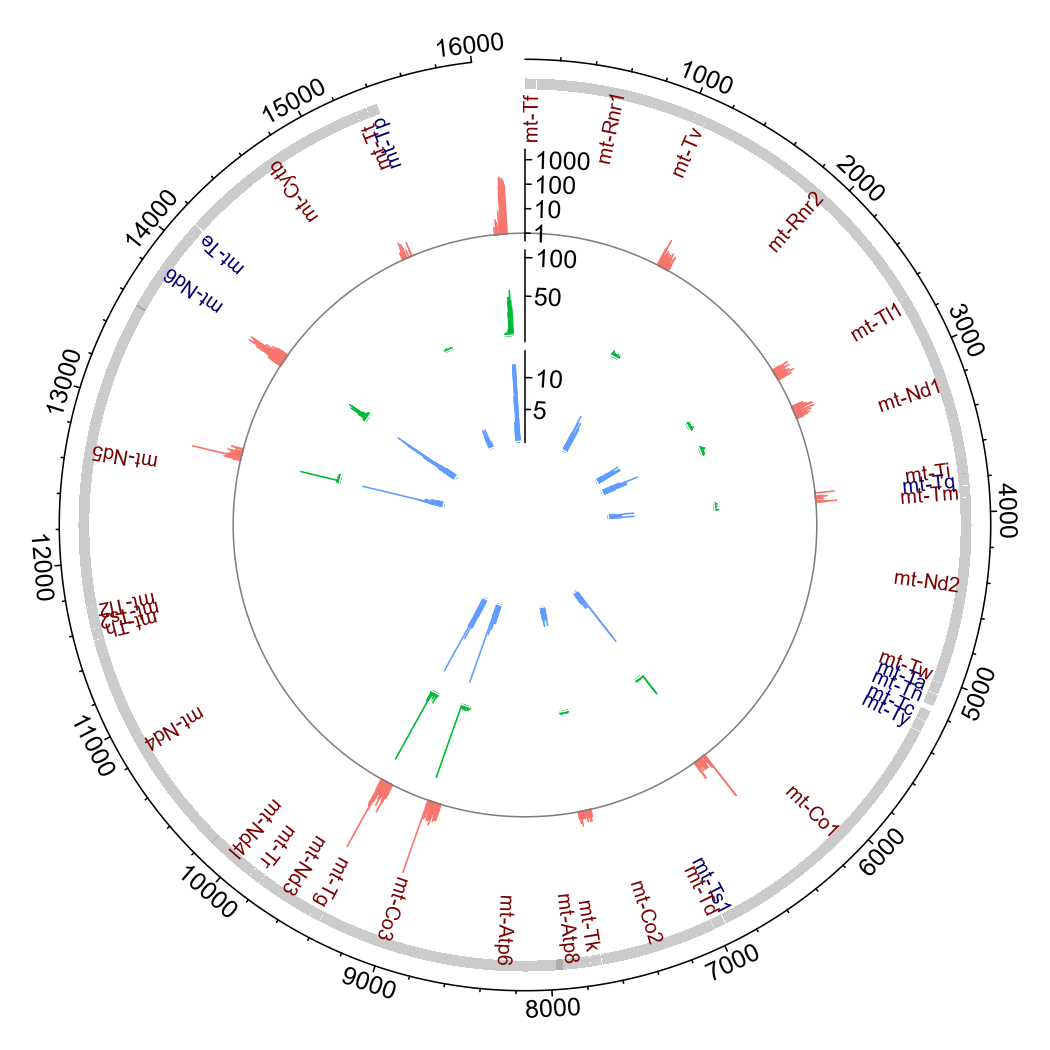

In [49]:
chrmgenes <- fread("Data/mm10.mito/chrM.gtf")
chrmgenes[, symbol := sapply(regmatches(V9, regexec('gene_name "(.*)"', V9, perl = TRUE)), '[', 2)]
chrmgenes <- chrmgenes[, list(symbol, V4, V5, V7)]
colpal <- scales::hue_pal()(3)

options(repr.plot.height = 7, repr.plot.width = 7, res = 72)
circos.clear()
circos.par(start.degree = 90)
circos.initialize(sectors = rep("chrM", 16299), x = 1:16299, ring = TRUE)
circos.track(sectors = rep("chrM", nrow(chrmgenes)), ylim = c(0, 1), panel.fun = function(x, y) { 
    circos.rect(xleft = chrmgenes[, V4], xright = chrmgenes[, V5], ytop = 1, ybottom = 0.8, border = NA, col = ifelse(chrmgenes[, V7] == "+",adjustcolor("grey50", alpha.f = 0.4), adjustcolor("grey50", alpha.f = 0.4)))
    circos.text(x = chrmgenes[, 0.5 * (V4 + V5)], y = 0.25, labels = chrmgenes[, symbol], facing = "clockwise", col = ifelse(chrmgenes[, V7] == "+", Graphics$palette20[15], Graphics$palette20[19]), cex = 0.8)}, 
bg.border = NA, track.height = 0.15)
circos.track(sectors = rep("chrM", nrow(support_byposmut)), x = support_byposmut[, pos], y = support_byposmut[, log10(nmitos)], panel.fun = function(x, y) { circos.barplot(pos = x, value = y, border = colpal[1], col = NA, lwd = 1); circos.lines(y = rep(log10(1), 16299), x = 1:16299, col = "gray50", lty = 1, lwd = 1) }, bg.border = NA)
circos.track(sectors = rep("chrM", nrow(support_byposmut)), x = support_byposmut[, pos], y = support_byposmut[, ncells], panel.fun = function(x, y) { circos.barplot(pos = x, value = y, border = colpal[2], col = NA, lwd = 1); circos.lines(y = rep(0, 16299), x = 1:16299, col = "#FFFFFFFF", lty = 1, lwd = 1) }, bg.border = NA)
circos.track(sectors = rep("chrM", nrow(support_byposmut)), x = support_byposmut[, pos], y = support_byposmut[, nmice], panel.fun = function(x, y) { circos.barplot(pos = x, value = y, border = colpal[3], col = NA, lwd = 1); circos.lines(y = rep(0, 16299), x = 1:16299, col = "#FFFFFFFF", lty = 1, lwd = 1) }, bg.border = NA)
circos.xaxis(major.at = seq(0, 16299, by = 1000), h = 60)
circos.yaxis(at = c(0, 1, 2, 3), side = "right", track.index = 2, labels = c("1", "10", "100", "1000"))
circos.yaxis(at = c(0, 50, 100), side = "right", track.index = 3, labels = c("0", "50", "100"))
circos.yaxis(at = c(0, 5, 10), side = "right", track.index = 4, labels = c("0", "5", "10"))

Number of SNV sites per mito/cell/mouse

In [50]:
basediffperc_cutdemux_q30_unstranded_highdepth_highaf <- fread("Report/SNVs/filter/basediffperc_cutdemux_sub500k_q30_unstranded_highdepth_highaf_qcfltd.csv.gz", header = TRUE)
basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_npos_bymito <- basediffperc_cutdemux_q30_unstranded_highdepth_highaf[IsCtrl == "N", .(npos = uniqueN(pos)), by = "LibraryMitoID"]
basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_npos_bymito <- merge.data.table(MitoInfo[IsCtrl == "N"], basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_npos_bymito, by = "LibraryMitoID", all.x = TRUE)
basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_npos_bymito[, MitoID := factor(MitoID, levels = mitoIDs)]
basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_npos_bymito[, CellID := factor(CellID)]
basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_npos_bymito[, ExptID := factor(ExptID)]
basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_npos_bymito[, npos := ifelse(is.na(npos), 0, npos)]
head(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_npos_bymito)

LibraryMitoID LibraryID ExptID IsolationRCADate DIVDays CellType PlateID
1 DepSeq-L1_M1  DepSeq-L1 799    2020-08-28       3       Neuron   1      
2 DepSeq-L1_M2  DepSeq-L1 799    2020-08-28       3       Neuron   1      
3 DepSeq-L1_M3  DepSeq-L1 799    2020-08-28       3       Neuron   2      
4 DepSeq-L1_M4  DepSeq-L1 799    2020-08-14       3       Neuron   1      
5 DepSeq-L1_M6  DepSeq-L1 799    2020-08-14       3       Neuron   2      
6 DepSeq-L1_M7  DepSeq-L1 799    2020-09-15       3       Neuron   1      
  CellID CellUID          WellMitoBarcode WellID MitoID HasMtDNA HasPrimers
1 3      Mouse04_Neuron_3 D11--M1         D11    M1     Y        Y         
2 6      Mouse04_Neuron_6 E12--M2         E12    M2     Y        Y         
3 5      Mouse04_Neuron_5 E11--M3         E11    M3     Y        Y         
4 6      Mouse02_Neuron_6 D5--M4          D5     M4     Y        Y         
5 9      Mouse02_Neuron_9 B5--M6          B5     M6     Y        Y         
6 1      Mouse06_Neuron_1 A5--M7          A5     M7     Y        Y         
  RCAID MouseID Enzyme HasRCA IsCtrl npos
1 R23   Mouse04 None   Y      N      8   
2 R23   Mouse04 None   Y      N      6   
3 R23   Mouse04 None   Y      N      4   
4 R20   Mouse02 None   Y      N      5   
5 R20   Mouse02 None   Y      N      1   
6 R25   Mouse06 None   Y      N      5

In [ ]:
fwrite(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_npos_bymito, file = "Report/SNVs/QC/highdepth_highaf_noctrl_npos_bymito.csv")

In [52]:
basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_npos_bycell <- basediffperc_cutdemux_q30_unstranded_highdepth_highaf[IsCtrl == "N", .(npos = uniqueN(pos)), by = "CellUID"]
basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_npos_bycell <- merge.data.table(CellInfo, basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_npos_bycell, by = "CellUID", all.x = TRUE)
head(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_npos_bycell)

CellUID           IsolationRCADate DIVDays CellType CellID RCAID MouseID npos
1 Mouse02_Neuron_10 2020-08-14       3       Neuron   10     R20   Mouse02  2  
2 Mouse02_Neuron_4  2020-08-14       3       Neuron    4     R20   Mouse02  3  
3 Mouse02_Neuron_6  2020-08-14       3       Neuron    6     R20   Mouse02 18  
4 Mouse02_Neuron_8  2020-08-14       3       Neuron    8     R20   Mouse02  2  
5 Mouse02_Neuron_9  2020-08-14       3       Neuron    9     R20   Mouse02  8  
6 Mouse03_Neuron_11 2020-08-21       3       Neuron   11     R22   Mouse03 18

In [ ]:
fwrite(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_npos_bycell, file = "Report/SNVs/QC/highdepth_highaf_noctrl_npos_bycell.csv")

In [54]:
basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_npos_bymouse <- basediffperc_cutdemux_q30_unstranded_highdepth_highaf[IsCtrl == "N", .(npos = uniqueN(pos)), by = "MouseID"]
basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_npos_bymouse <- merge.data.table(MouseInfo, basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_npos_bymouse, by = "MouseID", all.x = TRUE)
head(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_npos_bymouse)

MouseID RCAID       npos
1 Mouse02 R20          26 
2 Mouse03 R22         130 
3 Mouse04 R23         165 
4 Mouse05 R24         151 
5 Mouse06 R25          50 
6 Mouse07 R29,R22,R23 191

In [ ]:
fwrite(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_npos_bymouse, file = "Report/SNVs/QC/highdepth_highaf_noctrl_npos_bymouse.csv")

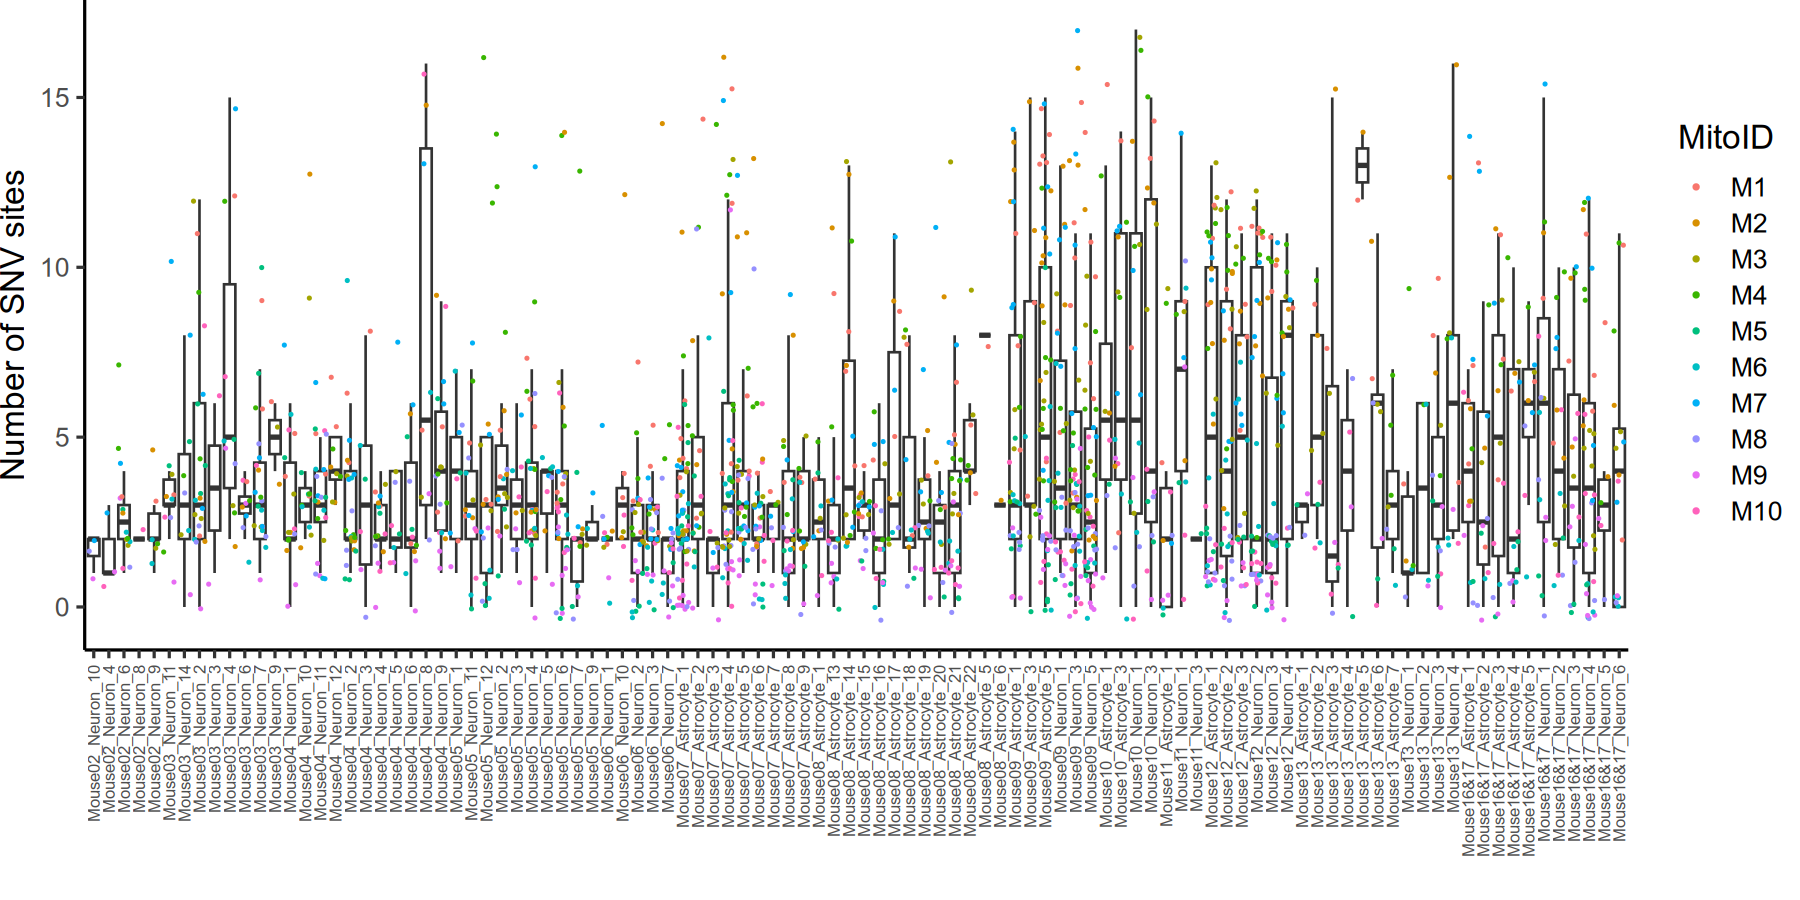

In [56]:
fig <- ggplot(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_npos_bymito[IsCtrl == "N"], aes(x = CellUID, y = npos)) + geom_boxplot(size = 0.6, outlier.color = NA) + geom_jitter(size = 0.5, aes(color = MitoID)) + theme_classic(base_size = 16) + theme(plot.margin = unit(c(0.0, 0.00, 0.00, 0.00), "in"), axis.text.x = element_text(size = 8, angle = 90, vjust = 0.5, hjust = 1)) + guides(color = guide_legend(override.aes = list(size = 1))) + xlab("") + ylab("Number of SNV sites")
options(repr.plot.height = 6, repr.plot.width = 12, res = 72)
print(fig)

Binary table: whether nonmissing data in mito/cell/mouse X at SNV Y

In [57]:
support_byposmut <- fread("Report/SNVs/filter/basediffperc_cutdemux_sub500k_q30_unstranded_highdepth_highaf_qcfltd_support_byposmut.csv")
basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bymito_bypos <- fread(file = "Report/SNVs/QC/highdepth_noctrl_hasdata_bymito_bypos.csv.gz", header = TRUE)
basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bycell_bypos <- fread(file = "Report/SNVs/QC/highdepth_noctrl_hasdata_bycell_bypos.csv.gz", header = TRUE)
basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bymouse_bypos <- fread(file = "Report/SNVs/QC/highdepth_noctrl_hasdata_bymouse_bypos.csv.gz", header = TRUE)

In [58]:
basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bymito_byposmut <- data.table(
    basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bymito_bypos[, 1:19], 
    basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bymito_bypos[, match(support_byposmut[, pos], names(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bymito_bypos)), with = FALSE]
)
names(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bymito_byposmut)[-c(1:19)] <- support_byposmut[, posmut]
head(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bymito_byposmut)

LibraryMitoID LibraryID ExptID IsolationRCADate DIVDays CellType PlateID
1 DepSeq-L1_M1  DepSeq-L1 799    2020-08-28       3       Neuron   1      
2 DepSeq-L1_M2  DepSeq-L1 799    2020-08-28       3       Neuron   1      
3 DepSeq-L1_M3  DepSeq-L1 799    2020-08-28       3       Neuron   2      
4 DepSeq-L1_M4  DepSeq-L1 799    2020-08-14       3       Neuron   1      
5 DepSeq-L1_M6  DepSeq-L1 799    2020-08-14       3       Neuron   2      
6 DepSeq-L1_M7  DepSeq-L1 799    2020-09-15       3       Neuron   1      
  CellID CellUID          WellMitoBarcode ⋯ 16124:C>G 16125:A>C 16125:A>G
1 3      Mouse04_Neuron_3 D11--M1         ⋯ 0         0         0        
2 6      Mouse04_Neuron_6 E12--M2         ⋯ 0         0         0        
3 5      Mouse04_Neuron_5 E11--M3         ⋯ 0         0         0        
4 6      Mouse02_Neuron_6 D5--M4          ⋯ 1         1         1        
5 9      Mouse02_Neuron_9 B5--M6          ⋯ 0         0         0        
6 1      Mouse06_Neuron_1 A5--M7          ⋯ 0         0         0        
  16125:A>del 16133:T>A 16133:T>C 16133:T>G 16140:T>A 16140:T>C 16141:T>C
1 0           0         0         0         0         0         0        
2 0           0         0         0         0         0         0        
3 0           0         0         0         0         0         0        
4 1           0         0         0         0         0         0        
5 0           0         0         0         0         0         0        
6 0           0         0         0         0         0         0

In [ ]:
fwrite(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bymito_byposmut, file = "Report/SNVs/QC/highdepth_noctrl_hasdata_bymito_byposmut.csv.gz")

In [60]:
basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bycell_byposmut <- data.table(
    basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bycell_bypos[, 1:7], 
    basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bycell_bypos[, match(support_byposmut[, pos], names(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bycell_bypos)), with = FALSE]
)
names(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bycell_byposmut)[-c(1:7)] <- support_byposmut[, posmut]
head(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bycell_byposmut)

CellUID           IsolationRCADate DIVDays CellType CellID RCAID MouseID
1 Mouse02_Neuron_10 2020-08-14       3       Neuron   10     R20   Mouse02
2 Mouse02_Neuron_4  2020-08-14       3       Neuron    4     R20   Mouse02
3 Mouse02_Neuron_6  2020-08-14       3       Neuron    6     R20   Mouse02
4 Mouse02_Neuron_8  2020-08-14       3       Neuron    8     R20   Mouse02
5 Mouse02_Neuron_9  2020-08-14       3       Neuron    9     R20   Mouse02
6 Mouse03_Neuron_11 2020-08-21       3       Neuron   11     R22   Mouse03
  1224:A>G 1224:A>T 1225:G>A ⋯ 16124:C>G 16125:A>C 16125:A>G 16125:A>del
1 0        0        0        ⋯ 0         0         0         0          
2 0        0        0        ⋯ 0         0         0         0          
3 1        1        1        ⋯ 1         1         1         1          
4 0        0        0        ⋯ 0         0         0         0          
5 1        1        1        ⋯ 1         1         1         1          
6 1        1        1        ⋯ 1         1         1         1          
  16133:T>A 16133:T>C 16133:T>G 16140:T>A 16140:T>C 16141:T>C
1 0         0         0         0         0         0        
2 0         0         0         0         0         0        
3 0         0         0         0         0         0        
4 0         0         0         0         0         0        
5 0         0         0         0         0         0        
6 0         0         0         0         0         0

In [ ]:
fwrite(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bycell_byposmut, file = "Report/SNVs/QC/highdepth_noctrl_hasdata_bycell_byposmut.csv.gz")

In [62]:
basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bymouse_byposmut <- data.table(
    basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bymouse_bypos[, 1:2], 
    basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bymouse_bypos[, match(support_byposmut[, pos], names(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bymouse_bypos)), with = FALSE]
)
names(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bymouse_byposmut)[-c(1:2)] <- support_byposmut[, posmut]
head(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bymouse_byposmut)

MouseID RCAID       1224:A>G 1224:A>T 1225:G>A 1226:A>G 1228:G>A 1228:G>T
1 Mouse02 R20         1        1        1        1        1        1       
2 Mouse03 R22         1        1        1        1        1        1       
3 Mouse04 R23         1        1        1        1        1        1       
4 Mouse05 R24         1        1        1        1        1        1       
5 Mouse06 R25         1        1        1        1        1        1       
6 Mouse07 R29,R22,R23 1        1        1        1        1        1       
  1229:A>G 1230:A>G ⋯ 16124:C>G 16125:A>C 16125:A>G 16125:A>del 16133:T>A
1 1        1        ⋯ 1         1         1         1           0        
2 1        1        ⋯ 1         1         1         1           1        
3 1        1        ⋯ 1         1         1         1           1        
4 1        1        ⋯ 1         1         1         1           1        
5 1        1        ⋯ 1         1         1         1           1        
6 1        1        ⋯ 1         1         1         1           1        
  16133:T>C 16133:T>G 16140:T>A 16140:T>C 16141:T>C
1 0         0         0         0         0        
2 1         1         1         1         1        
3 1         1         1         1         1        
4 1         1         1         1         1        
5 1         1         1         1         1        
6 1         1         1         1         1

In [ ]:
fwrite(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bymouse_byposmut, file = "Report/SNVs/QC/highdepth_noctrl_hasdata_bymouse_byposmut.csv.gz")

Per SNV, how many mitos/cells/mice have non-missing data?

In [64]:
basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bymito_byposmut <- fread(file = "Report/SNVs/QC/highdepth_noctrl_hasdata_bymito_byposmut.csv.gz", header = TRUE)
basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bycell_byposmut <- fread(file = "Report/SNVs/QC/highdepth_noctrl_hasdata_bycell_byposmut.csv.gz", header = TRUE)
basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bymouse_byposmut <- fread(file = "Report/SNVs/QC/highdepth_noctrl_hasdata_bymouse_byposmut.csv.gz", header = TRUE)

basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_nsampleshasdata_byposmut <- data.table(
    posmut = support_byposmut[, posmut], 
    nmitoshasdata = colSums(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bymito_byposmut[, support_byposmut[, posmut], with = FALSE], na.rm = TRUE), 
    ncellshasdata = colSums(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bycell_byposmut[, support_byposmut[, posmut], with = FALSE], na.rm = TRUE), 
    nmicehasdata = colSums(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_hasdata_bymouse_byposmut[, support_byposmut[, posmut], with = FALSE], na.rm = TRUE)
)
head(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_nsampleshasdata_byposmut)


posmut   nmitoshasdata ncellshasdata nmicehasdata
1 1224:A>G 842           96            13          
2 1224:A>T 842           96            13          
3 1225:G>A 854           96            13          
4 1226:A>G 842           96            13          
5 1228:G>A 848           96            13          
6 1228:G>T 848           96            13

In [ ]:
fwrite(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_nsampleshasdata_byposmut, file = "Report/SNVs/QC/highdepth_noctrl_nsampleshasdata_byposmut.csv")

Binary table: whether mito/cell/mouse X carries SNV Y?

In [66]:
support_byposmut <- fread(file = "Report/SNVs/filter/basediffperc_cutdemux_sub500k_q30_unstranded_highdepth_highaf_qcfltd_support_byposmut.csv")
basediffperc_cutdemux_q30_unstranded_highdepth_highaf <- fread("Report/SNVs/filter/basediffperc_cutdemux_sub500k_q30_unstranded_highdepth_highaf_qcfltd.csv.gz")
basediffperc_cutdemux_q30_unstranded_highdepth_highaf[ref == "A", A := `=`]
basediffperc_cutdemux_q30_unstranded_highdepth_highaf[ref == "C", C := `=`]
basediffperc_cutdemux_q30_unstranded_highdepth_highaf[ref == "G", G := `=`]
basediffperc_cutdemux_q30_unstranded_highdepth_highaf[ref == "T", T := `=`]
basediffperc_cutdemux_q30_unstranded_highdepth_highaf <- melt.data.table(basediffperc_cutdemux_q30_unstranded_highdepth_highaf, measure.vars = c("A", "C", "G", "T", "del"), variable.name = "alt", value.name = "altperc")
setnames(basediffperc_cutdemux_q30_unstranded_highdepth_highaf, "=", "refperc")
basediffperc_cutdemux_q30_unstranded_highdepth_highaf[, alt := factor(alt, levels = c("A", "C", "G", "T", "del"))]
basediffperc_cutdemux_q30_unstranded_highdepth_highaf[, mut := factor(paste0(ref, ">", alt), levels = paste0(rep(c("A", "C", "G", "T"), each = 5), ">", c("A", "C", "G", "T", "del")))]
setkey(basediffperc_cutdemux_q30_unstranded_highdepth_highaf, pos, alt)
basediffperc_cutdemux_q30_unstranded_highdepth_highaf[, posmut := paste0(pos, ":", mut)]
basediffperc_cutdemux_q30_unstranded_highdepth_highaf[, posmut := factor(posmut, levels = unique(posmut))]
dim(basediffperc_cutdemux_q30_unstranded_highdepth_highaf)


[1] 35785    28

In [67]:
head(basediffperc_cutdemux_q30_unstranded_highdepth_highaf)

LibraryID ExptID LibraryMitoID IsolationRCADate DIVDays CellType  PlateID
1 L4R23P2B  731    L4R23P2B_M1   2020-08-28       3       Neuron    2      
2 L7R30P1B  732    L7R30P1B_M10  2021-02-12       3       Astrocyte 1      
3 L3R20R23B 733    L3R20R23B_M4  2020-08-14       3       Neuron    1      
4 DepSeq-L3 799    DepSeq-L3_M2  2021-02-12       3       Astrocyte 2      
5 DepSeq-L3 799    DepSeq-L3_M3  2021-02-12       3       Astrocyte 2      
6 DepSeq-L3 799    DepSeq-L3_M4  2021-02-12       3       Astrocyte 2      
  CellID CellUID              WellMitoBarcode ⋯ IsCtrl SNVID pos  ref depth
1 11     Mouse04_Neuron_11    D1--M1          ⋯ N      SNV12 1224 A    577 
2 13     Mouse08_Astrocyte_13 B11--M10        ⋯ N      SNV12 1224 A     67 
3  6     Mouse02_Neuron_6     C2--M4/R20      ⋯ N      SNV12 1224 A   3065 
4 19     Mouse08_Astrocyte_19 C5--M2          ⋯ N      SNV12 1224 A    521 
5 19     Mouse08_Astrocyte_19 D5--M3          ⋯ N      SNV12 1224 A     50 
6 21     Mouse08_Astrocyte_21 E5--M4          ⋯ N      SNV12 1224 A     54 
  refperc  alt altperc  mut posmut  
1 91.68111 A   91.68111 A>A 1224:A>A
2 92.53731 A   92.53731 A>A 1224:A>A
3 94.48613 A   94.48613 A>A 1224:A>A
4 56.81382 A   56.81382 A>A 1224:A>A
5 86.00000 A   86.00000 A>A 1224:A>A
6 88.88889 A   88.88889 A>A 1224:A>A

In [68]:
vaf_th <- 0.05
basediffperc_cutdemux_q30_unstranded_highdepth_highaf <- basediffperc_cutdemux_q30_unstranded_highdepth_highaf[altperc >= vaf_th * 100]
basediffperc_cutdemux_q30_unstranded_highdepth_highaf <- basediffperc_cutdemux_q30_unstranded_highdepth_highaf[ref != alt]
dim(basediffperc_cutdemux_q30_unstranded_highdepth_highaf)

[1] 7270   28

In [69]:
head(basediffperc_cutdemux_q30_unstranded_highdepth_highaf)

LibraryID ExptID LibraryMitoID IsolationRCADate DIVDays CellType  PlateID
1 L4R23P2B  731    L4R23P2B_M1   2020-08-28       3       Neuron    2      
2 L7R30P1B  732    L7R30P1B_M10  2021-02-12       3       Astrocyte 1      
3 L3R20R23B 733    L3R20R23B_M4  2020-08-14       3       Neuron    1      
4 DepSeq-L3 799    DepSeq-L3_M2  2021-02-12       3       Astrocyte 2      
5 DepSeq-L3 799    DepSeq-L3_M4  2021-02-12       3       Astrocyte 2      
6 DepSeq-L3 799    DepSeq-L3_M2  2021-02-12       3       Astrocyte 2      
  CellID CellUID              WellMitoBarcode ⋯ IsCtrl SNVID pos  ref depth
1 11     Mouse04_Neuron_11    D1--M1          ⋯ N      SNV12 1224 A    577 
2 13     Mouse08_Astrocyte_13 B11--M10        ⋯ N      SNV12 1224 A     67 
3  6     Mouse02_Neuron_6     C2--M4/R20      ⋯ N      SNV12 1224 A   3065 
4 19     Mouse08_Astrocyte_19 C5--M2          ⋯ N      SNV12 1224 A    521 
5 21     Mouse08_Astrocyte_21 E5--M4          ⋯ N      SNV12 1224 A     54 
6 19     Mouse08_Astrocyte_19 C5--M2          ⋯ N      SNV12 1224 A    521 
  refperc  alt altperc   mut posmut  
1 91.68111 G    8.145581 A>G 1224:A>G
2 92.53731 G    7.462687 A>G 1224:A>G
3 94.48613 G    5.513866 A>G 1224:A>G
4 56.81382 G   12.092131 A>G 1224:A>G
5 88.88889 G    5.555556 A>G 1224:A>G
6 56.81382 T   31.094050 A>T 1224:A>T

In [70]:
basediffperc_cutdemux_q30_unstranded_highdepth_highaf[, setdiff(posmut, support_byposmut[, posmut])]
## [1] "1267:C>T"  "1273:C>G"  "3846:G>A"  "15197:C>G"
## These extra SNVs are unique to the control samples, so they don't appear in the 1032 total.

[1] "1267:C>T"  "1273:C>G"  "3846:G>A"  "15197:C>G"

In [71]:
str(basediffperc_cutdemux_q30_unstranded_highdepth_highaf[IsCtrl == "N", setdiff(posmut, support_byposmut[, posmut])])
## character(0)

 chr(0) 


In [72]:
basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_hassnv_bymito_byposmut <- dcast.data.table(basediffperc_cutdemux_q30_unstranded_highdepth_highaf[IsCtrl == "N"],  LibraryMitoID ~ posmut, value.var = "alt", fun.aggregate = uniqueN)
basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_hassnv_bymito_byposmut <- MitoInfo[basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_hassnv_bymito_byposmut, on = "LibraryMitoID"]
head(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_hassnv_bymito_byposmut)

LibraryID ExptID LibraryMitoID IsolationRCADate DIVDays CellType PlateID
1 DepSeq-L1 799    DepSeq-L1_M1  2020-08-28       3       Neuron   1      
2 DepSeq-L1 799    DepSeq-L1_M2  2020-08-28       3       Neuron   1      
3 DepSeq-L1 799    DepSeq-L1_M3  2020-08-28       3       Neuron   2      
4 DepSeq-L1 799    DepSeq-L1_M4  2020-08-14       3       Neuron   1      
5 DepSeq-L1 799    DepSeq-L1_M6  2020-08-14       3       Neuron   2      
6 DepSeq-L1 799    DepSeq-L1_M7  2020-09-15       3       Neuron   1      
  CellID CellUID          WellMitoBarcode ⋯ 16124:C>G 16125:A>C 16125:A>G
1 3      Mouse04_Neuron_3 D11--M1         ⋯ 0         0         0        
2 6      Mouse04_Neuron_6 E12--M2         ⋯ 0         0         0        
3 5      Mouse04_Neuron_5 E11--M3         ⋯ 0         0         0        
4 6      Mouse02_Neuron_6 D5--M4          ⋯ 0         0         1        
5 9      Mouse02_Neuron_9 B5--M6          ⋯ 0         0         0        
6 1      Mouse06_Neuron_1 A5--M7          ⋯ 0         0         0        
  16125:A>del 16133:T>A 16133:T>C 16133:T>G 16140:T>A 16140:T>C 16141:T>C
1 0           0         0         0         0         0         0        
2 0           0         0         0         0         0         0        
3 0           0         0         0         0         0         0        
4 0           0         0         0         0         0         0        
5 0           0         0         0         0         0         0        
6 0           0         0         0         0         0         0

In [ ]:
fwrite(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_hassnv_bymito_byposmut, file = "Report/SNVs/QC/highdepth_highaf_noctrl_hassnv_bymito_byposmut.csv.gz")

In [74]:
basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_hassnv_bycell_byposmut <- dcast.data.table(basediffperc_cutdemux_q30_unstranded_highdepth_highaf[IsCtrl == "N"], CellUID ~ posmut, value.var = "alt", fun.aggregate = uniqueN)
basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_hassnv_bycell_byposmut <- CellInfo[basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_hassnv_bycell_byposmut, on = "CellUID"]
head(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_hassnv_bycell_byposmut)

CellUID           IsolationRCADate DIVDays CellType CellID RCAID MouseID
1 Mouse02_Neuron_10 2020-08-14       3       Neuron   10     R20   Mouse02
2 Mouse02_Neuron_4  2020-08-14       3       Neuron    4     R20   Mouse02
3 Mouse02_Neuron_6  2020-08-14       3       Neuron    6     R20   Mouse02
4 Mouse02_Neuron_8  2020-08-14       3       Neuron    8     R20   Mouse02
5 Mouse02_Neuron_9  2020-08-14       3       Neuron    9     R20   Mouse02
6 Mouse03_Neuron_11 2020-08-21       3       Neuron   11     R22   Mouse03
  1224:A>G 1224:A>T 1225:G>A ⋯ 16124:C>G 16125:A>C 16125:A>G 16125:A>del
1 0        0        0        ⋯ 0         0         0         0          
2 0        0        0        ⋯ 0         0         0         0          
3 1        0        0        ⋯ 0         1         1         0          
4 0        0        0        ⋯ 0         0         0         0          
5 0        0        0        ⋯ 0         0         0         0          
6 0        0        0        ⋯ 0         0         0         1          
  16133:T>A 16133:T>C 16133:T>G 16140:T>A 16140:T>C 16141:T>C
1 0         0         0         0         0         0        
2 0         0         0         0         0         0        
3 0         0         0         0         0         0        
4 0         0         0         0         0         0        
5 0         0         0         0         0         0        
6 0         0         0         0         0         0

In [ ]:
fwrite(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_hassnv_bycell_byposmut, file = "Report/SNVs/QC/highdepth_highaf_noctrl_hassnv_bycell_byposmut.csv.gz")

In [76]:
basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_hassnv_bymouse_byposmut <- dcast.data.table(basediffperc_cutdemux_q30_unstranded_highdepth_highaf[IsCtrl == "N"], MouseID ~ posmut, value.var = "alt", fun.aggregate = uniqueN)
basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_hassnv_bymouse_byposmut <- MouseInfo[basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_hassnv_bymouse_byposmut, on = "MouseID"]
head(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_hassnv_bymouse_byposmut)

MouseID RCAID       1224:A>G 1224:A>T 1225:G>A 1226:A>G 1228:G>A 1228:G>T
1 Mouse02 R20         1        0        0        0        0        0       
2 Mouse03 R22         0        0        0        0        0        0       
3 Mouse04 R23         1        0        1        0        0        0       
4 Mouse05 R24         0        0        0        1        0        0       
5 Mouse06 R25         0        0        0        0        0        0       
6 Mouse07 R29,R22,R23 0        0        0        0        0        0       
  1229:A>G 1230:A>G ⋯ 16124:C>G 16125:A>C 16125:A>G 16125:A>del 16133:T>A
1 0        0        ⋯ 0         1         1         0           0        
2 0        0        ⋯ 0         0         0         1           1        
3 0        0        ⋯ 0         0         1         0           1        
4 0        0        ⋯ 1         1         1         0           1        
5 0        0        ⋯ 0         1         1         0           1        
6 0        0        ⋯ 1         1         1         0           1        
  16133:T>C 16133:T>G 16140:T>A 16140:T>C 16141:T>C
1 0         0         0         0         0        
2 0         1         1         0         0        
3 0         1         1         0         0        
4 0         1         1         0         0        
5 0         1         1         0         0        
6 0         1         1         0         0

In [ ]:
fwrite(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_hassnv_bymouse_byposmut, file = "Report/SNVs/QC/highdepth_highaf_noctrl_hassnv_bymouse_byposmut.csv.gz")

For each SNV, how many mitos carry it per cell, how many cells carry it per mouse?

In [78]:
basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nmitoshassnv_bycell_byposmut <- dcast.data.table(basediffperc_cutdemux_q30_unstranded_highdepth_highaf[IsCtrl == "N"], CellUID ~ posmut, value.var = "LibraryMitoID", fun.aggregate = uniqueN)
basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nmitoshassnv_bycell_byposmut <- CellInfo[basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nmitoshassnv_bycell_byposmut, on = "CellUID"]
head(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nmitoshassnv_bycell_byposmut)

CellUID           IsolationRCADate DIVDays CellType CellID RCAID MouseID
1 Mouse02_Neuron_10 2020-08-14       3       Neuron   10     R20   Mouse02
2 Mouse02_Neuron_4  2020-08-14       3       Neuron    4     R20   Mouse02
3 Mouse02_Neuron_6  2020-08-14       3       Neuron    6     R20   Mouse02
4 Mouse02_Neuron_8  2020-08-14       3       Neuron    8     R20   Mouse02
5 Mouse02_Neuron_9  2020-08-14       3       Neuron    9     R20   Mouse02
6 Mouse03_Neuron_11 2020-08-21       3       Neuron   11     R22   Mouse03
  1224:A>G 1224:A>T 1225:G>A ⋯ 16124:C>G 16125:A>C 16125:A>G 16125:A>del
1 0        0        0        ⋯ 0         0         0         0          
2 0        0        0        ⋯ 0         0         0         0          
3 1        0        0        ⋯ 0         1         1         0          
4 0        0        0        ⋯ 0         0         0         0          
5 0        0        0        ⋯ 0         0         0         0          
6 0        0        0        ⋯ 0         0         0         1          
  16133:T>A 16133:T>C 16133:T>G 16140:T>A 16140:T>C 16141:T>C
1 0         0         0         0         0         0        
2 0         0         0         0         0         0        
3 0         0         0         0         0         0        
4 0         0         0         0         0         0        
5 0         0         0         0         0         0        
6 0         0         0         0         0         0

In [ ]:
fwrite(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nmitoshassnv_bycell_byposmut, file = "Report/SNVs/QC/highdepth_highaf_noctrl_nmitoshassnv_bycell_byposmut.csv.gz")

In [80]:
basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_ncellshassnv_bymouse_byposmut <- dcast.data.table(basediffperc_cutdemux_q30_unstranded_highdepth_highaf[IsCtrl == "N"], MouseID ~ posmut, value.var = "CellUID", fun.aggregate = uniqueN)
basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_ncellshassnv_bymouse_byposmut <- MouseInfo[basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_ncellshassnv_bymouse_byposmut, on = "MouseID"]
head(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_ncellshassnv_bymouse_byposmut)

MouseID RCAID       1224:A>G 1224:A>T 1225:G>A 1226:A>G 1228:G>A 1228:G>T
1 Mouse02 R20         1        0        0        0        0        0       
2 Mouse03 R22         0        0        0        0        0        0       
3 Mouse04 R23         1        0        1        0        0        0       
4 Mouse05 R24         0        0        0        1        0        0       
5 Mouse06 R25         0        0        0        0        0        0       
6 Mouse07 R29,R22,R23 0        0        0        0        0        0       
  1229:A>G 1230:A>G ⋯ 16124:C>G 16125:A>C 16125:A>G 16125:A>del 16133:T>A
1 0        0        ⋯ 0         1         1         0           0        
2 0        0        ⋯ 0         0         0         1           2        
3 0        0        ⋯ 0         0         4         0           1        
4 0        0        ⋯ 1         1         5         0           4        
5 0        0        ⋯ 0         2         3         0           2        
6 0        0        ⋯ 1         6         5         0           4        
  16133:T>C 16133:T>G 16140:T>A 16140:T>C 16141:T>C
1 0         0         0         0         0        
2 0         1         2         0         0        
3 0         1         1         0         0        
4 0         2         3         0         0        
5 0         1         1         0         0        
6 0         1         4         0         0

In [ ]:
fwrite(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_ncellshassnv_bymouse_byposmut, file = "Report/SNVs/QC/highdepth_highaf_noctrl_ncellshassnv_bymouse_byposmut.csv.gz")

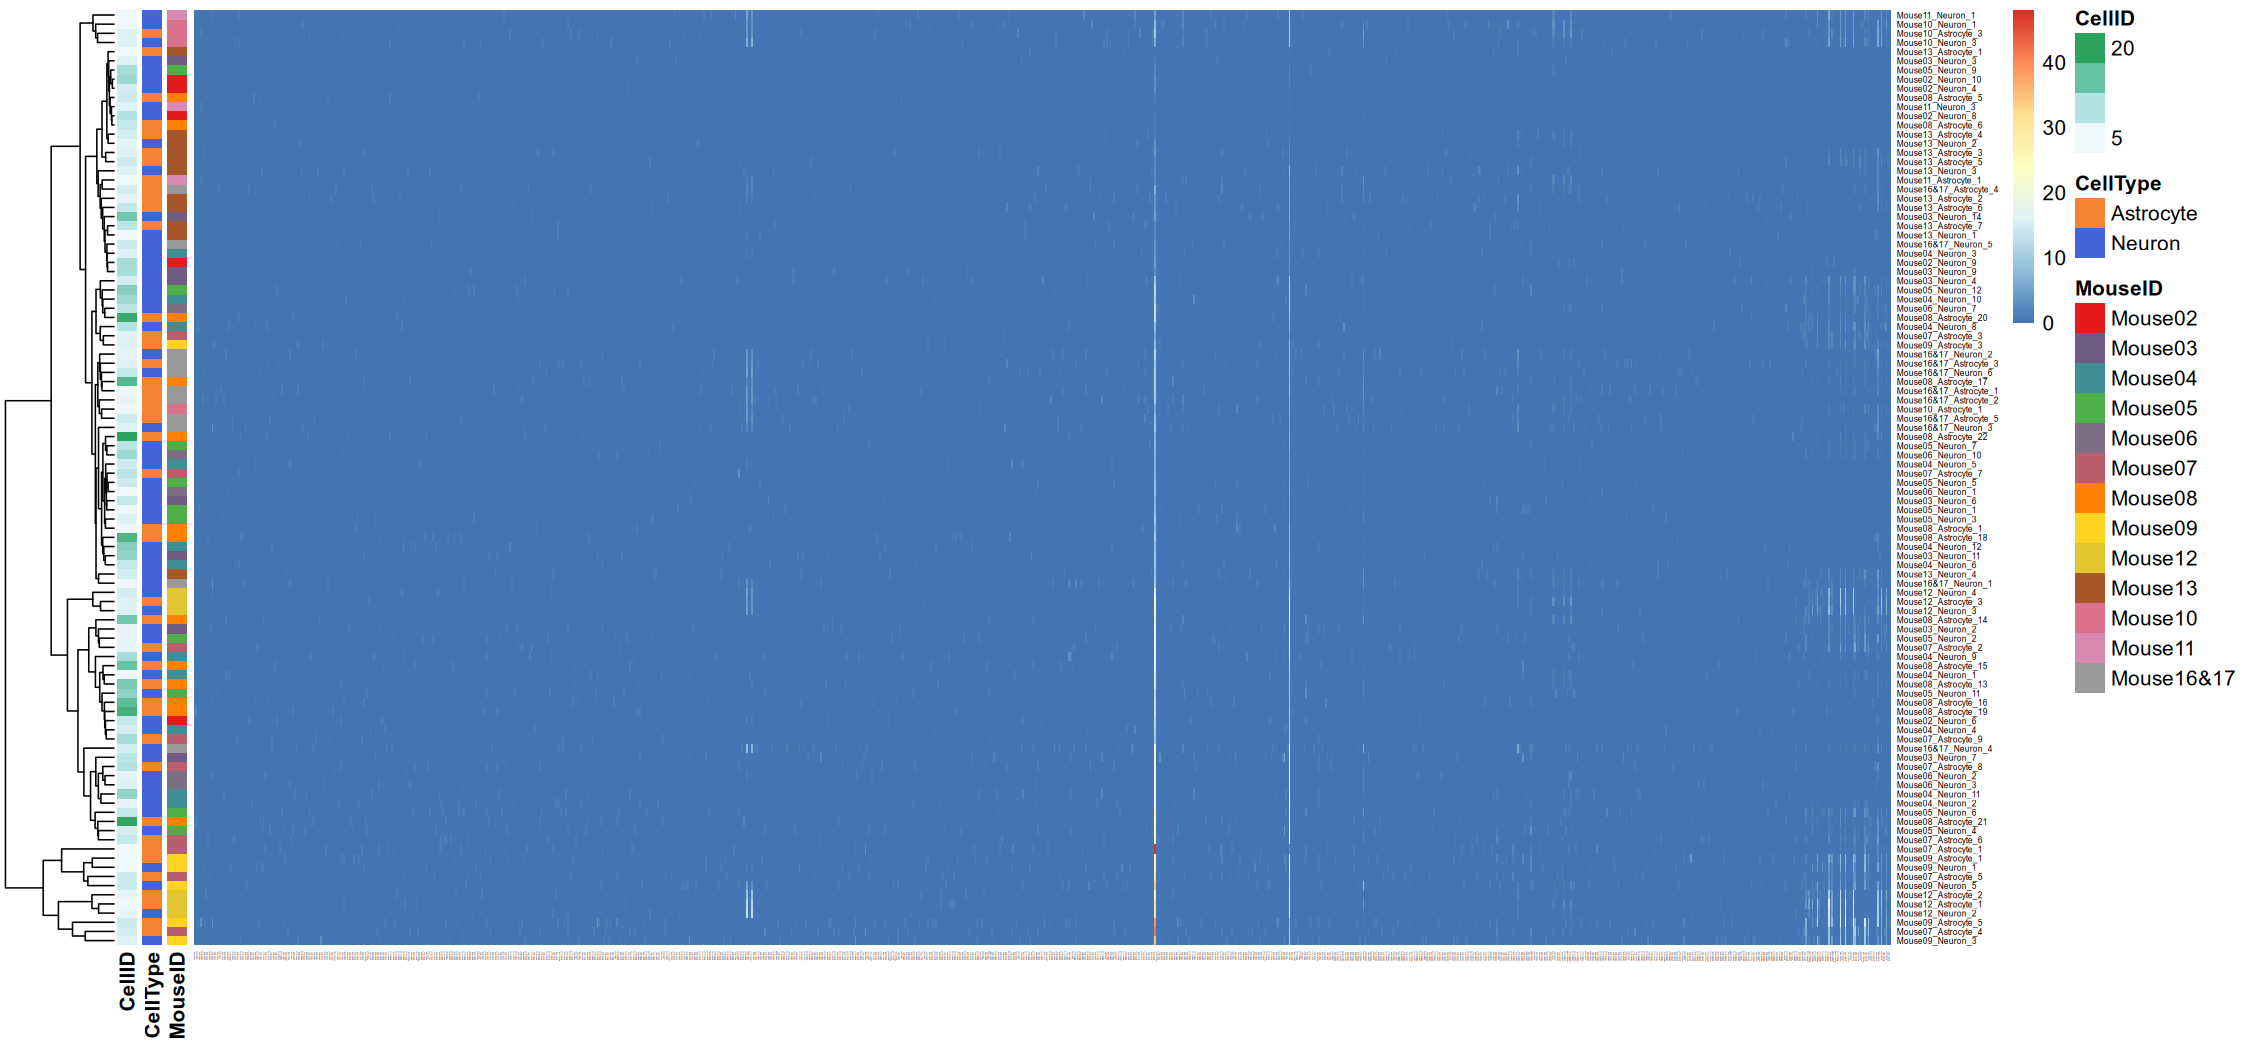

In [82]:
basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nmitoshassnv_bycell_byposmut_df <- as.data.frame(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nmitoshassnv_bycell_byposmut)
rownames(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nmitoshassnv_bycell_byposmut_df) <- basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nmitoshassnv_bycell_byposmut_df[, 1]
basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nmitoshassnv_bycell_byposmut_df <- basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nmitoshassnv_bycell_byposmut_df[, -c(1:7)]

options(repr.plot.height = 7, repr.plot.width = 15, res = 72)
pheatmap(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nmitoshassnv_bycell_byposmut_df, cluster_col = FALSE, cluster_row = TRUE, angle = 90, annotation_row = CellInfo_df[rownames(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nmitoshassnv_bycell_byposmut_df), c("MouseID", "CellType", "CellID")], annotation_color = list(MouseID = structure(colorRampPalette(scales::brewer_pal(palette = "Set1")(9))(length(MouseInfo[, MouseID])), names = MouseInfo[, MouseID]), CellType = c("Astrocyte" = Graphics$palette20[5], "Neuron" = Graphics$palette20[4])), fontsize_col = 1, fontsize_row = 4, show_rownames = TRUE, border_color = NA)

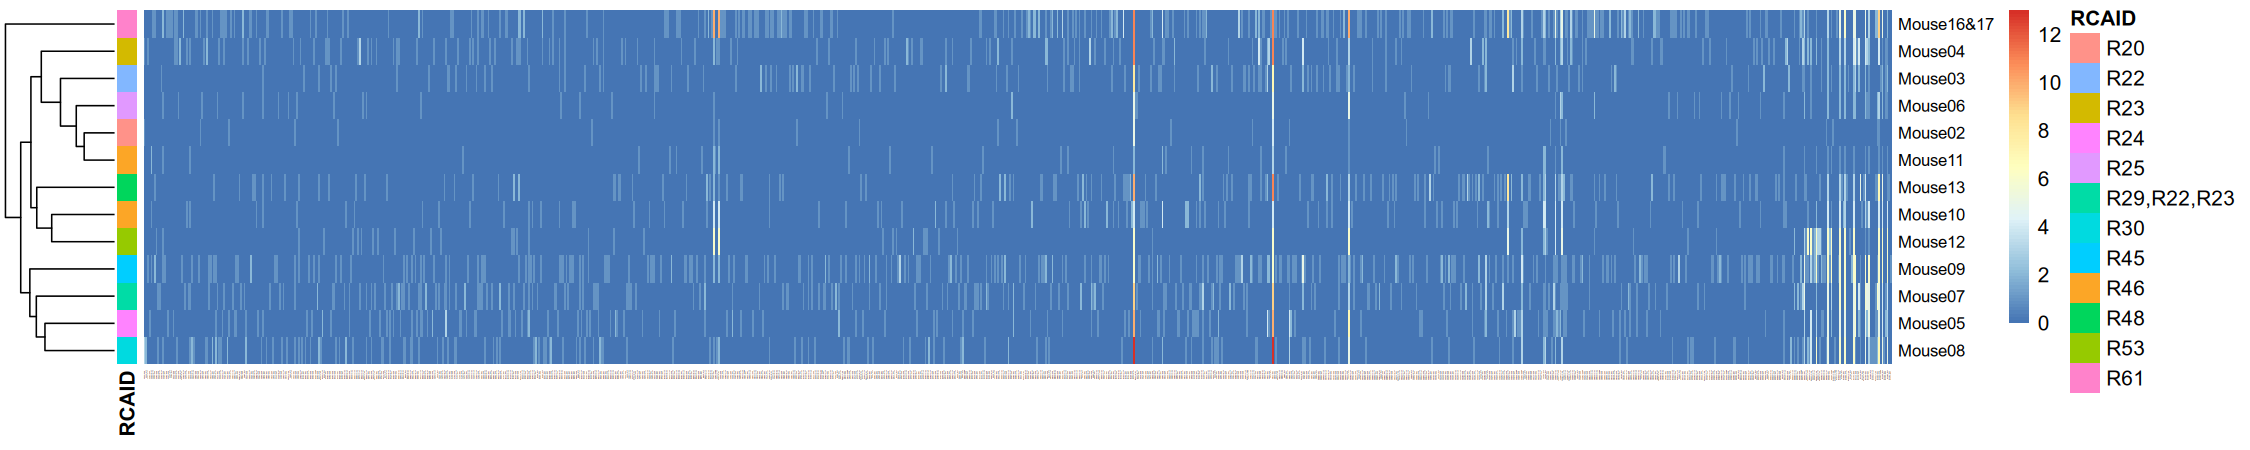

In [83]:
basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_ncellshassnv_bymouse_byposmut_df <- as.data.frame(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_ncellshassnv_bymouse_byposmut)
rownames(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_ncellshassnv_bymouse_byposmut_df) <- basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_ncellshassnv_bymouse_byposmut_df[, 1]
basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_ncellshassnv_bymouse_byposmut_df <- basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_ncellshassnv_bymouse_byposmut_df[, -c(1:2)]

options(repr.plot.height = 3, repr.plot.width = 15, res = 72)
pheatmap(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_ncellshassnv_bymouse_byposmut_df, cluster_col = FALSE, cluster_row = TRUE, angle = 90, annotation_row = MouseInfo_df[rownames(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_ncellshassnv_bymouse_byposmut_df), c("RCAID"), drop = FALSE], fontsize_col = 1, fontsize_row = 8, show_rownames = TRUE, border_color = NA)

For each SNV, how many mitos/cells/mice carry it?

In [84]:
basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_hassnv_bymito_byposmut <- fread(file = "Report/SNVs/QC/highdepth_highaf_noctrl_hassnv_bymito_byposmut.csv.gz")
basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_hassnv_bycell_byposmut <- fread(file = "Report/SNVs/QC/highdepth_highaf_noctrl_hassnv_bycell_byposmut.csv.gz")
basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_hassnv_bymouse_byposmut <- fread(file = "Report/SNVs/QC/highdepth_highaf_noctrl_hassnv_bymouse_byposmut.csv.gz")
basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nsampleshassnv_byposmut <- data.table(
    posmut = support_byposmut[, posmut], 
    nmitoshassnv = colSums(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_hassnv_bymito_byposmut[, support_byposmut[, posmut], with = FALSE]), 
    ncellshassnv = colSums(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_hassnv_bycell_byposmut[, support_byposmut[, posmut], with = FALSE]), 
    nmicehassnv = colSums(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_hassnv_bymouse_byposmut[, support_byposmut[, posmut], with = FALSE])
)
head(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nsampleshassnv_byposmut)

posmut   nmitoshassnv ncellshassnv nmicehassnv
1 1224:A>G 5            5            3          
2 1224:A>T 3            2            1          
3 1225:G>A 2            2            2          
4 1226:A>G 1            1            1          
5 1228:G>A 6            4            3          
6 1228:G>T 1            1            1

In [ ]:
fwrite(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nsampleshassnv_byposmut, file = "Report/SNVs/QC/highdepth_highaf_noctrl_nsampleshassnv_byposmut.csv")

Summarize nsamples stats for each SNV

In [86]:
basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_nsampleshasdata_byposmut <- fread(file = "Report/SNVs/QC/highdepth_noctrl_nsampleshasdata_byposmut.csv")
setkey(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_nsampleshasdata_byposmut, posmut)
basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nsampleshassnv_byposmut <- fread(file = "Report/SNVs/QC/highdepth_highaf_noctrl_nsampleshassnv_byposmut.csv")
setkey(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nsampleshassnv_byposmut, posmut)

basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nsamples_byposmut <- data.table(
    support_byposmut, 
    basediffperc_cutdemux_q30_unstranded_highdepth_noctrl_nsampleshasdata_byposmut[support_byposmut[, posmut], -1, on = "posmut"], 
    basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nsampleshassnv_byposmut[support_byposmut[, posmut], -1, on = "posmut"]
)
basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nsamples_byposmut[, c("fmitoshasdata", "fcellshasdata", "fmicehasdata") := list(nmitoshasdata / MitoInfo[IsCtrl == "N", uniqueN(LibraryMitoID)], ncellshasdata / MitoInfo[IsCtrl == "N", uniqueN(CellUID)], nmicehasdata / MitoInfo[IsCtrl == "N", uniqueN(MouseID)])]
basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nsamples_byposmut[, c("fmitoshassnv", "fcellshassnv", "fmicehassnv") := list(nmitoshassnv / nmitoshasdata, ncellshassnv / ncellshasdata, nmicehassnv / nmicehasdata)]
basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nsamples_byposmut[, c("fmitoshasdatahassnv", "fcellshasdatahassnv", "fmicehasdatahassnv") := list(nmitoshassnv / MitoInfo[IsCtrl == "N", uniqueN(LibraryMitoID)], ncellshassnv / MitoInfo[IsCtrl == "N", uniqueN(CellUID)], nmicehassnv / MitoInfo[IsCtrl == "N", uniqueN(MouseID)])]
head(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nsamples_byposmut)

posmut   SNVID pos  mut ref alt nmice ncells nmitos nmitoshasdata ⋯
1 1224:A>G SNV12 1224 A>G A   G   3     5      5      842           ⋯
2 1224:A>T SNV12 1224 A>T A   T   1     2      3      842           ⋯
3 1225:G>A SNV12 1225 G>A G   A   2     2      2      854           ⋯
4 1226:A>G SNV12 1226 A>G A   G   1     1      1      842           ⋯
5 1228:G>A SNV12 1228 G>A G   A   3     4      6      848           ⋯
6 1228:G>T SNV12 1228 G>T G   T   1     1      1      848           ⋯
  nmicehassnv fmitoshasdata fcellshasdata fmicehasdata fmitoshassnv
1 3           0.5118541     0.9411765     1            0.005938242 
2 1           0.5118541     0.9411765     1            0.003562945 
3 2           0.5191489     0.9411765     1            0.002341920 
4 1           0.5118541     0.9411765     1            0.001187648 
5 3           0.5155015     0.9411765     1            0.007075472 
6 1           0.5155015     0.9411765     1            0.001179245 
  fcellshassnv fmicehassnv fmitoshasdatahassnv fcellshasdatahassnv
1 0.05208333   0.23076923  0.0030395137        0.049019608        
2 0.02083333   0.07692308  0.0018237082        0.019607843        
3 0.02083333   0.15384615  0.0012158055        0.019607843        
4 0.01041667   0.07692308  0.0006079027        0.009803922        
5 0.04166667   0.23076923  0.0036474164        0.039215686        
6 0.01041667   0.07692308  0.0006079027        0.009803922        
  fmicehasdatahassnv
1 0.23076923        
2 0.07692308        
3 0.15384615        
4 0.07692308        
5 0.23076923        
6 0.07692308

In [ ]:
fwrite(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nsamples_byposmut, file = "Report/SNVs/QC/highdepth_highaf_noctrl_nsamples_byposmut.csv")

Number of variant alleles per mito/cell/mouse per SNV site

In [88]:
support_byposmut <- fread(file = "Report/SNVs/filter/basediffperc_cutdemux_sub500k_q30_unstranded_highdepth_highaf_qcfltd_support_byposmut.csv")
basediffperc_cutdemux_q30_unstranded_highdepth_highaf <- fread("Report/SNVs/filter/basediffperc_cutdemux_sub500k_q30_unstranded_highdepth_highaf_qcfltd.csv.gz")
basediffperc_cutdemux_q30_unstranded_highdepth_highaf[ref == "A", A := `=`]
basediffperc_cutdemux_q30_unstranded_highdepth_highaf[ref == "C", C := `=`]
basediffperc_cutdemux_q30_unstranded_highdepth_highaf[ref == "G", G := `=`]
basediffperc_cutdemux_q30_unstranded_highdepth_highaf[ref == "T", T := `=`]
basediffperc_cutdemux_q30_unstranded_highdepth_highaf <- melt.data.table(basediffperc_cutdemux_q30_unstranded_highdepth_highaf, measure.vars = c("A", "C", "G", "T", "del"), variable.name = "alt", value.name = "altperc")
setnames(basediffperc_cutdemux_q30_unstranded_highdepth_highaf, "=", "refperc")
basediffperc_cutdemux_q30_unstranded_highdepth_highaf[, alt := factor(alt, levels = c("A", "C", "G", "T", "del"))]
basediffperc_cutdemux_q30_unstranded_highdepth_highaf[, mut := factor(paste0(ref, ">", alt), levels = paste0(rep(c("A", "C", "G", "T"), each = 5), ">", c("A", "C", "G", "T", "del")))]
setkey(basediffperc_cutdemux_q30_unstranded_highdepth_highaf, pos, alt)
basediffperc_cutdemux_q30_unstranded_highdepth_highaf[, posmut := paste0(pos, ":", mut)]
basediffperc_cutdemux_q30_unstranded_highdepth_highaf[, posmut := factor(posmut, levels = unique(posmut))]
dim(basediffperc_cutdemux_q30_unstranded_highdepth_highaf)

[1] 35785    28

In [89]:
vaf_th <- 0.05
basediffperc_cutdemux_q30_unstranded_highdepth_highaf <- basediffperc_cutdemux_q30_unstranded_highdepth_highaf[altperc >= vaf_th * 100]
basediffperc_cutdemux_q30_unstranded_highdepth_highaf <- basediffperc_cutdemux_q30_unstranded_highdepth_highaf[ref != alt]

basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nvaralleles_bymito_bypos <- dcast.data.table(basediffperc_cutdemux_q30_unstranded_highdepth_highaf[IsCtrl == "N"], LibraryMitoID ~ pos, value.var = "alt", fun.aggregate = uniqueN)
basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nvaralleles_bymito_bypos <- MitoInfo[basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nvaralleles_bymito_bypos, on = "LibraryMitoID"]
dim(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nvaralleles_bymito_bypos)

[1] 1519  857

In [90]:
head(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nvaralleles_bymito_bypos)

LibraryID ExptID LibraryMitoID IsolationRCADate DIVDays CellType PlateID
1 DepSeq-L1 799    DepSeq-L1_M1  2020-08-28       3       Neuron   1      
2 DepSeq-L1 799    DepSeq-L1_M2  2020-08-28       3       Neuron   1      
3 DepSeq-L1 799    DepSeq-L1_M3  2020-08-28       3       Neuron   2      
4 DepSeq-L1 799    DepSeq-L1_M4  2020-08-14       3       Neuron   1      
5 DepSeq-L1 799    DepSeq-L1_M6  2020-08-14       3       Neuron   2      
6 DepSeq-L1 799    DepSeq-L1_M7  2020-09-15       3       Neuron   1      
  CellID CellUID          WellMitoBarcode ⋯ 16118 16119 16120 16122 16123 16124
1 3      Mouse04_Neuron_3 D11--M1         ⋯ 0     0     0     0     0     0    
2 6      Mouse04_Neuron_6 E12--M2         ⋯ 0     0     0     0     0     0    
3 5      Mouse04_Neuron_5 E11--M3         ⋯ 0     0     0     0     0     0    
4 6      Mouse02_Neuron_6 D5--M4          ⋯ 0     0     0     0     0     0    
5 9      Mouse02_Neuron_9 B5--M6          ⋯ 0     0     0     0     0     0    
6 1      Mouse06_Neuron_1 A5--M7          ⋯ 0     0     0     0     0     0    
  16125 16133 16140 16141
1 0     0     0     0    
2 0     0     0     0    
3 0     0     0     0    
4 1     0     0     0    
5 0     0     0     0    
6 0     0     0     0

In [ ]:
fwrite(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nvaralleles_bymito_bypos, file = "Report/SNVs/QC/highdepth_highaf_noctrl_nvaralleles_bymito_bypos.csv")

In [92]:
basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nvaralleles_bycell_bypos <- dcast.data.table(basediffperc_cutdemux_q30_unstranded_highdepth_highaf[IsCtrl == "N"], CellUID ~ pos, value.var = "alt", fun.aggregate = uniqueN)
basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nvaralleles_bycell_bypos <- CellInfo[basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nvaralleles_bycell_bypos, on = "CellUID"]
dim(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nvaralleles_bycell_bypos)

[1] 102 845

In [93]:
head(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nvaralleles_bycell_bypos)

CellUID           IsolationRCADate DIVDays CellType CellID RCAID MouseID 1224
1 Mouse02_Neuron_10 2020-08-14       3       Neuron   10     R20   Mouse02 0   
2 Mouse02_Neuron_4  2020-08-14       3       Neuron    4     R20   Mouse02 0   
3 Mouse02_Neuron_6  2020-08-14       3       Neuron    6     R20   Mouse02 1   
4 Mouse02_Neuron_8  2020-08-14       3       Neuron    8     R20   Mouse02 0   
5 Mouse02_Neuron_9  2020-08-14       3       Neuron    9     R20   Mouse02 0   
6 Mouse03_Neuron_11 2020-08-21       3       Neuron   11     R22   Mouse03 0   
  1225 1226 ⋯ 16118 16119 16120 16122 16123 16124 16125 16133 16140 16141
1 0    0    ⋯ 0     0     0     0     0     0     0     0     0     0    
2 0    0    ⋯ 0     0     0     0     0     0     0     0     0     0    
3 0    0    ⋯ 0     0     0     0     0     0     2     0     0     0    
4 0    0    ⋯ 0     0     0     0     0     0     0     0     0     0    
5 0    0    ⋯ 0     0     0     0     0     0     0     0     0     0    
6 0    0    ⋯ 0     0     0     0     0     0     1     0     0     0

In [ ]:
fwrite(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nvaralleles_bycell_bypos, file = "Report/SNVs/QC/highdepth_highaf_noctrl_nvaralleles_bycell_bypos.csv")

In [95]:
basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nvaralleles_bymouse_bypos <- dcast.data.table(basediffperc_cutdemux_q30_unstranded_highdepth_highaf[IsCtrl == "N"], MouseID ~ pos, value.var = "alt", fun.aggregate = uniqueN)
basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nvaralleles_bymouse_bypos <- MouseInfo[basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nvaralleles_bymouse_bypos, on = "MouseID"]
dim(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nvaralleles_bymouse_bypos)

[1]  13 840

In [96]:
head(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nvaralleles_bymouse_bypos)

MouseID RCAID       1224 1225 1226 1228 1229 1230 1231 1232 ⋯ 16118 16119
1 Mouse02 R20         1    0    0    0    0    0    0    0    ⋯ 0     0    
2 Mouse03 R22         0    0    0    0    0    0    0    1    ⋯ 1     0    
3 Mouse04 R23         1    1    0    0    0    0    0    0    ⋯ 1     1    
4 Mouse05 R24         0    0    1    0    0    0    0    0    ⋯ 1     1    
5 Mouse06 R25         0    0    0    0    0    0    0    0    ⋯ 1     1    
6 Mouse07 R29,R22,R23 0    0    0    0    0    0    1    1    ⋯ 1     1    
  16120 16122 16123 16124 16125 16133 16140 16141
1 0     0     0     0     2     0     0     0    
2 1     0     0     0     1     2     1     0    
3 1     0     0     0     1     2     1     0    
4 1     0     0     1     2     2     1     0    
5 1     0     0     0     2     2     1     0    
6 1     0     0     1     2     2     1     0

In [ ]:
fwrite(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nvaralleles_bymouse_bypos, file = "Report/SNVs/QC/highdepth_highaf_noctrl_nvaralleles_bymouse_bypos.csv")

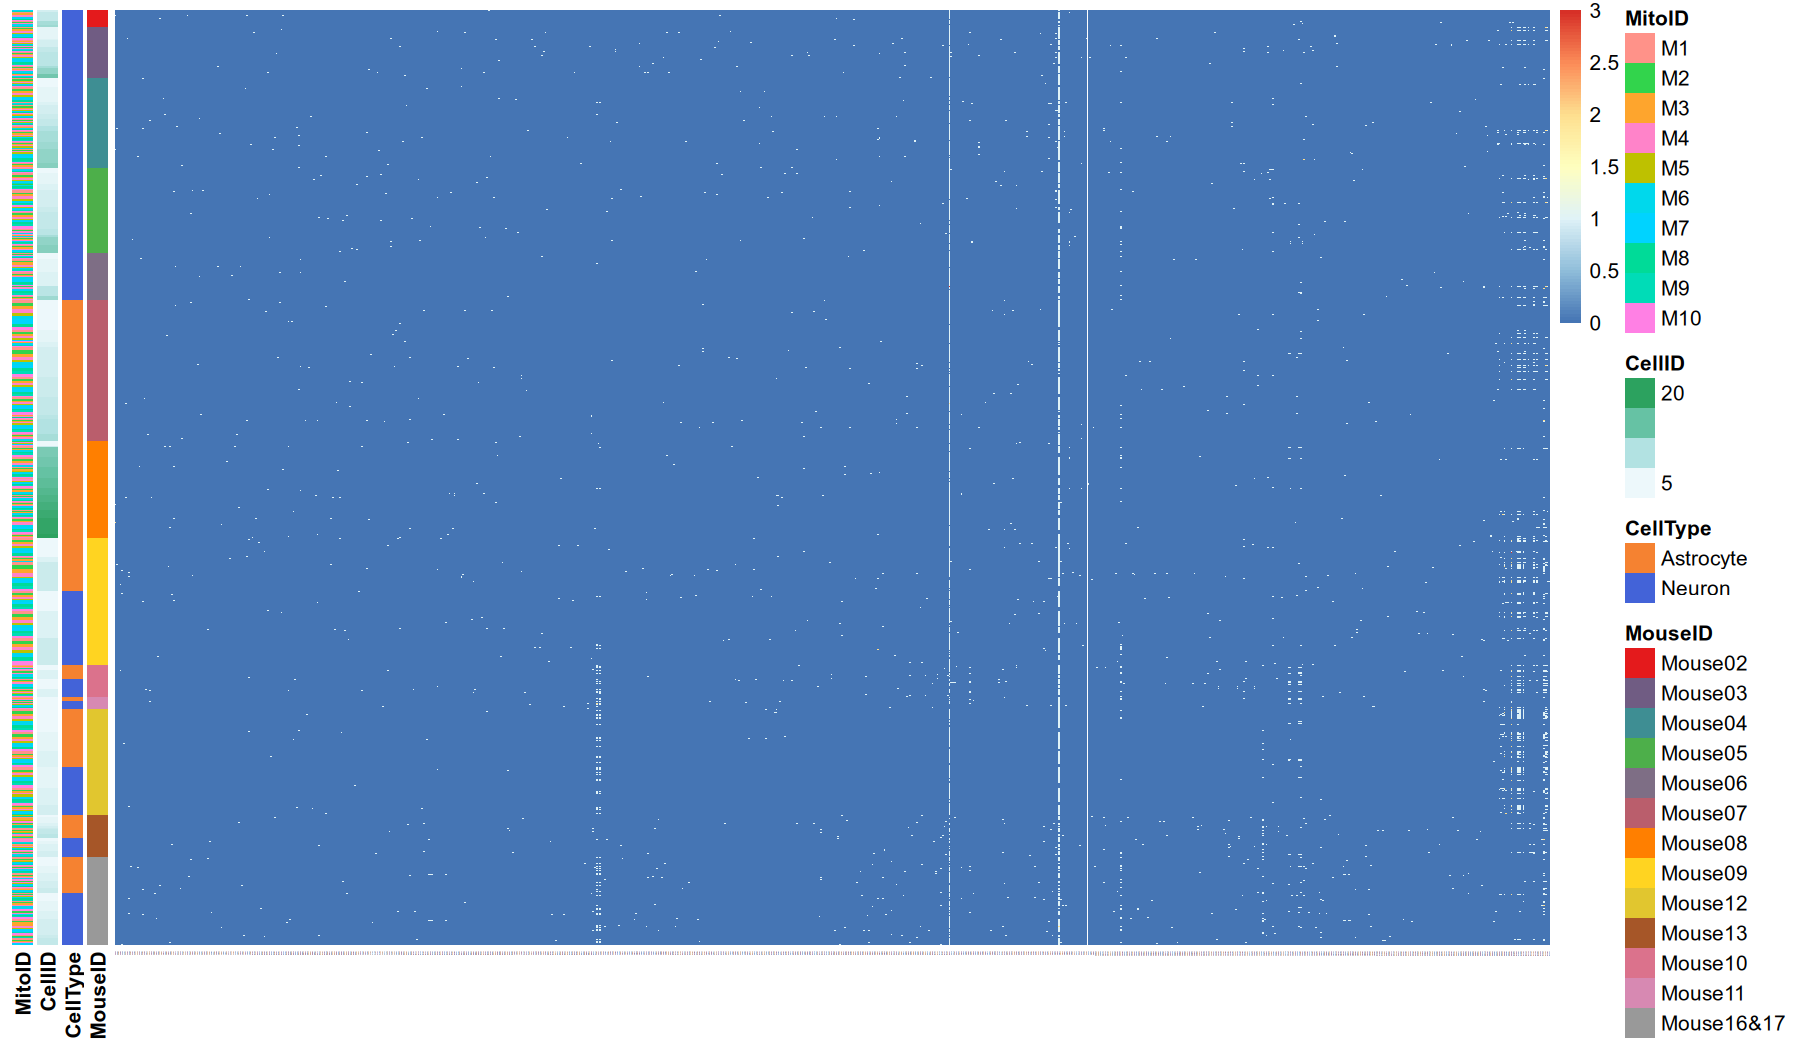

In [98]:
basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nvaralleles_bymito_bypos_df <- as.data.frame(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nvaralleles_bymito_bypos[, -c(1:19)])
rownames(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nvaralleles_bymito_bypos_df) <- basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nvaralleles_bymito_bypos[, LibraryMitoID]
MitoInfo_df <- as.data.frame(MitoInfo)
rownames(MitoInfo_df) <- MitoInfo_df$LibraryMitoID
MitoInfo_df$MitoID <- factor(MitoInfo_df$MitoID, levels = mitoIDs)
MitoInfo_df$CellID <- as.integer(MitoInfo_df$CellID)
MitoInfo_df$MouseID <- factor(MitoInfo_df$MouseID, levels = sort(MouseInfo[, MouseID]))
basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nvaralleles_bymito_bypos_df <- basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nvaralleles_bymito_bypos_df[with(MitoInfo_df[rownames(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nvaralleles_bymito_bypos_df), ], order(MouseID, CellType, CellID, MitoID)), ]

options(repr.plot.height = 7, repr.plot.width = 12, res = 72)
pheatmap(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nvaralleles_bymito_bypos_df, cluster_col = FALSE, cluster_row = FALSE, angle = 90, annotation_row = MitoInfo_df[rownames(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nvaralleles_bymito_bypos_df), c("MouseID", "CellType", "CellID", "MitoID")], annotation_color = list(MouseID = structure(colorRampPalette(scales::brewer_pal(palette = "Set1")(9))(length(MouseInfo[, MouseID])), names = MouseInfo[, MouseID]), CellType = c("Astrocyte" = Graphics$palette20[5], "Neuron" = Graphics$palette20[4])), fontsize_col = 1, show_rownames = FALSE, na_col = "#FFFFFFFF")

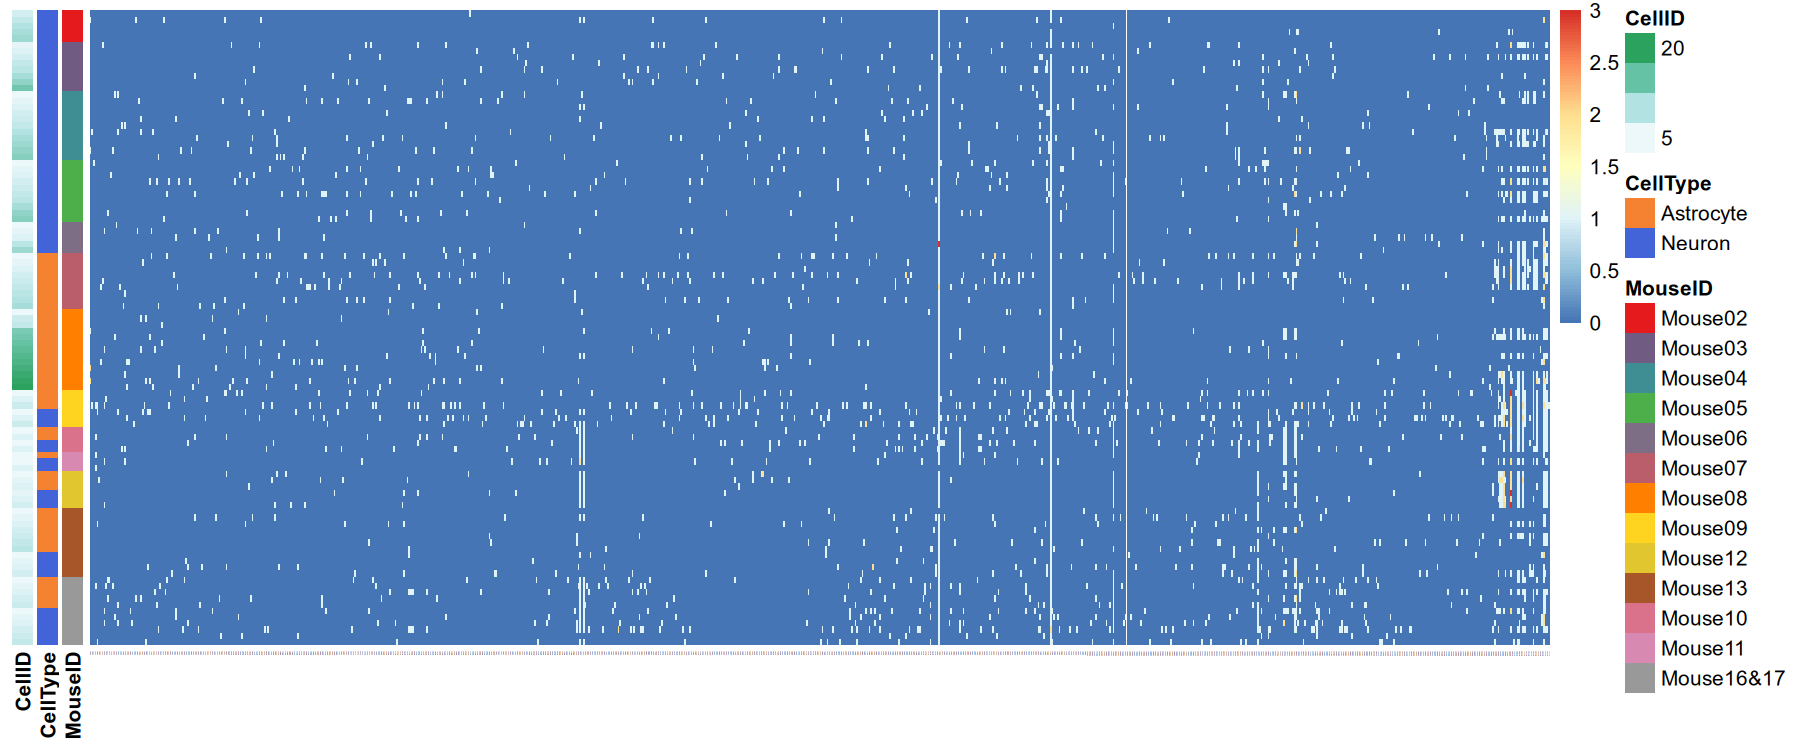

In [99]:
basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nvaralleles_bycell_bypos_df <- as.data.frame(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nvaralleles_bycell_bypos[, -c(1:7)])
rownames(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nvaralleles_bycell_bypos_df) <- basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nvaralleles_bycell_bypos[, CellUID]
CellInfo_df <- as.data.frame(CellInfo)
rownames(CellInfo_df) <- CellInfo_df$CellUID
CellInfo_df$CellID <- as.integer(CellInfo_df$CellID)
CellInfo_df$MouseID <- factor(CellInfo_df$MouseID, levels = sort(MouseInfo[, MouseID]))
basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nvaralleles_bycell_bypos_df <- basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nvaralleles_bycell_bypos_df[with(CellInfo_df[rownames(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nvaralleles_bycell_bypos_df), ], order(MouseID, CellType, CellID)), ]

options(repr.plot.height = 5, repr.plot.width = 12, res = 72)
pheatmap(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nvaralleles_bycell_bypos_df, cluster_col = FALSE, cluster_row = FALSE, angle = 90, annotation_row = CellInfo_df[rownames(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nvaralleles_bycell_bypos_df), c("MouseID", "CellType", "CellID")], annotation_color = list(MouseID = structure(colorRampPalette(scales::brewer_pal(palette = "Set1")(9))(length(MouseInfo[, MouseID])), names = MouseInfo[, MouseID]), CellType = c("Astrocyte" = Graphics$palette20[5], "Neuron" = Graphics$palette20[4])), fontsize_col = 1, show_rownames = FALSE, na_col = "#FFFFFFFF")

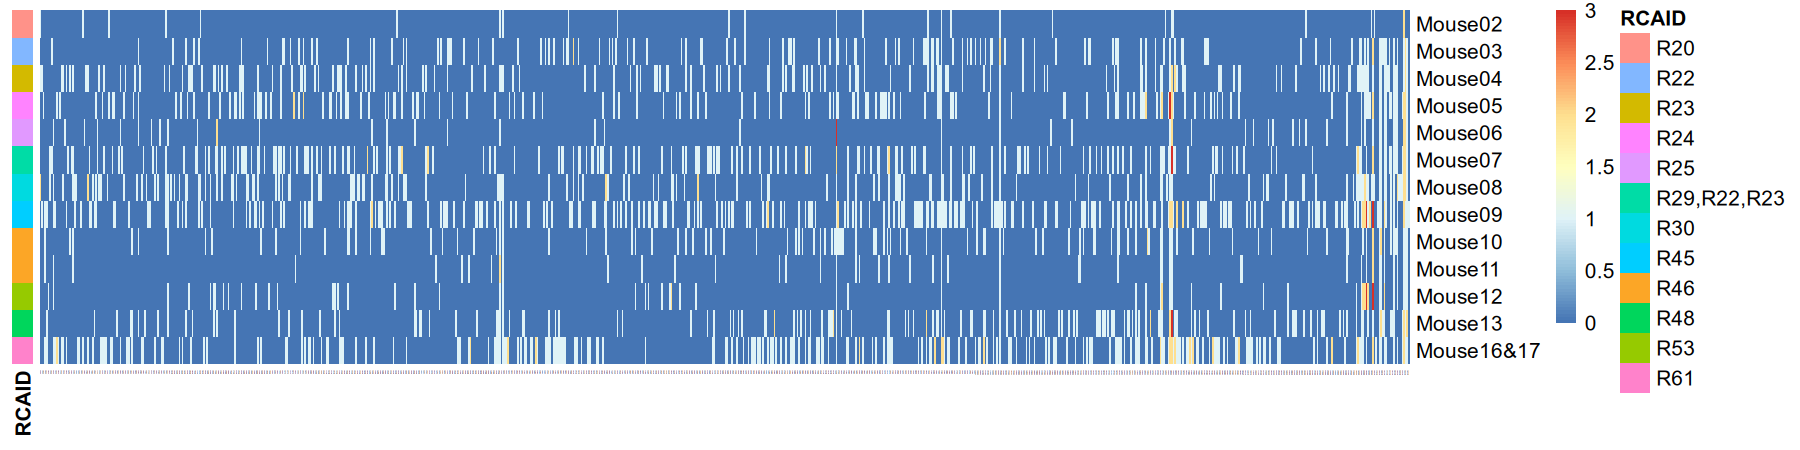

In [100]:
basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nvaralleles_bymouse_bypos_df <- as.data.frame(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nvaralleles_bymouse_bypos[, -c(1:2)])
rownames(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nvaralleles_bymouse_bypos_df) <- basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nvaralleles_bymouse_bypos[, MouseID]
MouseInfo_df <- as.data.frame(MouseInfo)
rownames(MouseInfo_df) <- MouseInfo_df$MouseID
MouseInfo_df$MouseID <- factor(MouseInfo_df$MouseID, levels = sort(MouseInfo[, MouseID]))
MouseInfo_df$RCAID <- factor(MouseInfo_df$RCAID, levels = unique(sort(MouseInfo[, RCAID])))
basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nvaralleles_bymouse_bypos_df <- basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nvaralleles_bymouse_bypos_df[with(MouseInfo_df[rownames(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nvaralleles_bymouse_bypos_df), ], order(MouseID, RCAID)), ]

options(repr.plot.height = 3, repr.plot.width = 12, res = 72)
pheatmap(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nvaralleles_bymouse_bypos_df, cluster_col = FALSE, cluster_row = FALSE, angle = 90, annotation_row = MouseInfo_df[rownames(basediffperc_cutdemux_q30_unstranded_highdepth_highaf_noctrl_nvaralleles_bymouse_bypos_df), c("RCAID"), drop = FALSE], annotation_color = list(MouseID = structure(colorRampPalette(scales::brewer_pal(palette = "Set1")(9))(length(MouseInfo[, MouseID])), names = MouseInfo[, MouseID]), CellType = c("Astrocyte" = Graphics$palette20[5], "Neuron" = Graphics$palette20[4])), fontsize_col = 1, show_rownames = TRUE, na_col = "#FFFFFFFF")

How is VAF correlated with the number of mitos/cells/mice sharing the SNV?

In [101]:
support_byposmut <- fread(file = "Report/SNVs/filter/basediffperc_cutdemux_sub500k_q30_unstranded_highdepth_highaf_qcfltd_support_byposmut.csv")
basediffperc_cutdemux_q30_unstranded_highdepth <- fread("Report/SNVs/filter/basediffperc_cutdemux_sub500k_q30_unstranded_highdepth.csv.gz")
basediffperc_cutdemux_q30_unstranded_highdepth[ref == "A", A := `=`]
basediffperc_cutdemux_q30_unstranded_highdepth[ref == "C", C := `=`]
basediffperc_cutdemux_q30_unstranded_highdepth[ref == "G", G := `=`]
basediffperc_cutdemux_q30_unstranded_highdepth[ref == "T", T := `=`]
basediffperc_cutdemux_q30_unstranded_highdepth <- melt(basediffperc_cutdemux_q30_unstranded_highdepth, measure.vars = c("A", "C", "G", "T", "del"), variable.name = "alt", value.name = "altperc")
setnames(basediffperc_cutdemux_q30_unstranded_highdepth, "=", "refperc")
basediffperc_cutdemux_q30_unstranded_highdepth[, alt := factor(alt, levels = c("A", "C", "G", "T", "del"))]
basediffperc_cutdemux_q30_unstranded_highdepth[, mut := factor(paste0(ref, ">", alt), levels = paste0(rep(c("A", "C", "G", "T"), each = 5), ">", c("A", "C", "G", "T", "del")))]
setkey(basediffperc_cutdemux_q30_unstranded_highdepth, pos, alt)
basediffperc_cutdemux_q30_unstranded_highdepth[, posmut := paste0(pos, ":", mut)]
basediffperc_cutdemux_q30_unstranded_highdepth[, posmut := factor(posmut, levels = unique(posmut))]
dim(basediffperc_cutdemux_q30_unstranded_highdepth)

[1] 8515765      28

In [102]:
basediffperc_cutdemux_q30_unstranded_highdepth <- basediffperc_cutdemux_q30_unstranded_highdepth[as.character(posmut) %in% support_byposmut[, unique(posmut)]]
dim(basediffperc_cutdemux_q30_unstranded_highdepth)

[1] 1021830      28

In [103]:
basediffperc_cutdemux_q30_unstranded_highdepth_noctrl <- basediffperc_cutdemux_q30_unstranded_highdepth[IsCtrl == "N"] 
dim(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl)

[1] 973133     28

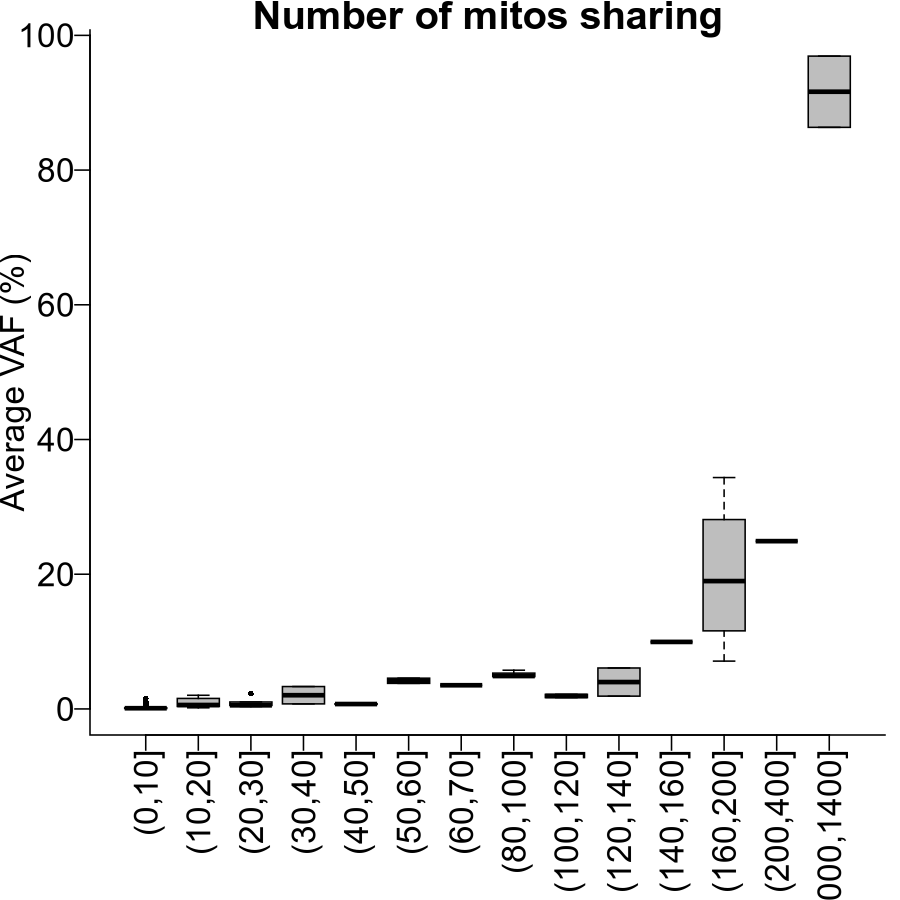

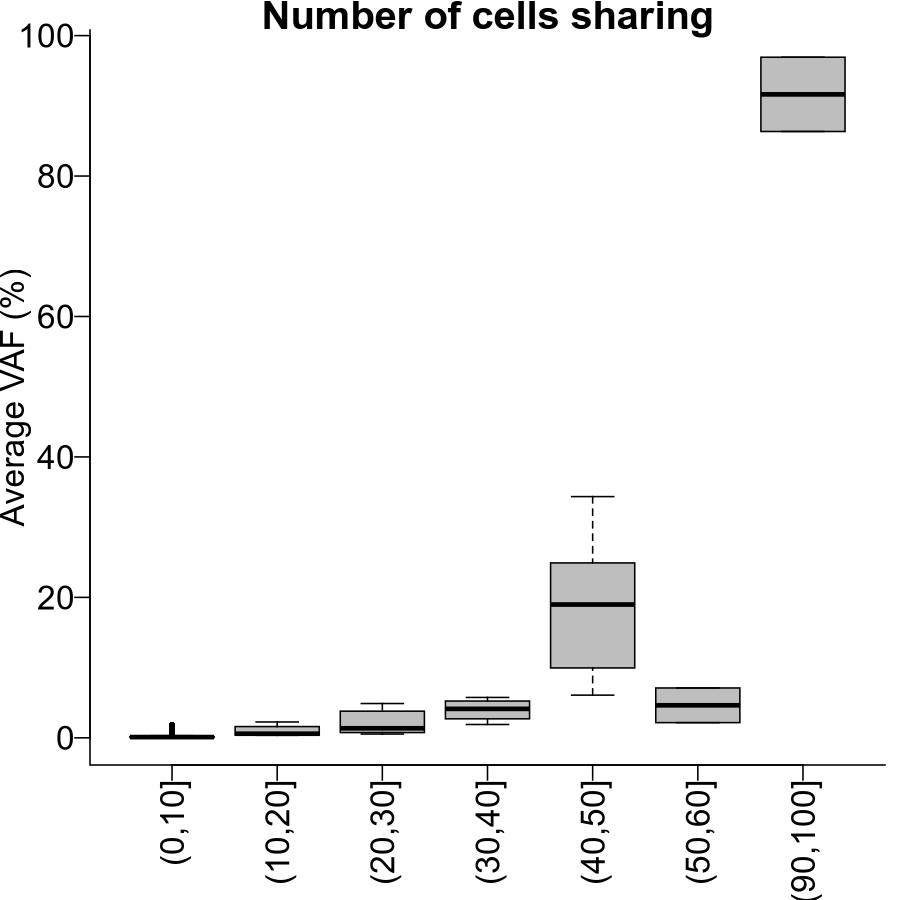

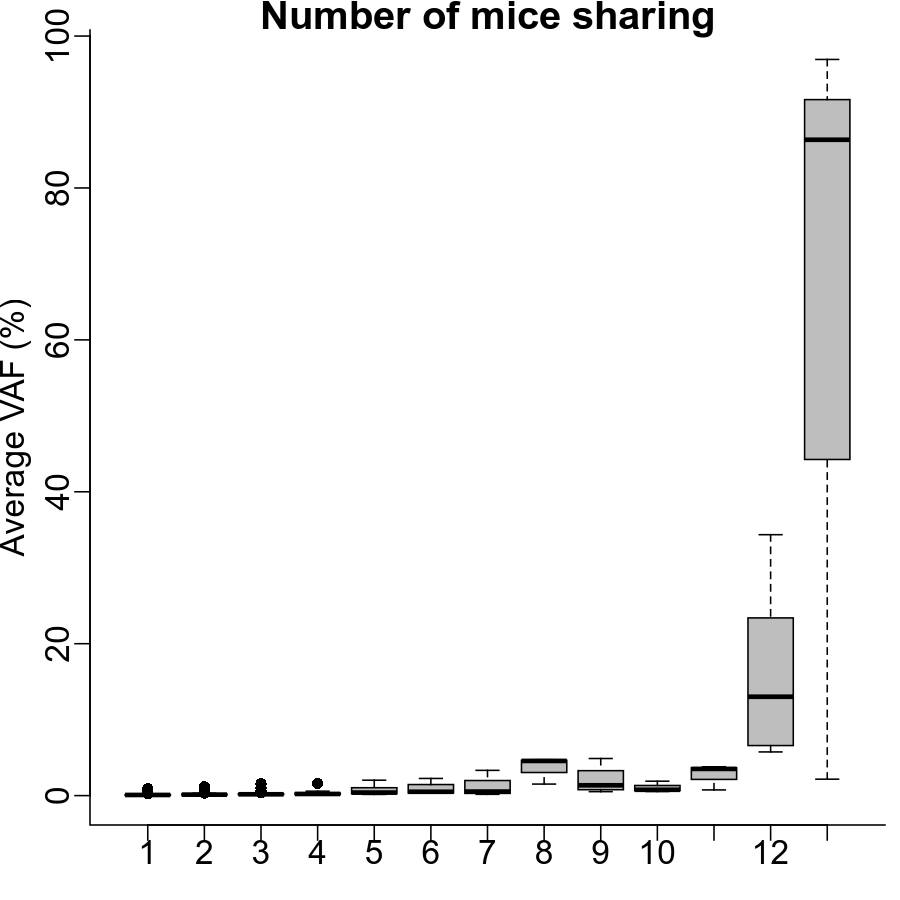

In [104]:
basediffperc_cutdemux_q30_unstranded_highdepth_avgvaf_support_byposmut <- merge.data.table(basediffperc_cutdemux_q30_unstranded_highdepth_noctrl[, .(avgvaf = mean(altperc)), by = "posmut"], support_byposmut, by = "posmut")
basediffperc_cutdemux_q30_unstranded_highdepth_avgvaf_support_byposmut[, ncells1 := cut(ncells, breaks = c(0, 10, 20, 30, 40, 50, 60, 90, 100), include.lowest = FALSE)]
basediffperc_cutdemux_q30_unstranded_highdepth_avgvaf_support_byposmut[, nmitos1 := cut(nmitos, breaks = c(0, 10, 20, 30, 40, 50, 60, 70, 80, 100, 120, 140, 160, 200, 400, 600, 800, 1000, 1400), include.lowest = FALSE, dig.lab = 5)]

options(repr.plot.height = 6, repr.plot.width = 6, res = 72)
par(ps = 16, lend = 2, ljoin = 1, bty = "L", mar = c(5.5, 3, 1, 0.5), oma = c(0, 0, 0, 0), mgp = c(2, 0.5, 0))
boxplot(avgvaf ~ nmitos1, xlab = "", main = "Number of mitos sharing", ylab = "Average VAF (%)", horizontal = FALSE, data = basediffperc_cutdemux_q30_unstranded_highdepth_avgvaf_support_byposmut, pch = 16, col = "gray", cex = 0.5, las = 2, drop = TRUE)
par(ps = 16, lend = 2, ljoin = 1, bty = "L", mar = c(4.5, 3, 1, 0.5), oma = c(0, 0, 0, 0), mgp = c(2, 0.5, 0))
boxplot(avgvaf ~ ncells1, xlab = "", main = "Number of cells sharing", ylab = "Average VAF (%)", horizontal = FALSE, data = basediffperc_cutdemux_q30_unstranded_highdepth_avgvaf_support_byposmut, pch = 16, col = "gray", cex = 0.5, las = 2, drop = TRUE)
par(ps = 16, lend = 2, ljoin = 1, bty = "L", mar = c(2.5, 3, 1, 0.5), oma = c(0, 0, 0, 0), mgp = c(2, 0.5, 0))
boxplot(avgvaf ~ nmice, xlab = "", main = "Number of mice sharing", ylab = "Average VAF (%)", horizontal = FALSE, data = basediffperc_cutdemux_q30_unstranded_highdepth_avgvaf_support_byposmut, pch = 16, col = "gray")

Number of SNVs by number of mitos/cells/mice sharing the SNV

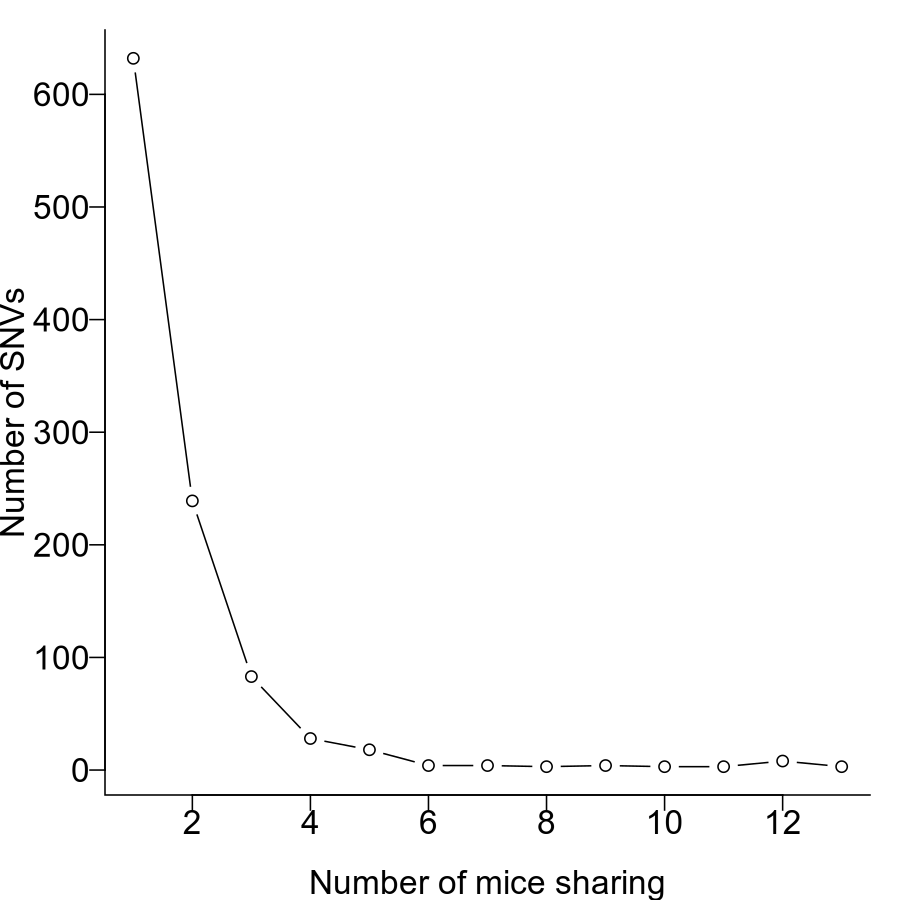

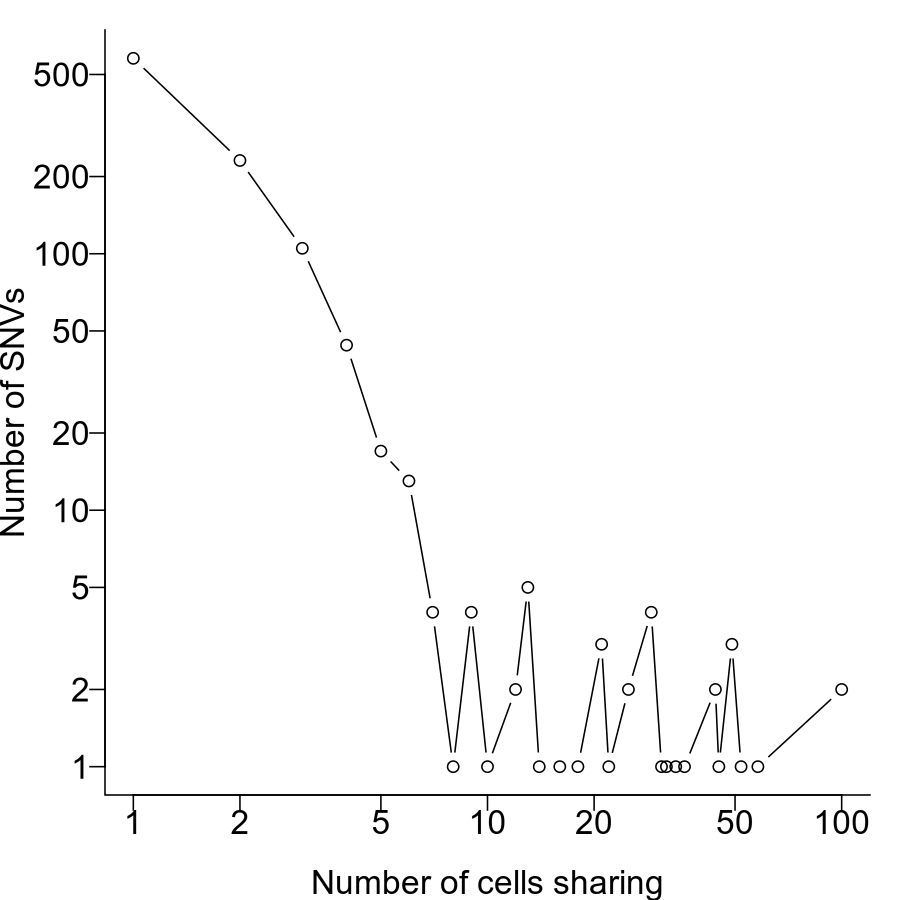

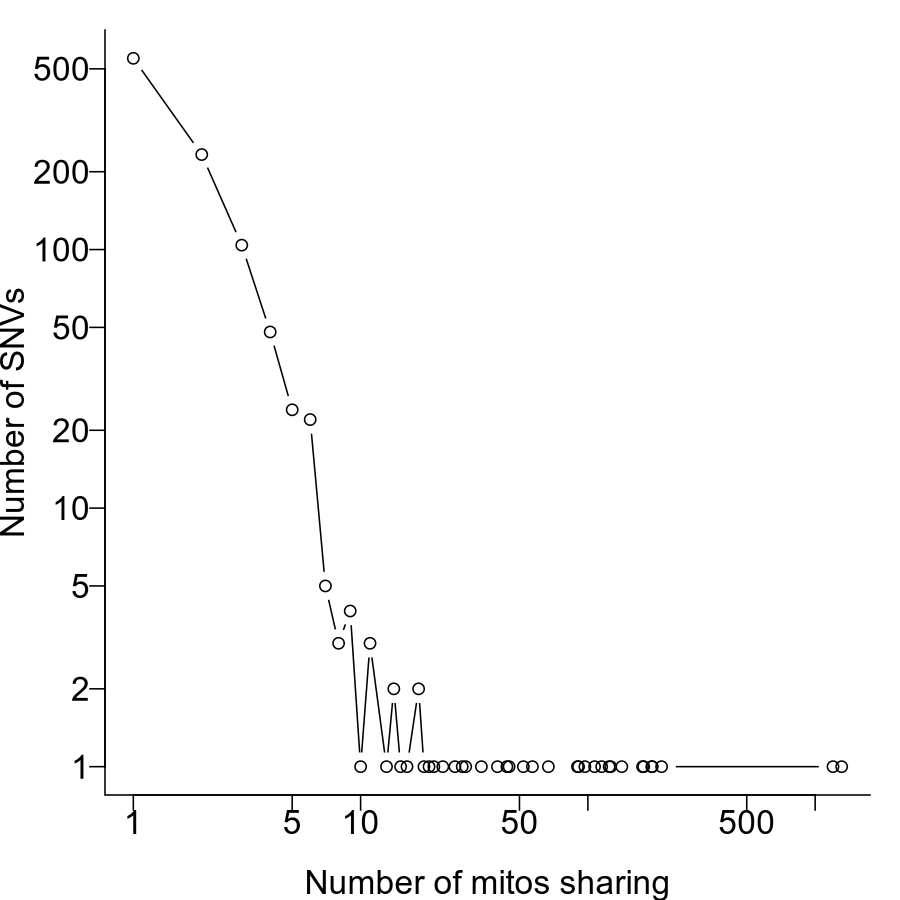

In [105]:
options(repr.plot.height = 6, repr.plot.width = 6, res = 72)
par(ps = 16, las = 1, lend = 2, ljoin = 1, bty = "L", mfrow = c(1, 1), mar = c(3.5, 3.5, 1, 1), oma = c(0, 0, 0, 0), mgp = c(2.5, 0.5, 0))
invisible(support_byposmut[, .N, by = nmice][order(nmice)][, plot(N ~ nmice,  xlab = "Number of mice sharing", ylab = "Number of SNVs", type = 'b')])
invisible(support_byposmut[, .N, by = ncells][order(ncells)][, plot(N ~ ncells, log = "xy", xlab = "Number of cells sharing", ylab = "Number of SNVs", type = "b")])
invisible(support_byposmut[, .N, by = nmitos][order(nmitos)][, plot(N ~ nmitos, log = "xy", xlab = "Number of mitos sharing", ylab = "Number of SNVs", type = "b")])

How is the number of mice/cells/mitos sharing each SNV site correlated to the number of variant alleles at each SNV site? 

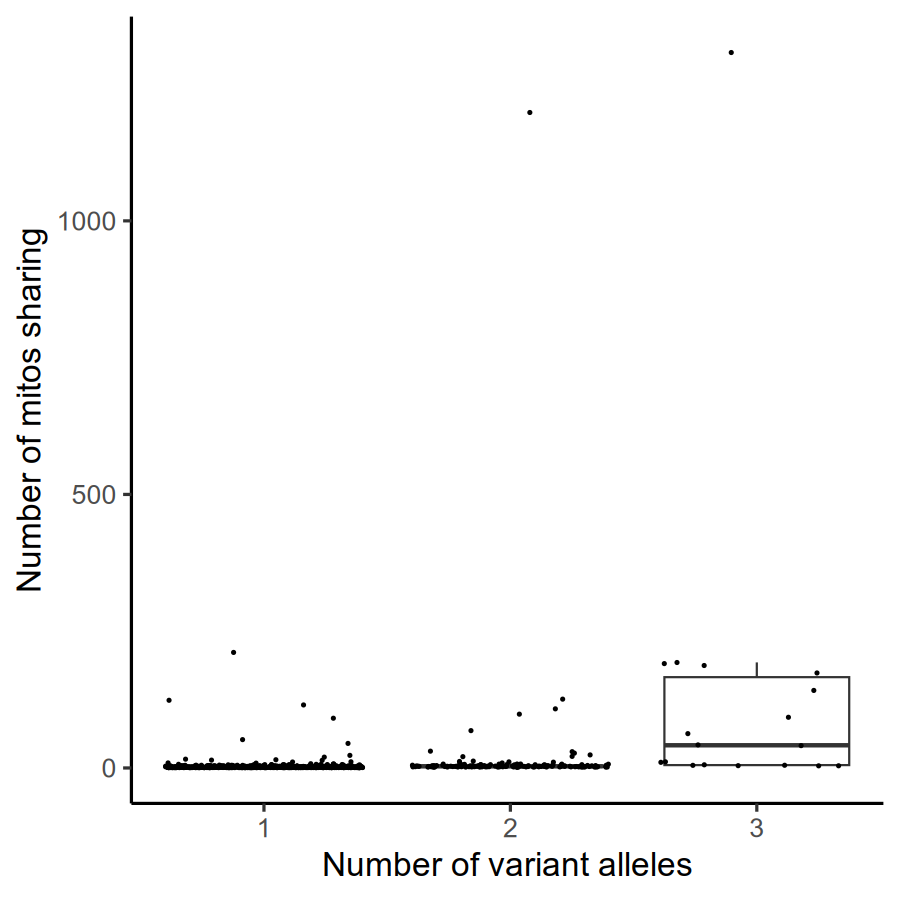

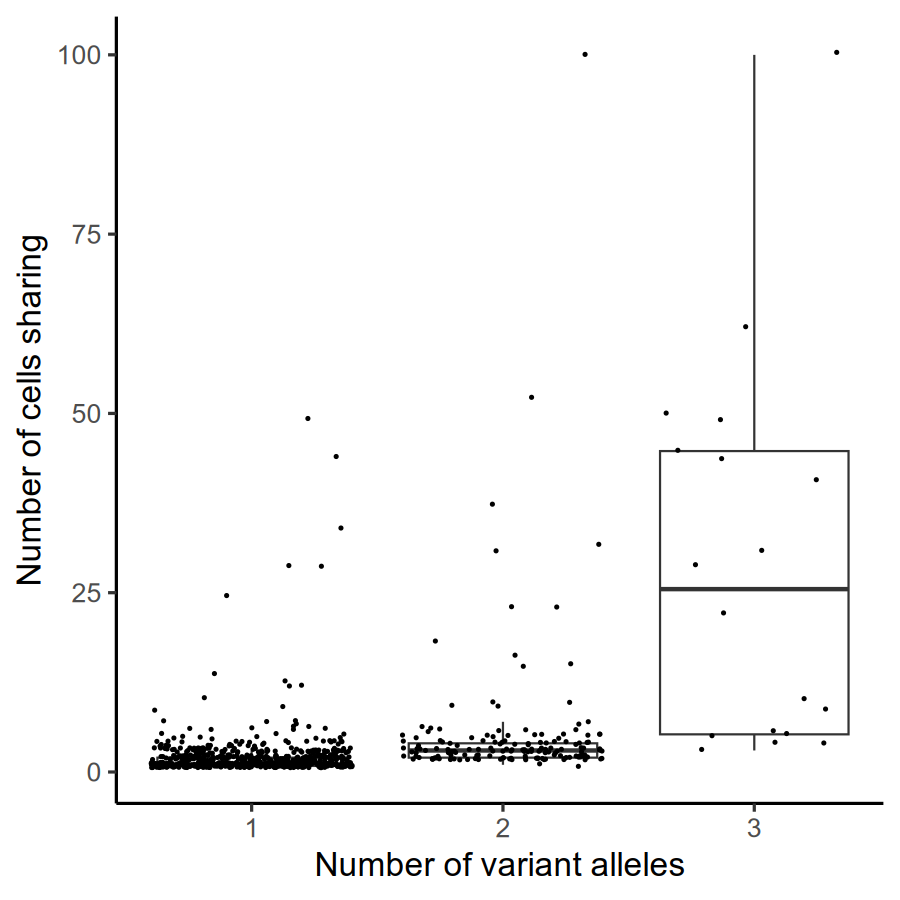

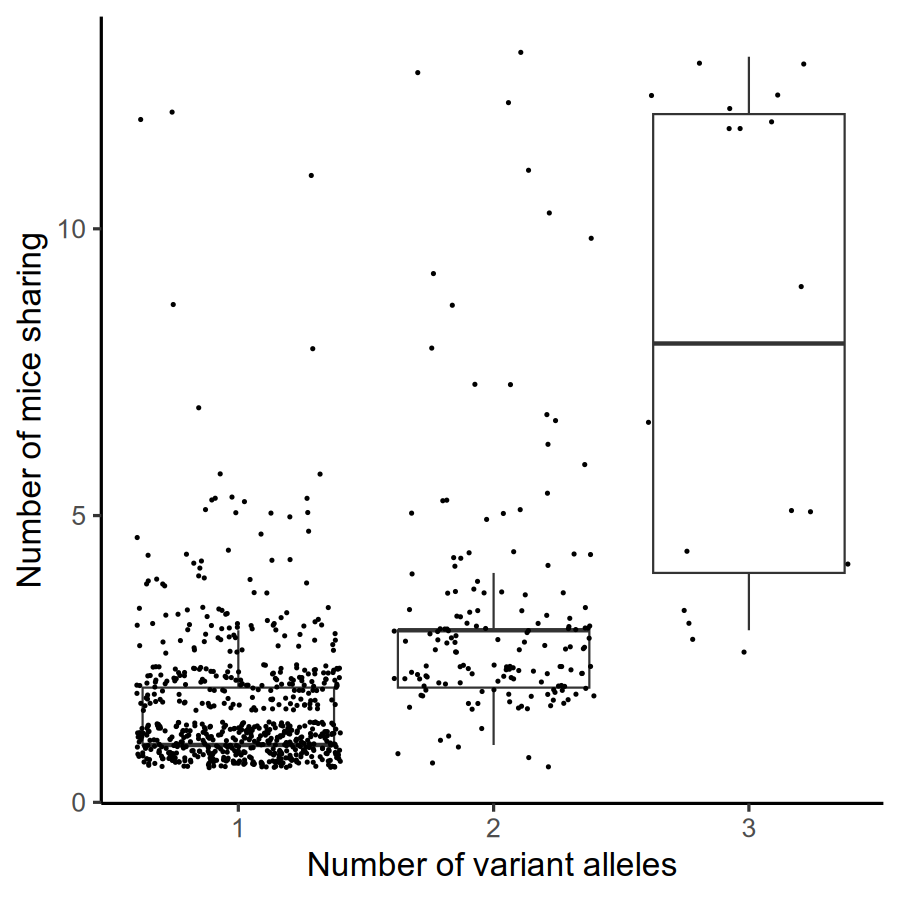

In [106]:
support_bypos <- fread(file = "Report/SNVs/filter/basediffperc_cutdemux_sub500k_q30_unstranded_highdepth_highaf_qcfltd_support_bypos.csv")
nvaralleles_bypos <- support_byposmut[, list(nvaralleles = uniqueN(posmut)), by = 'pos']
support_nvaralleles_bypos <- support_bypos[nvaralleles_bypos, on = "pos"]

options(repr.plot.height = 6, repr.plot.width = 6, res = 72)
ggplot(support_nvaralleles_bypos, aes(x = nvaralleles, y = nmitos, group = nvaralleles)) + theme_classic(base_size = 16) + geom_boxplot(outlier.color = NA) + geom_jitter(size = 0.5) + xlab("Number of variant alleles") + ylab("Number of mitos sharing")
ggplot(support_nvaralleles_bypos, aes(x = nvaralleles, y = ncells, group = nvaralleles)) + theme_classic(base_size = 16) + geom_boxplot(outlier.color = NA) + geom_jitter(size = 0.5) + xlab("Number of variant alleles") + ylab("Number of cells sharing")
ggplot(support_nvaralleles_bypos, aes(x = nvaralleles, y = nmice, group = nvaralleles)) + theme_classic(base_size = 16) + geom_boxplot(outlier.color = NA) + geom_jitter(size = 0.5) + xlab("Number of variant alleles") + ylab("Number of mice sharing")

In [107]:
sessionInfo()

R version 4.4.0 (2024-04-24)
Platform: x86_64-pc-linux-gnu
Running under: openSUSE Tumbleweed

Matrix products: default
BLAS:   /home/lenovo/Applications/R/4.4.0/lib64/R/lib/libRblas.so 
LAPACK: /home/lenovo/Applications/R/4.4.0/lib64/R/lib/libRlapack.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/New_York
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] circlize_0.4.16   pheatmap_1.0.12   ggplot2_3.5.1     data.table_1.16.2

loaded via a namespace (and not attached):
 [1] gtable_0.3.5        shape_1.4.6.1       GlobalOpt